<a href="https://colab.research.google.com/github/nohasamir89/noha_project/blob/main/tm_vec_to_predict_tm_scores_for_pairs_of_sequences_MED4_100K_plus_Sarah_interactome_comparisons(Natal_MED4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes:
1. In order to use TM-Vec and DeepBlast, you need to install TM-Vec, DeepBlast, and the huggingface transformers library.
2. You will also need to download the ProtT5-XL-UniRef50 encoder (large language model that TM-Vec and DeepBlast uses), the trained TM-Vec model, and the trained DeepBlast model. As the ProtT5-XL-UniRef50 encoder is very large (~11.3GB), unless you have the necessary RAM on your GPU (at least more than the model), you may have to use a CPU runtime on Google Colab.
3. This notebook demonstrates how TM-Vec can be used to predict TM-Scores for pairs of protein sequences.


<h3>Predicting TM-Scores using a trained TM-Vec model</h3>

**1. Install the relevant libraries including tm-vec, deepblast, and the huggingface transformers library**

In [1]:
!pip install tm-vec

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 47.3 MB/s eta 0:00:00
  Created wheel for tm-vec: filename=tm_vec-1.0.3-py3-none-any.whl size=15421 sha256=9688aa4e79584fe066cdbc6749aab6295fca9730b0c58793dd31d9475c7d5e22
  Stored in directory: /root/.cache/pip/wheels/8f/4a/9c/e3331a09e67f571bfddf2e88b75d947930a967a1f7f488993b
  Created wheel for deepblast: filename=deepblast-1.0.2-py3-none-any.whl size=61893 sha256=b2182c83232c24801cb7991cd7ac088779fe2837c0b27401677f874f9d40bebe
  Stored in directory: /root/.cache/pip/wheels/ff/d8/b6/30425e59491094eb2d1b1b72409ddaabc7977d066f3ab822fa
Successfully built tm-vec deepblast


In [2]:
!pip install -q SentencePiece transformers

<b>2. Load the relevant libraries<b>

In [3]:
%pip install faiss-gpu
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc

import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset

from tm_vec.embed_structure_model import trans_basic_block, trans_basic_block_Config
from tm_vec.tm_vec_utils import featurize_prottrans, embed_tm_vec, cosine_similarity_tm


import matplotlib.pyplot as plt
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 25.8 MB/s eta 0:00:00


<b>3. Load the ProtT5-XL-UniRef50 tokenizer and model<b>

In [4]:
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [5]:
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")

pytorch_model.bin:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

In [6]:
gc.collect()

16

<b>3. Put the model onto your GPU if it is avilabile, switching the model to inference mode<b>

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
print(device)

cuda:0


In [9]:
model = model.to(device)
model = model.eval()

<b>4. Download a trained TM-Vec model, and its configuration file<b>

In [10]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model.ckpt

--2025-01-09 18:31:02--  https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model.ckpt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 158.106.193.205
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|158.106.193.205|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /~thamamsy/tm_vec_cath_model.ckpt [following]
--2025-01-09 18:31:02--  https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model.ckpt
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 403 Forbidden
2025-01-09 18:31:02 ERROR 403: Forbidden.



In [11]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model_params.json

--2025-01-09 18:31:05--  https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model_params.json
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 158.106.193.205
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|158.106.193.205|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /~thamamsy/tm_vec_cath_model_params.json [following]
--2025-01-09 18:31:05--  https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model_params.json
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 403 Forbidden
2025-01-09 18:31:05 ERROR 403: Forbidden.



<b> 5. Load the trained TM-Vec model<b>

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
#TM-Vec model paths
tm_vec_model_cpnt = "/content/drive/MyDrive/tm_vec_cath_model.ckpt"
tm_vec_model_config = "/content/drive/MyDrive/tm_vec_cath_model_params.json"

#Load the TM-Vec model
tm_vec_model_config = trans_basic_block_Config.from_json(tm_vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(tm_vec_model_cpnt, config=tm_vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint drive/MyDrive/tm_vec_cath_model.ckpt`


<b> 6. Load or paste some pairs of protein sequences that you would like to predict TM-Scores for<b>

In [ ]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/malidup_sequences_and_tm_scores.csv

--2022-12-21 16:41:25--  https://users.flatironinstitute.org/thamamsy/public_www/malidup_sequences_and_tm_scores.csv
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://users.flatironinstitute.org/~thamamsy/malidup_sequences_and_tm_scores.csv [following]
--2022-12-21 16:41:25--  https://users.flatironinstitute.org/~thamamsy/malidup_sequences_and_tm_scores.csv
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 65007 (63K) [application/octet-stream]
Saving to: ‘malidup_sequences_and_tm_scores.csv’

malidup_sequences_a 100%[===================>]  63.48K  --.-KB/s    in 0.08s   

2022-12-21 16:41:25 (806 KB/s) - ‘malidup_sequences_and_tm_scores.csv’ saved [65007/65007]



In [ ]:
sequences = pd.read_csv('malidup_sequences_and_tm_scores.csv')

In [ ]:
#Sample some sequences (for running on CPU which is much slower)
sequence_df = sequences.sample(25).reset_index(drop=True)

<b> 7. Predict TM-Scores using TM-Vec <b>



In [ ]:
#This will be much faster (orders of magnitude) on a GPU than a CPU
tm_score_predictions = []
for i in range(sequence_df.shape[0]):
    sequence_1 = sequence_df.loc[i, 'Sequence 1']
    sequence_2 = sequence_df.loc[i, 'Sequence 2']

    sequence_1 = np.expand_dims(sequence_1, axis=0)
    sequence_2 = np.expand_dims(sequence_2, axis=0)

    #Featurize sequence 1 and 2 using ProtTrans
    protrans_sequence_1 = featurize_prottrans(sequence_1, model, tokenizer, device).detach()
    protrans_sequence_2 = featurize_prottrans(sequence_2, model, tokenizer, device).detach()

    #Embed sequence 1 and 2 using TM-Vec, applied to the ProtTrans features
    embedded_sequence_1 = embed_tm_vec(protrans_sequence_1, model_deep, device)
    embedded_sequence_2 = embed_tm_vec(protrans_sequence_2, model_deep, device)

    #Predict the TM-score for sequence 1 and 2, using the TM-Vec embeddings
    predicted_tm_score = cosine_similarity_tm(torch.tensor(embedded_sequence_1), torch.tensor(embedded_sequence_2))

    tm_score_predictions.append(predicted_tm_score.numpy()[0])

    if i % 10 == 0:
      print(i, " TM-Scores predicted")

0  TM-Scores predicted
10  TM-Scores predicted
20  TM-Scores predicted


<b>8. Visualize TM-score predictions versus the ground truth TM-scores<b>

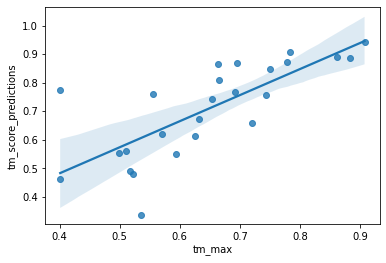

In [ ]:
sequence_df['tm_score_predictions'] = np.array(tm_score_predictions)
sns.regplot(data=sequence_df, x="tm_max", y="tm_score_predictions")

Streaming output truncated to the last 5000 lines.
Progress: 50020/100000 TM-Scores predicted
Progress: 50030/100000 TM-Scores predicted
Progress: 50040/100000 TM-Scores predicted
Progress: 50050/100000 TM-Scores predicted
Progress: 50060/100000 TM-Scores predicted
Progress: 50070/100000 TM-Scores predicted
Progress: 50080/100000 TM-Scores predicted
Progress: 50090/100000 TM-Scores predicted
Progress: 50100/100000 TM-Scores predicted
Progress: 50110/100000 TM-Scores predicted
Progress: 50120/100000 TM-Scores predicted
Progress: 50130/100000 TM-Scores predicted
Progress: 50140/100000 TM-Scores predicted
Progress: 50150/100000 TM-Scores predicted
Progress: 50160/100000 TM-Scores predicted
Progress: 50170/100000 TM-Scores predicted
Progress: 50180/100000 TM-Scores predicted
Progress: 50190/100000 TM-Scores predicted
Progress: 50200/100000 TM-Scores predicted
Progress: 50210/100000 TM-Scores predicted
Progress: 50220/100000 TM-Scores predicted
Progress: 50230/100000 TM-Scores predicted
Pro

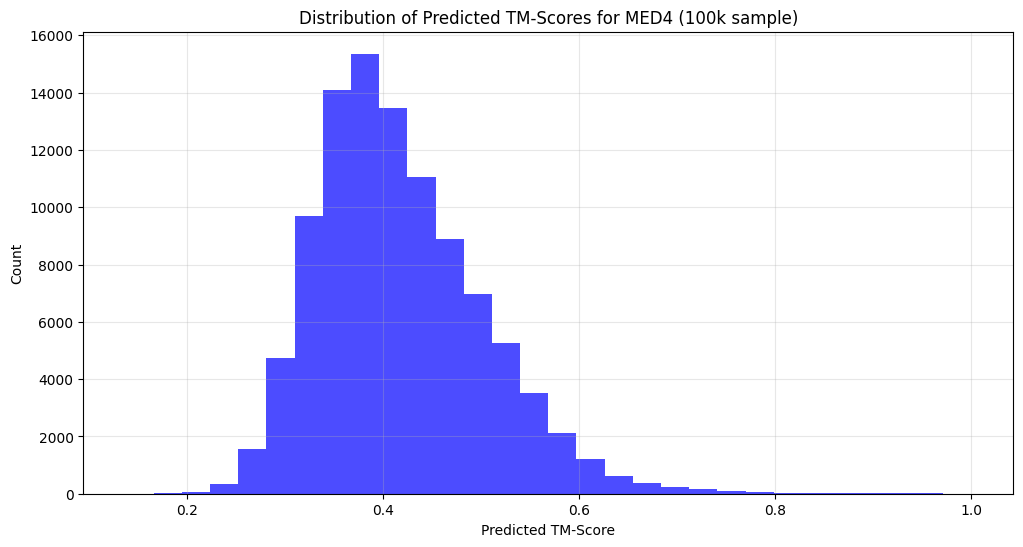


Summary Statistics of Predictions:
count    100000.000000
mean          0.417092
std           0.084690
min           0.136980
25%           0.356586
50%           0.404123
75%           0.467386
max           1.000000
dtype: float64


In [ ]:
#Calculating TM scores using TM-Vec for 100k SAMPLE from full MED4

# Load your CSV file from Google Drive
file_path = '/content/drive/MyDrive/MED4_full.csv'
pairs_df = pd.read_csv(file_path, header=None, names=['Sequence 1', 'Sequence 2'])

# Convert comma-separated sequences into separate columns if needed
if pairs_df.shape[1] == 1:
    pairs_df[['Sequence 1', 'Sequence 2']] = pairs_df[0].str.split(',', expand=True)
    pairs_df = pairs_df.drop(0, axis=1)

# Sample 500,000 sequences randomly
sampled_pairs_df = pairs_df.sample(n=100000, random_state=42)

print(f"Original number of sequence pairs: {len(pairs_df)}")
print(f"Number of sampled sequence pairs: {len(sampled_pairs_df)}")
print("\nFirst few sampled pairs:")
print(sampled_pairs_df.head())

# Now predict TM-Scores
tm_score_predictions = []
for i in range(sampled_pairs_df.shape[0]):
    sequence_1 = sampled_pairs_df.iloc[i]['Sequence 1']
    sequence_2 = sampled_pairs_df.iloc[i]['Sequence 2']

    sequence_1 = np.expand_dims(sequence_1, axis=0)
    sequence_2 = np.expand_dims(sequence_2, axis=0)

    # Featurize sequence 1 and 2 using ProtTrans
    protrans_sequence_1 = featurize_prottrans(sequence_1, model, tokenizer, device).detach()
    protrans_sequence_2 = featurize_prottrans(sequence_2, model, tokenizer, device).detach()

    # Embed sequence 1 and 2 using TM-Vec
    embedded_sequence_1 = embed_tm_vec(protrans_sequence_1, model_deep, device)
    embedded_sequence_2 = embed_tm_vec(protrans_sequence_2, model_deep, device)

    # Predict the TM-score
    predicted_tm_score = cosine_similarity_tm(torch.tensor(embedded_sequence_1), torch.tensor(embedded_sequence_2))

    tm_score_predictions.append(predicted_tm_score.numpy()[0])

    if i % 10 == 0:
        print(f"Progress: {i}/{len(sampled_pairs_df)} TM-Scores predicted")

# Add predictions to dataframe
sampled_pairs_df['TM_Score_Prediction'] = np.array(tm_score_predictions)

# Save results back to Google Drive
output_path = '/content/drive/MyDrive/tm_score_predictions_MED4_100k_sample_results.csv'
sampled_pairs_df.to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")

# Create visualizations
plt.figure(figsize=(12, 6))
plt.hist(tm_score_predictions, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Predicted TM-Scores for MED4 (100k sample)')
plt.xlabel('Predicted TM-Score')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print("\nSummary Statistics of Predictions:")
print(pd.Series(tm_score_predictions).describe())

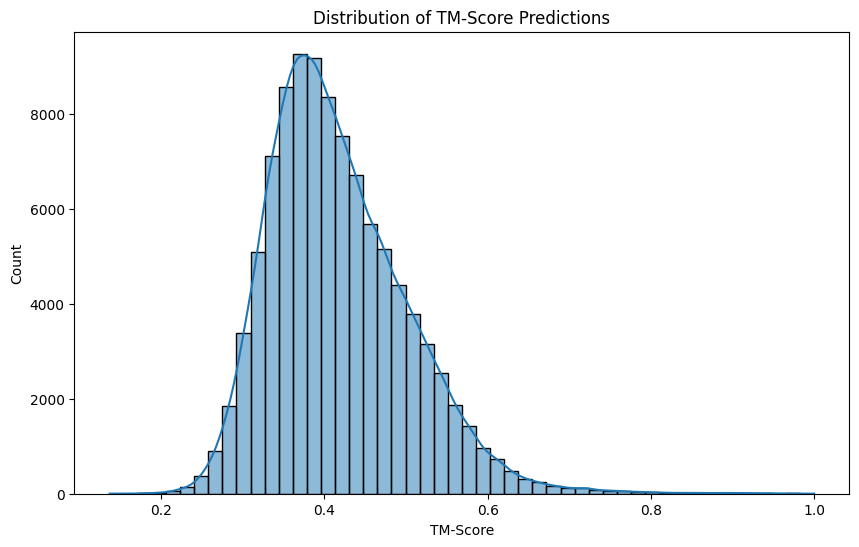

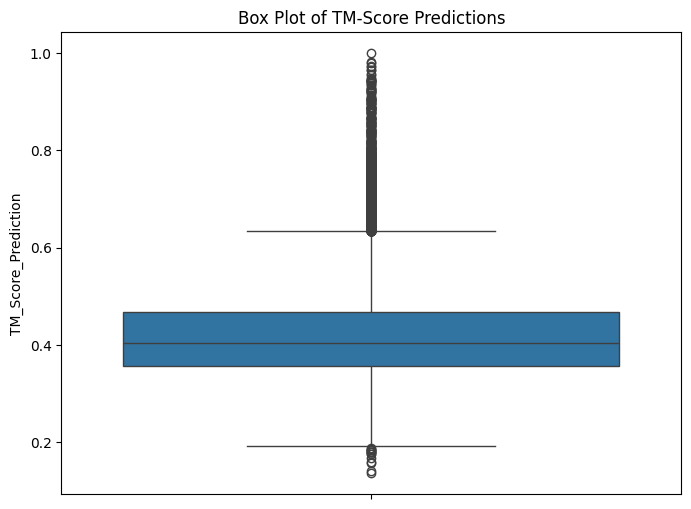

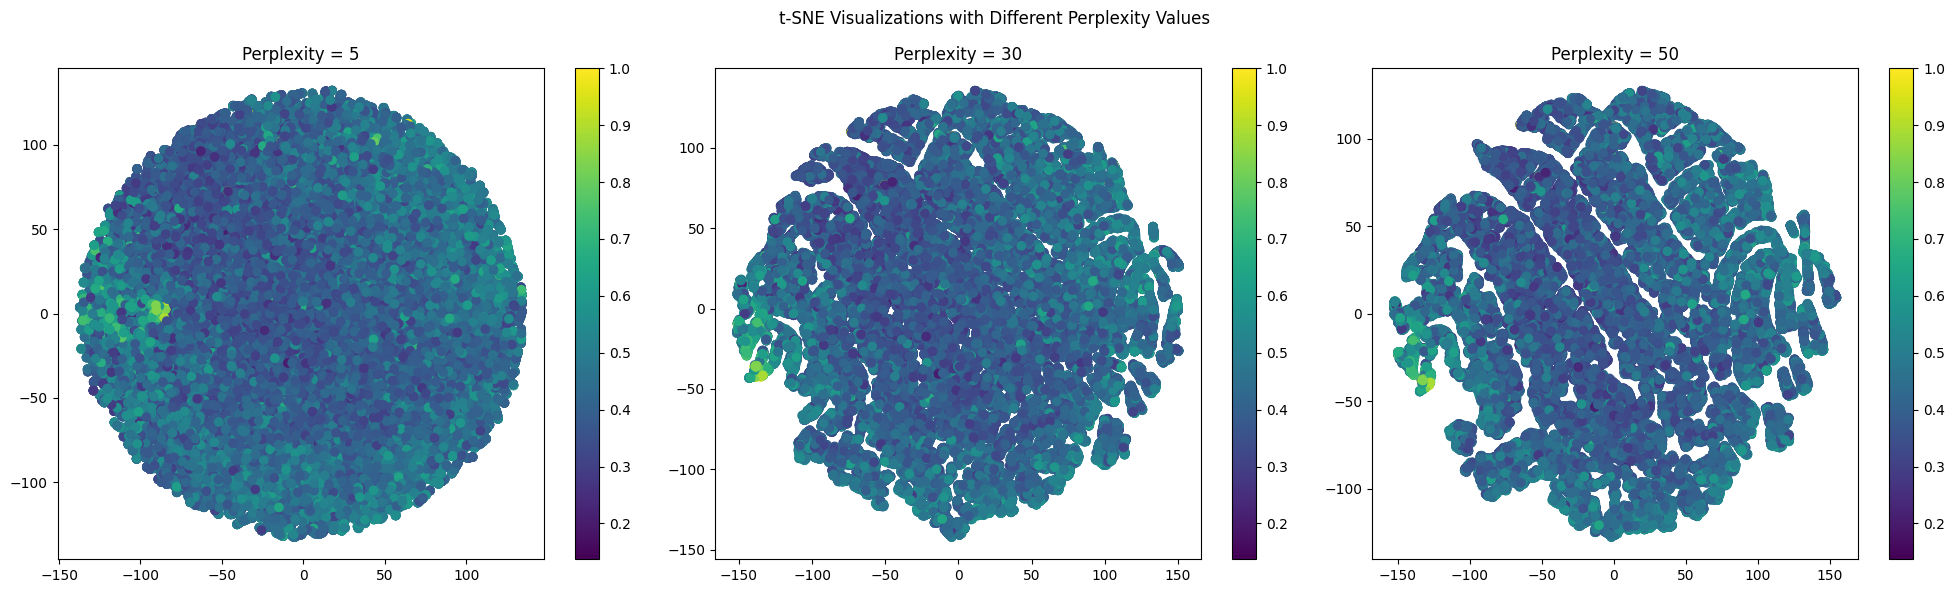

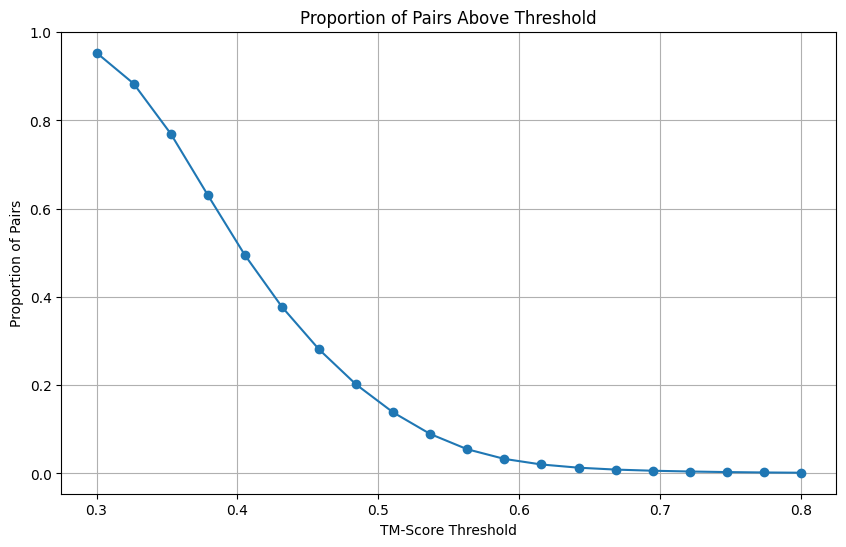

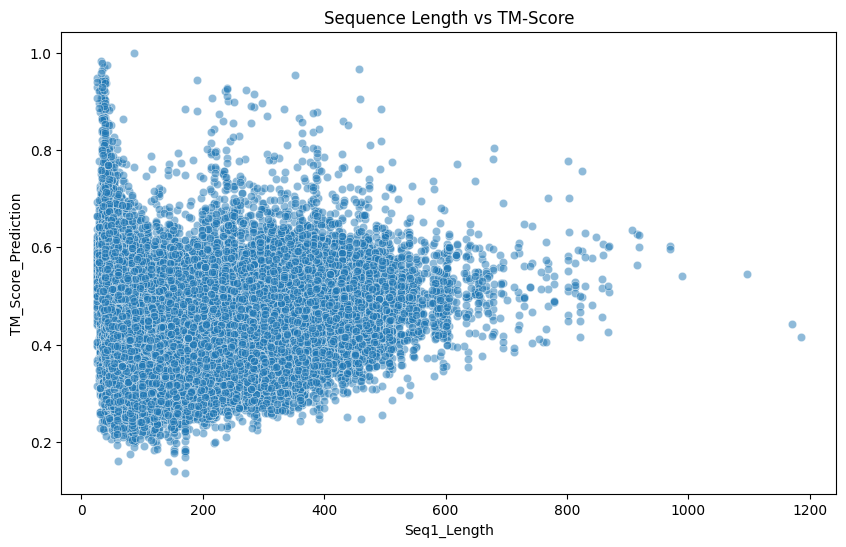

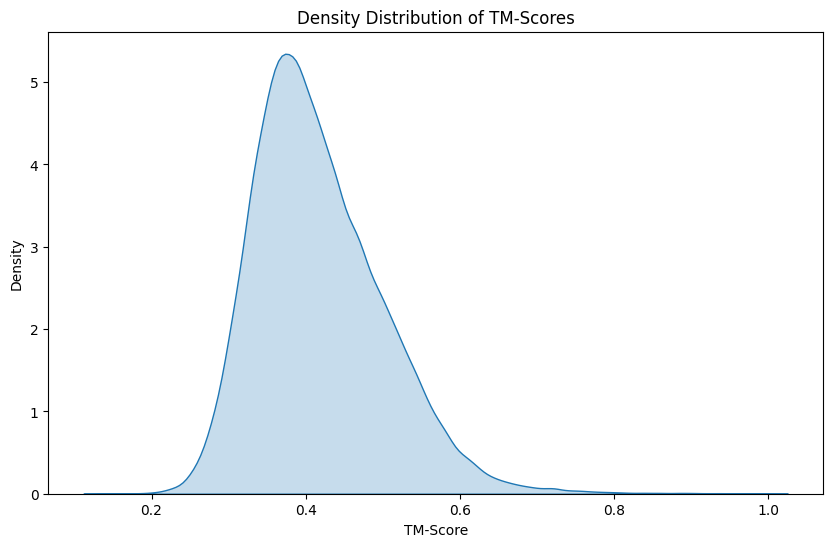


Summary Statistics of TM-Scores:
count    100000.000000
mean          0.417092
std           0.084691
min           0.136980
25%           0.356586
50%           0.404123
75%           0.467386
max           1.000000
Name: TM_Score_Prediction, dtype: float64


<Figure size 640x480 with 0 Axes>

In [ ]:
#Visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Load the data
results_df = pd.read_csv('/content/drive/MyDrive/tm_score_predictions_MED4_100k_sample_results.csv')

# 1. Basic Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='TM_Score_Prediction', bins=50, kde=True)
plt.title('Distribution of TM-Score Predictions')
plt.xlabel('TM-Score')
plt.ylabel('Count')
plt.show()

# 2. Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(y=results_df['TM_Score_Prediction'])
plt.title('Box Plot of TM-Score Predictions')
plt.show()

# 3. t-SNE Visualizations with different perplexity values
def plot_tsne_multiple_perplexity(data, perplexities=[5, 30, 50]):
    fig, axes = plt.subplots(1, len(perplexities), figsize=(20, 6))
    fig.suptitle('t-SNE Visualizations with Different Perplexity Values')

    for idx, perp in enumerate(perplexities):
        tsne = TSNE(n_components=2,
                    perplexity=perp,
                    random_state=42)

        tsne_results = tsne.fit_transform(data)

        scatter = axes[idx].scatter(tsne_results[:, 0], tsne_results[:, 1],
                                  c=results_df['TM_Score_Prediction'],
                                  cmap='viridis')
        axes[idx].set_title(f'Perplexity = {perp}')
        plt.colorbar(scatter, ax=axes[idx])

    plt.tight_layout()
    plt.show()

# Prepare data for t-SNE
# Create feature vectors by combining sequence properties
sequence_features = np.column_stack((
    results_df['TM_Score_Prediction'],
    [len(seq) for seq in results_df['Sequence 1']],
    [len(seq) for seq in results_df['Sequence 2']]
))

# Plot t-SNE with different perplexities
plot_tsne_multiple_perplexity(sequence_features)

# 4. Performance Metrics at Different Thresholds
def analyze_threshold_performance():
    thresholds = np.linspace(0.3, 0.8, 20)
    metrics = []

    for threshold in thresholds:
        predictions = results_df['TM_Score_Prediction'] >= threshold
        metrics.append({
            'threshold': threshold,
            'ratio': np.mean(predictions)
        })

    metrics_df = pd.DataFrame(metrics)

    plt.figure(figsize=(10, 6))
    plt.plot(metrics_df['threshold'], metrics_df['ratio'], marker='o')
    plt.title('Proportion of Pairs Above Threshold')
    plt.xlabel('TM-Score Threshold')
    plt.ylabel('Proportion of Pairs')
    plt.grid(True)
    plt.show()

analyze_threshold_performance()

# 5. Correlation Analysis
def analyze_sequence_length_correlation():
    results_df['Seq1_Length'] = results_df['Sequence 1'].str.len()
    results_df['Seq2_Length'] = results_df['Sequence 2'].str.len()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=results_df, x='Seq1_Length', y='TM_Score_Prediction', alpha=0.5)
    plt.title('Sequence Length vs TM-Score')
    plt.show()

analyze_sequence_length_correlation()

# 6. Density Plot of TM-Scores
plt.figure(figsize=(10, 6))
sns.kdeplot(data=results_df['TM_Score_Prediction'], fill=True)
plt.title('Density Distribution of TM-Scores')
plt.xlabel('TM-Score')
plt.ylabel('Density')
plt.show()

# 7. Summary Statistics
print("\nSummary Statistics of TM-Scores:")
print(results_df['TM_Score_Prediction'].describe())

# Save all visualizations
plt.savefig('tm_score_visualizations.pdf')

Basic Statistical Analysis:
--------------------------------------------------
Mean TM-Score: 0.4171
Median TM-Score: 0.4041
Standard Deviation: 0.0847
Variance: 0.0072
Minimum: 0.1370
Maximum: 1.0000

Quartile Analysis:
First Quartile (Q1): 0.3566
Third Quartile (Q3): 0.4674
Interquartile Range (IQR): 0.1108

Distribution Analysis:
--------------------------------------------------
Skewness: 0.8862
Kurtosis: 1.6700

Normality Test (D'Agostino-Pearson):
Statistic: 13580.9263
p-value: 0.0000e+00
Conclusion: Data is not normally distributed


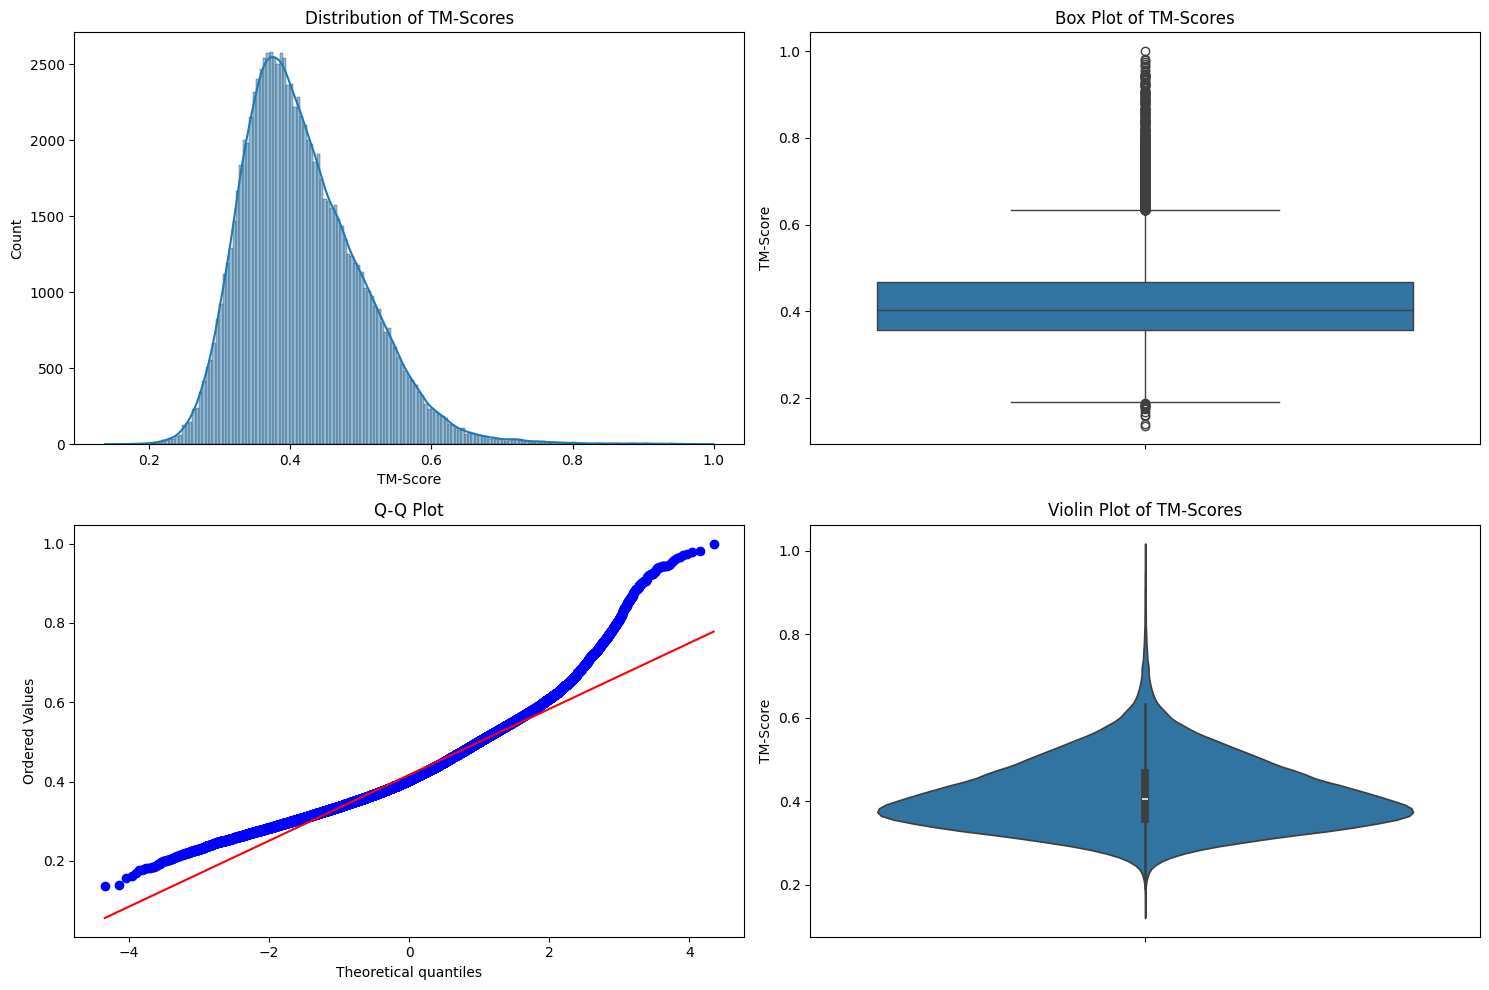


Sequence Length Analysis:
--------------------------------------------------

Correlation between sequence lengths and TM-Score:
Correlation (Seq1 Length vs TM-Score): 0.0873
Correlation (Seq2 Length vs TM-Score): 0.1020

Threshold Analysis:
--------------------------------------------------
Pairs with TM-Score >= 0.3: 95.34%
Pairs with TM-Score >= 0.4: 52.07%
Pairs with TM-Score >= 0.5: 16.18%
Pairs with TM-Score >= 0.6: 2.72%
Pairs with TM-Score >= 0.7: 0.56%
Pairs with TM-Score >= 0.8: 0.15%


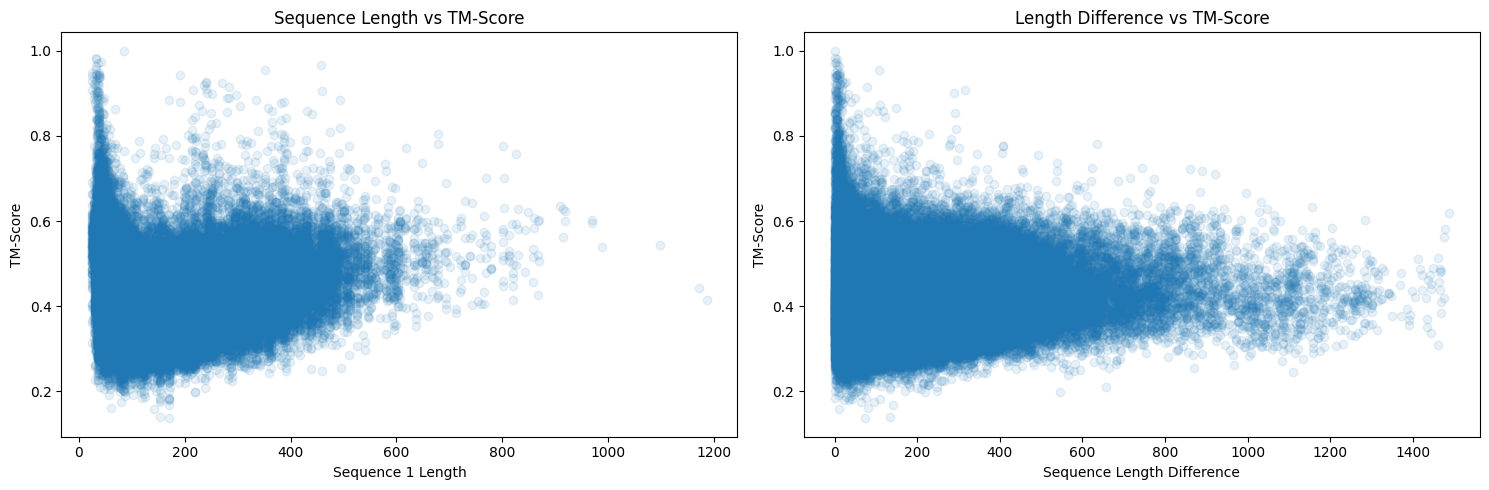

In [ ]:
#Visualizations
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import normaltest, skew, kurtosis

# Load the data
results_df = pd.read_csv('/content/drive/MyDrive/tm_score_predictions_MED4_100k_sample_results.csv')
tm_scores = results_df['TM_Score_Prediction']

# 1. Basic Statistical Measures
print("Basic Statistical Analysis:")
print("-" * 50)
print(f"Mean TM-Score: {tm_scores.mean():.4f}")
print(f"Median TM-Score: {tm_scores.median():.4f}")
print(f"Standard Deviation: {tm_scores.std():.4f}")
print(f"Variance: {tm_scores.var():.4f}")
print(f"Minimum: {tm_scores.min():.4f}")
print(f"Maximum: {tm_scores.max():.4f}")

# Calculate quartiles
q1, q3 = np.percentile(tm_scores, [25, 75])
iqr = q3 - q1
print(f"\nQuartile Analysis:")
print(f"First Quartile (Q1): {q1:.4f}")
print(f"Third Quartile (Q3): {q3:.4f}")
print(f"Interquartile Range (IQR): {iqr:.4f}")

# 2. Distribution Analysis
print("\nDistribution Analysis:")
print("-" * 50)
print(f"Skewness: {skew(tm_scores):.4f}")
print(f"Kurtosis: {kurtosis(tm_scores):.4f}")

# Normality test
stat, p_value = normaltest(tm_scores)
print(f"\nNormality Test (D'Agostino-Pearson):")
print(f"Statistic: {stat:.4f}")
print(f"p-value: {p_value:.4e}")
print("Conclusion: Data is", "normally distributed" if p_value > 0.05 else "not normally distributed")

# 3. Visualizations
plt.figure(figsize=(15, 10))

# Histogram with KDE
plt.subplot(2, 2, 1)
sns.histplot(tm_scores, kde=True)
plt.title('Distribution of TM-Scores')
plt.xlabel('TM-Score')
plt.ylabel('Count')

# Box plot
plt.subplot(2, 2, 2)
sns.boxplot(y=tm_scores)
plt.title('Box Plot of TM-Scores')
plt.ylabel('TM-Score')

# Q-Q plot
plt.subplot(2, 2, 3)
stats.probplot(tm_scores, dist="norm", plot=plt)
plt.title('Q-Q Plot')

# Violin plot
plt.subplot(2, 2, 4)
sns.violinplot(y=tm_scores)
plt.title('Violin Plot of TM-Scores')
plt.ylabel('TM-Score')

plt.tight_layout()
plt.show()

# 4. Sequence Length Analysis
results_df['Seq1_Length'] = results_df['Sequence 1'].str.len()
results_df['Seq2_Length'] = results_df['Sequence 2'].str.len()
results_df['Length_Difference'] = abs(results_df['Seq1_Length'] - results_df['Seq2_Length'])

print("\nSequence Length Analysis:")
print("-" * 50)
print("\nCorrelation between sequence lengths and TM-Score:")
correlation = np.corrcoef([
    results_df['Seq1_Length'],
    results_df['Seq2_Length'],
    results_df['TM_Score_Prediction']
])
print(f"Correlation (Seq1 Length vs TM-Score): {correlation[0,2]:.4f}")
print(f"Correlation (Seq2 Length vs TM-Score): {correlation[1,2]:.4f}")

# 5. Threshold Analysis
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
print("\nThreshold Analysis:")
print("-" * 50)
for threshold in thresholds:
    above_threshold = (tm_scores >= threshold).sum()
    percentage = (above_threshold / len(tm_scores)) * 100
    print(f"Pairs with TM-Score >= {threshold}: {percentage:.2f}%")

# 6. Additional Visualizations
plt.figure(figsize=(15, 5))

# Sequence length vs TM-Score
plt.subplot(1, 2, 1)
plt.scatter(results_df['Seq1_Length'], results_df['TM_Score_Prediction'], alpha=0.1)
plt.xlabel('Sequence 1 Length')
plt.ylabel('TM-Score')
plt.title('Sequence Length vs TM-Score')

# Length difference vs TM-Score
plt.subplot(1, 2, 2)
plt.scatter(results_df['Length_Difference'], results_df['TM_Score_Prediction'], alpha=0.1)
plt.xlabel('Sequence Length Difference')
plt.ylabel('TM-Score')
plt.title('Length Difference vs TM-Score')

plt.tight_layout()
plt.show()

# Save statistics to file
with open('tm_score_statistics.txt', 'w') as f:
    f.write("TM-Score Statistical Analysis\n")
    f.write("-" * 50 + "\n")
    f.write(f"Total number of pairs analyzed: {len(tm_scores)}\n")
    f.write(f"Mean TM-Score: {tm_scores.mean():.4f}\n")
    f.write(f"Median TM-Score: {tm_scores.median():.4f}\n")
    f.write(f"Standard Deviation: {tm_scores.std():.4f}\n")
    f.write(f"Skewness: {skew(tm_scores):.4f}\n")
    f.write(f"Kurtosis: {kurtosis(tm_scores):.4f}\n")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats

# Load the data
results_df = pd.read_csv('/content/drive/MyDrive/tm_score_predictions_MED4_100k_sample_results.csv')

# Calculate cosine similarity for each pair
def calculate_cosine_sim(seq1, seq2):
    unique_chars = set(''.join(results_df['Sequence 1'].tolist() + results_df['Sequence 2'].tolist()))
    char_to_idx = {c: i for i, c in enumerate(unique_chars)}

    vec1 = np.zeros(len(char_to_idx))
    vec2 = np.zeros(len(char_to_idx))

    for char in seq1:
        vec1[char_to_idx[char]] += 1
    for char in seq2:
        vec2[char_to_idx[char]] += 1

    return 1 - cosine(vec1, vec2)

# Calculate cosine similarities
print("Calculating cosine similarities...")
cosine_similarities = [calculate_cosine_sim(seq1, seq2)
                      for seq1, seq2 in zip(results_df['Sequence 1'], results_df['Sequence 2'])]

# Add cosine similarities to the dataframe
results_df['Cosine_Similarity'] = cosine_similarities

# Save the updated dataframe with cosine similarities
output_path = '/content/drive/MyDrive/tm_score_and_cosine_similarities_MED4_100K.csv'
results_df.to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")

# Create visualization
plt.figure(figsize=(12, 8))

# Scatter plot with regression line
sns.regplot(x=cosine_similarities,
            y=results_df['TM_Score_Prediction'],
            scatter_kws={'alpha':0.5},
            line_kws={'color': 'red'})

plt.title('TM-Score vs Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('TM-Score')

# Calculate and display correlation
correlation = np.corrcoef(cosine_similarities, results_df['TM_Score_Prediction'])[0,1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
         transform=plt.gca().transAxes)

plt.savefig('/content/drive/MyDrive/tm_vs_cosine_MED4_100K_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("\nStatistical Summary:")
print("\nCosine Similarity Statistics:")
print(pd.Series(cosine_similarities).describe())
print("\nTM-Score Statistics:")
print(results_df['TM_Score_Prediction'].describe())

# Save statistics to text file
with open('/content/drive/MyDrive/similarity_statistics_MED4_100K.txt', 'w') as f:
    f.write("Statistical Analysis Results\n")
    f.write("-" * 50 + "\n")
    f.write(f"Correlation coefficient: {correlation:.4f}\n\n")
    f.write("Cosine Similarity Statistics:\n")
    f.write(pd.Series(cosine_similarities).describe().to_string())
    f.write("\n\nTM-Score Statistics:\n")
    f.write(results_df['TM_Score_Prediction'].describe().to_string())

Calculating cosine similarities...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Group Analysis:
--------------------------------------------------
     Group  Avg_Length_1  Avg_Length_2  Avg_Hydrophobic_1  Avg_Hydrophobic_2  \
0  High TM    150.084833    272.356592           0.439306           0.418179   
0   Low TM    141.659823    326.472062           0.383210           0.381544   

   Avg_Charged_1  Avg_Charged_2  Avg_Polar_1  Avg_Polar_2  Count  
0       0.218691       0.228053     0.198038     0.210969   2723  
0       0.252610       0.244359     0.214967     0.218013  47928  

Detailed analysis saved to: /content/drive/MyDrive/tm_score_group_analysis.csv

Statistical Tests:
--------------------------------------------------
T-test for length difference between groups: p-value = 1.6946e-81


<ipython-input-2-31d785bcd5aa>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_tm_pairs['Length_Diff'] = abs(high_tm_pairs['Sequence 1'].str.len() - high_tm_pairs['Sequence 2'].str.len())
<ipython-input-2-31d785bcd5aa>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_tm_pairs['Length_Diff'] = abs(low_tm_pairs['Sequence 1'].str.len() - low_tm_pairs['Sequence 2'].str.len())


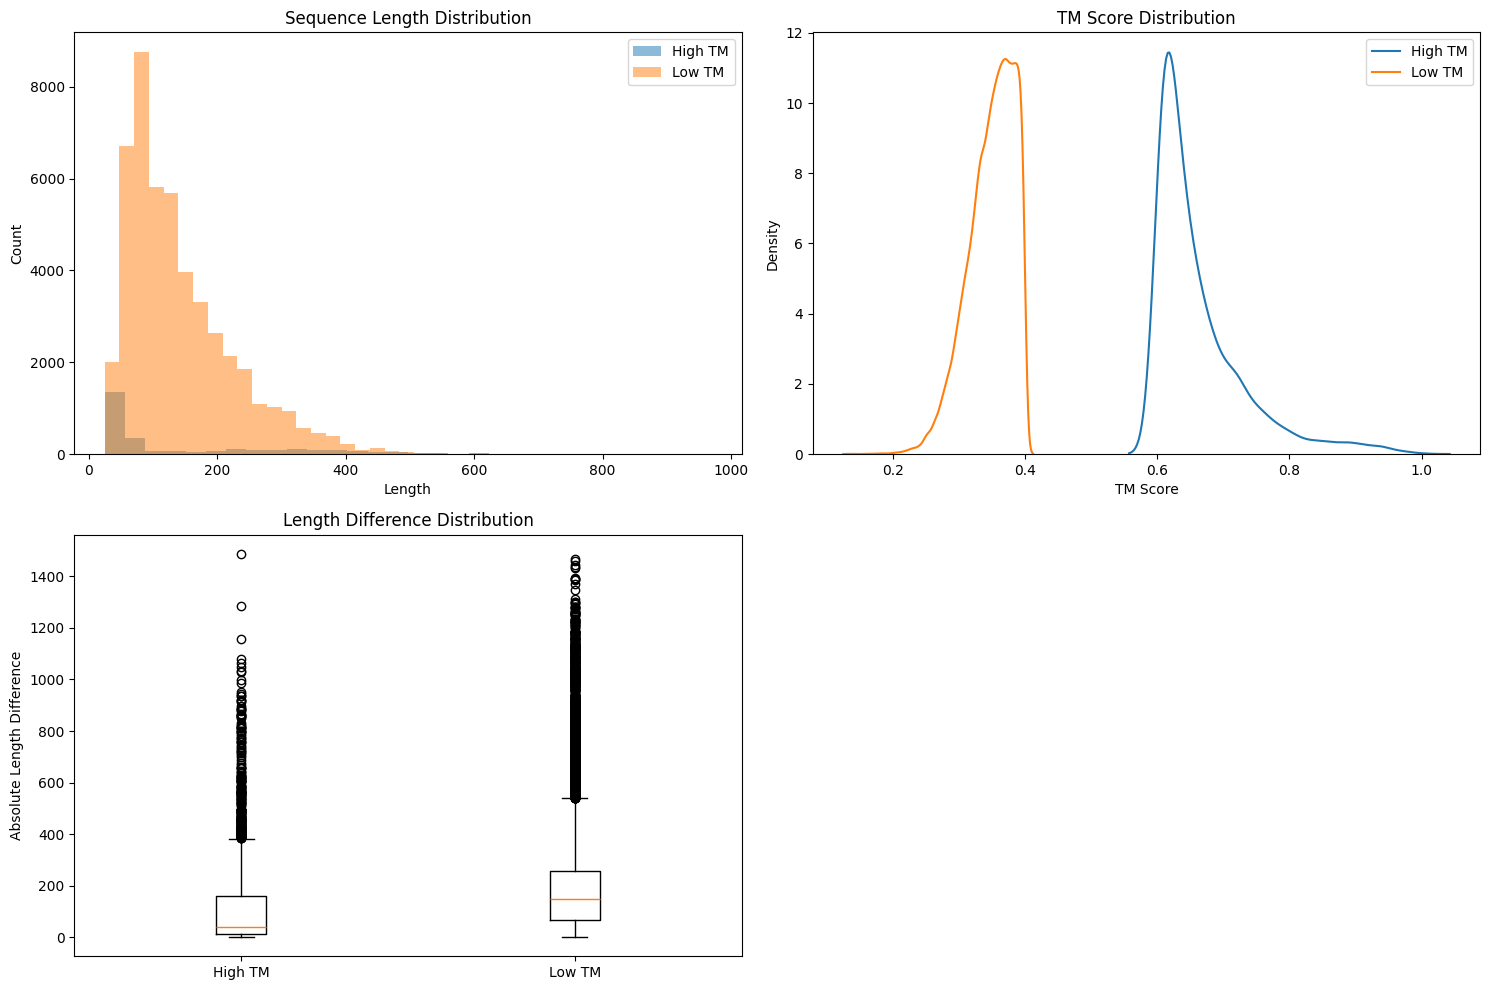

In [ ]:
#Visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
results_df = pd.read_csv('/content/drive/MyDrive/tm_score_predictions_MED4_100k_sample_results.csv')

# Define thresholds for high and low TM scores
# Using the box plot, we can see a clear separation
high_threshold = 0.6  # Pairs with TM score >= 0.9
low_threshold = 0.4   # Pairs with TM score <= 0.1

# Create groups
high_tm_pairs = results_df[results_df['TM_Score_Prediction'] >= high_threshold]
low_tm_pairs = results_df[results_df['TM_Score_Prediction'] <= low_threshold]

# Calculate sequence properties for each group
def analyze_sequence_properties(sequence):
    return {
        'length': len(sequence),
        'hydrophobic_content': len([aa for aa in sequence if aa in 'AILMFWV'])/len(sequence),
        'charged_content': len([aa for aa in sequence if aa in 'DEKR'])/len(sequence),
        'polar_content': len([aa for aa in sequence if aa in 'STNQ'])/len(sequence)
    }

# Analyze both groups
def analyze_group(group, name):
    properties_1 = pd.DataFrame([analyze_sequence_properties(seq) for seq in group['Sequence 1']])
    properties_2 = pd.DataFrame([analyze_sequence_properties(seq) for seq in group['Sequence 2']])

    return pd.DataFrame({
        'Group': name,
        'Avg_Length_1': properties_1['length'].mean(),
        'Avg_Length_2': properties_2['length'].mean(),
        'Avg_Hydrophobic_1': properties_1['hydrophobic_content'].mean(),
        'Avg_Hydrophobic_2': properties_2['hydrophobic_content'].mean(),
        'Avg_Charged_1': properties_1['charged_content'].mean(),
        'Avg_Charged_2': properties_2['charged_content'].mean(),
        'Avg_Polar_1': properties_1['polar_content'].mean(),
        'Avg_Polar_2': properties_2['polar_content'].mean(),
        'Count': len(group)
    }, index=[0])

high_group_stats = analyze_group(high_tm_pairs, 'High TM')
low_group_stats = analyze_group(low_tm_pairs, 'Low TM')
stats_comparison = pd.concat([high_group_stats, low_group_stats])

# Print detailed statistics
print("Group Analysis:")
print("-" * 50)
print(stats_comparison)

# Visualizations
plt.figure(figsize=(15, 10))

# 1. Length Distribution
plt.subplot(2, 2, 1)
plt.hist(high_tm_pairs['Sequence 1'].str.len(), alpha=0.5, label='High TM', bins=30)
plt.hist(low_tm_pairs['Sequence 1'].str.len(), alpha=0.5, label='Low TM', bins=30)
plt.title('Sequence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend()

# 2. TM Score Distribution
plt.subplot(2, 2, 2)
sns.kdeplot(data=high_tm_pairs['TM_Score_Prediction'], label='High TM')
sns.kdeplot(data=low_tm_pairs['TM_Score_Prediction'], label='Low TM')
plt.title('TM Score Distribution')
plt.xlabel('TM Score')
plt.ylabel('Density')
plt.legend()

# Save results
output_path = '/content/drive/MyDrive/tm_score_group_analysis.csv'
stats_comparison.to_csv(output_path, index=False)
print(f"\nDetailed analysis saved to: {output_path}")

# Additional analysis: Length difference within pairs
high_tm_pairs['Length_Diff'] = abs(high_tm_pairs['Sequence 1'].str.len() - high_tm_pairs['Sequence 2'].str.len())
low_tm_pairs['Length_Diff'] = abs(low_tm_pairs['Sequence 1'].str.len() - low_tm_pairs['Sequence 2'].str.len())

plt.subplot(2, 2, 3)
plt.boxplot([high_tm_pairs['Length_Diff'], low_tm_pairs['Length_Diff']],
           labels=['High TM', 'Low TM'])
plt.title('Length Difference Distribution')
plt.ylabel('Absolute Length Difference')

# Statistical tests
from scipy import stats
t_stat, p_value = stats.ttest_ind(high_tm_pairs['Length_Diff'], low_tm_pairs['Length_Diff'])
print("\nStatistical Tests:")
print("-" * 50)
print(f"T-test for length difference between groups: p-value = {p_value:.4e}")

plt.tight_layout()
plt.show()

# Save example sequences
print("\nExample High TM Score Pairs:")
print(high_tm_pairs[['Sequence 1', 'Sequence 2', 'TM_Score_Prediction']].head())
print("\nExample Low TM Score Pairs:")
print(low_tm_pairs[['Sequence 1', 'Sequence 2', 'TM_Score_Prediction']].head())

In [ ]:
#Visualizations
import pandas as pd
import numpy as np

# Load the data
results_df = pd.read_csv('/content/drive/MyDrive/tm_score_predictions_MED4_100k_sample_results.csv')

# Define thresholds
high_threshold = 0.7
low_threshold  = 0.25

# Separate into high and low TM score groups
high_tm_pairs = results_df[results_df['TM_Score_Prediction'] >= high_threshold]
low_tm_pairs = results_df[results_df['TM_Score_Prediction'] <= low_threshold]

# Create Cytoscape files
def create_cytoscape_files(pairs_df, group_name):
    # Create network file
    network_data = []
    for _, row in pairs_df.iterrows():
        network_data.append({
            'Source': row['Sequence 1'],
            'Target': row['Sequence 2'],
            'TM_Score': row['TM_Score_Prediction'],
            'Group': group_name,
            'Interaction_Type': 'High_TM' if group_name == 'High_TM' else 'Low_TM'
        })

    network_df = pd.DataFrame(network_data)

    # Save as CSV for Cytoscape
    output_path = f'/content/drive/MyDrive/cytoscape_{group_name.lower()}_network.csv'
    network_df.to_csv(output_path, index=False)
    print(f"Network file saved: {output_path}")

    return network_df

# Create files for both groups
high_network = create_cytoscape_files(high_tm_pairs, 'High_TM_0.7')
low_network = create_cytoscape_files(low_tm_pairs, 'Low_TM_0.25')

# Create combined network file
combined_network = pd.concat([high_network, low_network])
combined_output = '/content/drive/MyDrive/cytoscape_combined_network.csv'
combined_network.to_csv(combined_output, index=False)
print(f"\nCombined network file saved: {combined_output}")

# Print statistics
print("\nNetwork Statistics:")
print("-" * 50)
print(f"High TM Score pairs: {len(high_tm_pairs)}")
print(f"Low TM Score pairs: {len(low_tm_pairs)}")
print(f"Total unique proteins in high TM group: {len(set(high_tm_pairs['Sequence 1']).union(set(high_tm_pairs['Sequence 2'])))}")
print(f"Total unique proteins in low TM group: {len(set(low_tm_pairs['Sequence 1']).union(set(low_tm_pairs['Sequence 2'])))}")

print("\nTo visualize in Cytoscape:")
print("1. Open Cytoscape")
print("2. File → Import → Network from File...")
print("3. Select the created CSV file")
print("4. In the import dialog:")
print("   - Set 'Source' column as source nodes")
print("   - Set 'Target' column as target nodes")
print("   - Set 'TM_Score' as edge attribute")
print("   - Set 'Group' as node/edge attribute")
print("5. Suggested visualization settings:")
print("   - Color edges by TM_Score")
print("   - Use different colors for High_TM and Low_TM groups")
print("   - Size nodes by degree (number of connections)")
print("   - Use Force-Directed Layout")

Network file saved: /content/drive/MyDrive/cytoscape_high_tm_0.7_network.csv
Network file saved: /content/drive/MyDrive/cytoscape_low_tm_0.25_network.csv

Combined network file saved: /content/drive/MyDrive/cytoscape_combined_network.csv

Network Statistics:
--------------------------------------------------
High TM Score pairs: 565
Low TM Score pairs: 387
Total unique proteins in high TM group: 472
Total unique proteins in low TM group: 359

To visualize in Cytoscape:
1. Open Cytoscape
2. File → Import → Network from File...
3. Select the created CSV file
4. In the import dialog:
   - Set 'Source' column as source nodes
   - Set 'Target' column as target nodes
   - Set 'TM_Score' as edge attribute
   - Set 'Group' as node/edge attribute
5. Suggested visualization settings:
   - Color edges by TM_Score
   - Use different colors for High_TM and Low_TM groups
   - Size nodes by degree (number of connections)
   - Use Force-Directed Layout


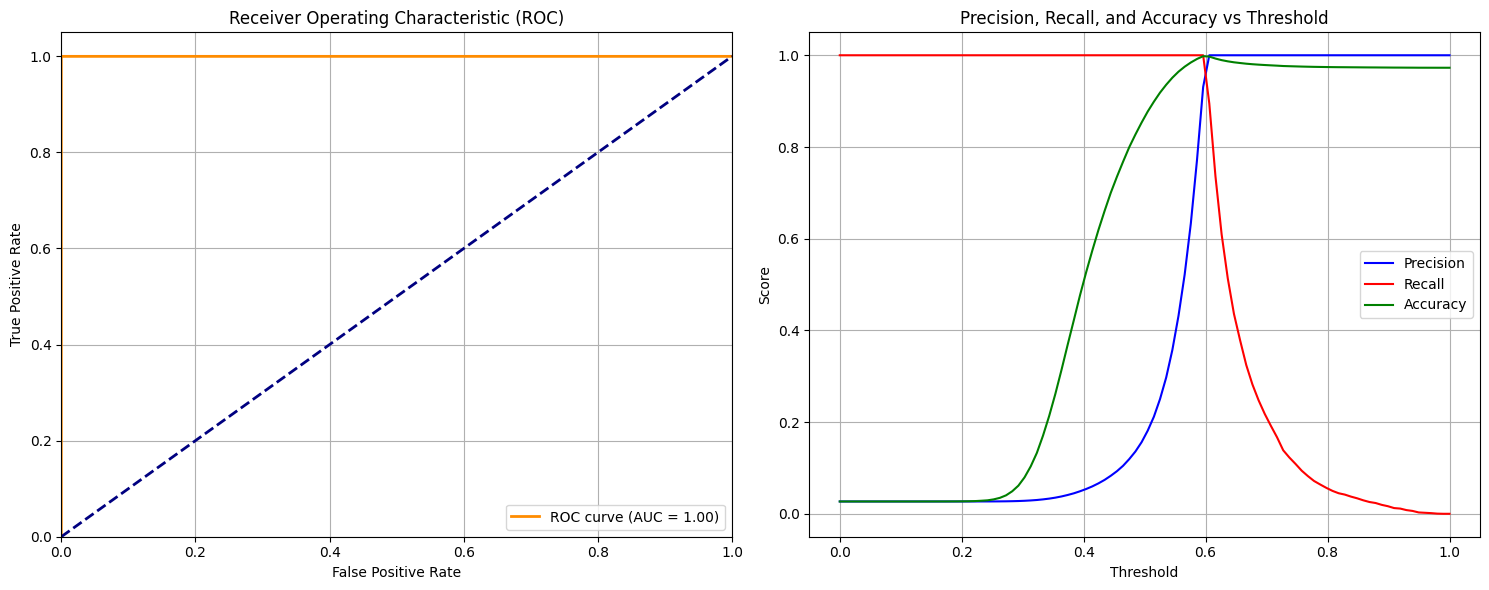


Metrics at key thresholds:
Threshold	Accuracy	Precision	Recall
0.3		0.080		0.029		1.000
0.4		0.527		0.054		1.000
0.5		0.853		0.156		1.000
0.6		0.998		0.931		1.000
0.7		0.979		1.000		0.218
0.8		0.974		1.000		0.057

ROC AUC Score: 1.000


In [ ]:
#Visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score

# Load the full dataset
results_df = pd.read_csv('/content/drive/MyDrive/tm_score_predictions_MED4_100k_sample_results.csv')

# Get the TM scores
scores = results_df['TM_Score_Prediction']

# Create binary labels (1 for high TM scores, 0 for low TM scores)
threshold = 0.6  # defining high TM scores
y_true = (scores >= threshold).astype(int)

# Calculate metrics for different thresholds
thresholds = np.linspace(0, 1, 100)
accuracies = []
precisions = []
recalls = []

for thresh in thresholds:
    y_pred = (scores >= thresh).astype(int)
    # Calculate accuracy
    accuracies.append(accuracy_score(y_true, y_pred))
    # Calculate precision and recall
    tp = np.sum((y_pred == 1) & (y_true == 1))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    precisions.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
    recalls.append(tp / (tp + fn) if (tp + fn) > 0 else 0)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot ROC curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC)')
ax1.legend(loc="lower right")
ax1.grid(True)

# Plot Precision/Recall/Accuracy curves
ax2.plot(thresholds, precisions, label='Precision', color='blue')
ax2.plot(thresholds, recalls, label='Recall', color='red')
ax2.plot(thresholds, accuracies, label='Accuracy', color='green')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Score')
ax2.set_title('Precision, Recall, and Accuracy vs Threshold')
ax2.legend(loc="best")
ax2.grid(True)

plt.tight_layout()

# Save the plot
plt.savefig('/content/drive/MyDrive/performance_curves_full_dataset.png', dpi=300, bbox_inches='tight')
plt.show()

# Print metrics at key thresholds
print("\nMetrics at key thresholds:")
print("Threshold\tAccuracy\tPrecision\tRecall")
key_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
for thresh in key_thresholds:
    idx = np.abs(thresholds - thresh).argmin()
    print(f"{thresh:.1f}\t\t{accuracies[idx]:.3f}\t\t{precisions[idx]:.3f}\t\t{recalls[idx]:.3f}")

print(f"\nROC AUC Score: {roc_auc:.3f}")

# Save metrics to CSV
metrics_df = pd.DataFrame({
    'Threshold': thresholds,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls
})
metrics_df.to_csv('/content/drive/MyDrive/performance_metrics.csv', index=False)

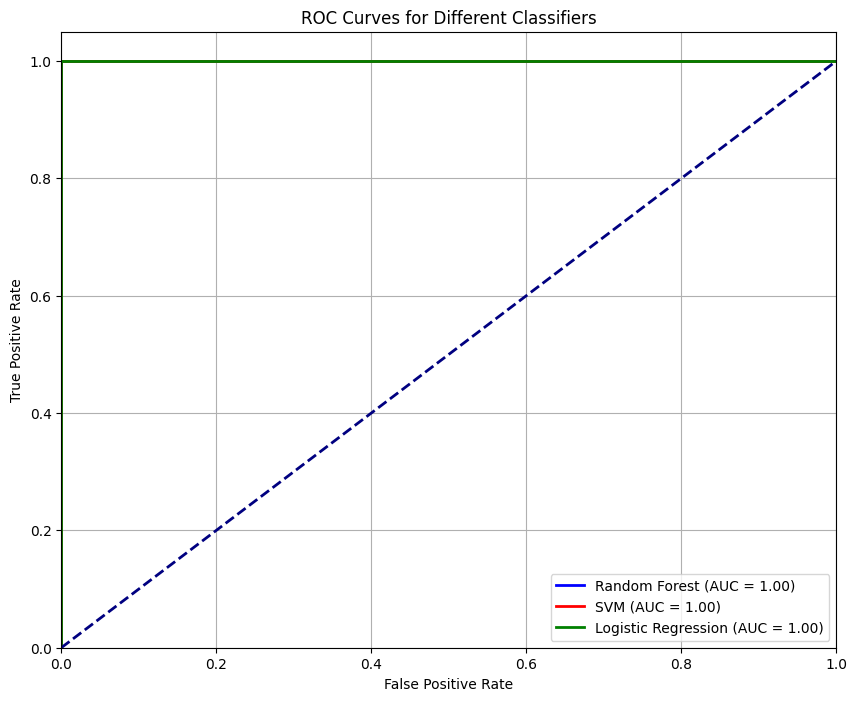


Detailed Performance Metrics:

Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19466
           1       1.00      1.00      1.00       534

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


SVM:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19466
           1       1.00      1.00      1.00       534

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000


Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19466
           1       1.00      0.99      1.00       534

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000

In [ ]:
#Visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

# Load data
results_df = pd.read_csv('/content/drive/MyDrive/tm_score_predictions_MED4_100k_sample_results.csv')

# Create features (you might want to add more relevant features)
X = np.array(results_df['TM_Score_Prediction']).reshape(-1, 1)
y = (results_df['TM_Score_Prediction'] >= 0.6).astype(int)  # Binary classification

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42)
}

# Train and evaluate each classifier
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']

for (name, clf), color in zip(classifiers.items(), colors):
    # Train the classifier
    clf.fit(X_train_scaled, y_train)

    # Get predictions
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{name} (AUC = {roc_auc:.2f})')

# Add diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Classifiers')
plt.legend(loc="lower right")
plt.grid(True)

# Save plot
plt.savefig('/content/drive/MyDrive/classifier_comparison_roc.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed metrics for each classifier
from sklearn.metrics import classification_report

print("\nDetailed Performance Metrics:")
print("=" * 50)
for name, clf in classifiers.items():
    print(f"\n{name}:")
    y_pred = clf.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))

In [ ]:
#here will be calculating TM-score for Sarah interactome and comparing it the high score TM-scores in the 100K


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Total number of sequence pairs: 1085

First few pairs:
                                          Sequence 1  \
0                              Protein_Sequence_ORF1   
1  VPNNQNRDNFIDKAFTVIAESIVKIMPIADKEKKAYIYYRDGLAAQ...   
2  MEPNVYILILLIIIILVGSACCSGVEAAFLAVNSIRILELASKQKP...   
3   MKKRYKKVIYIFIAIVLISIIGGVVKYSFRYIDENPDKYIPKTKQIII   
4   MKKRYKKVIYIFIAIVLISIIGGVVKYSFRYIDENPDKYIPKTKQIII   

                                          Sequence 2 Relationship  
0                              Protein_Sequence_ORF2      friends  
1  VPNNQNRDNFIDKAFTVIAESIVKIMPIADKEKKAYIYYRDGLAAQ...      friends  
2  MKNNKVKVGCVVPCYKGGKKTINVIKSALKYTDLLVLVDDRCPYNT...      friends  
3  LVKPKSPDNKISNHLQQDVVKIAGKTIFINPFLYWRRFDENTNRWL...      friends  
4  MVKRKVILFGASGHLGNYLNKTLINNNFSVKTPSRIEVNEILNNKY...      friends  

Validating sequences...

Proceeding with 1084 valid pairs
Progress: 1/1084 pairs processed (0.1%)
Estimated time remaining: 27.0 minutes
Progress: 101/1084 pairs processed (9.3%)
Estimated time remai

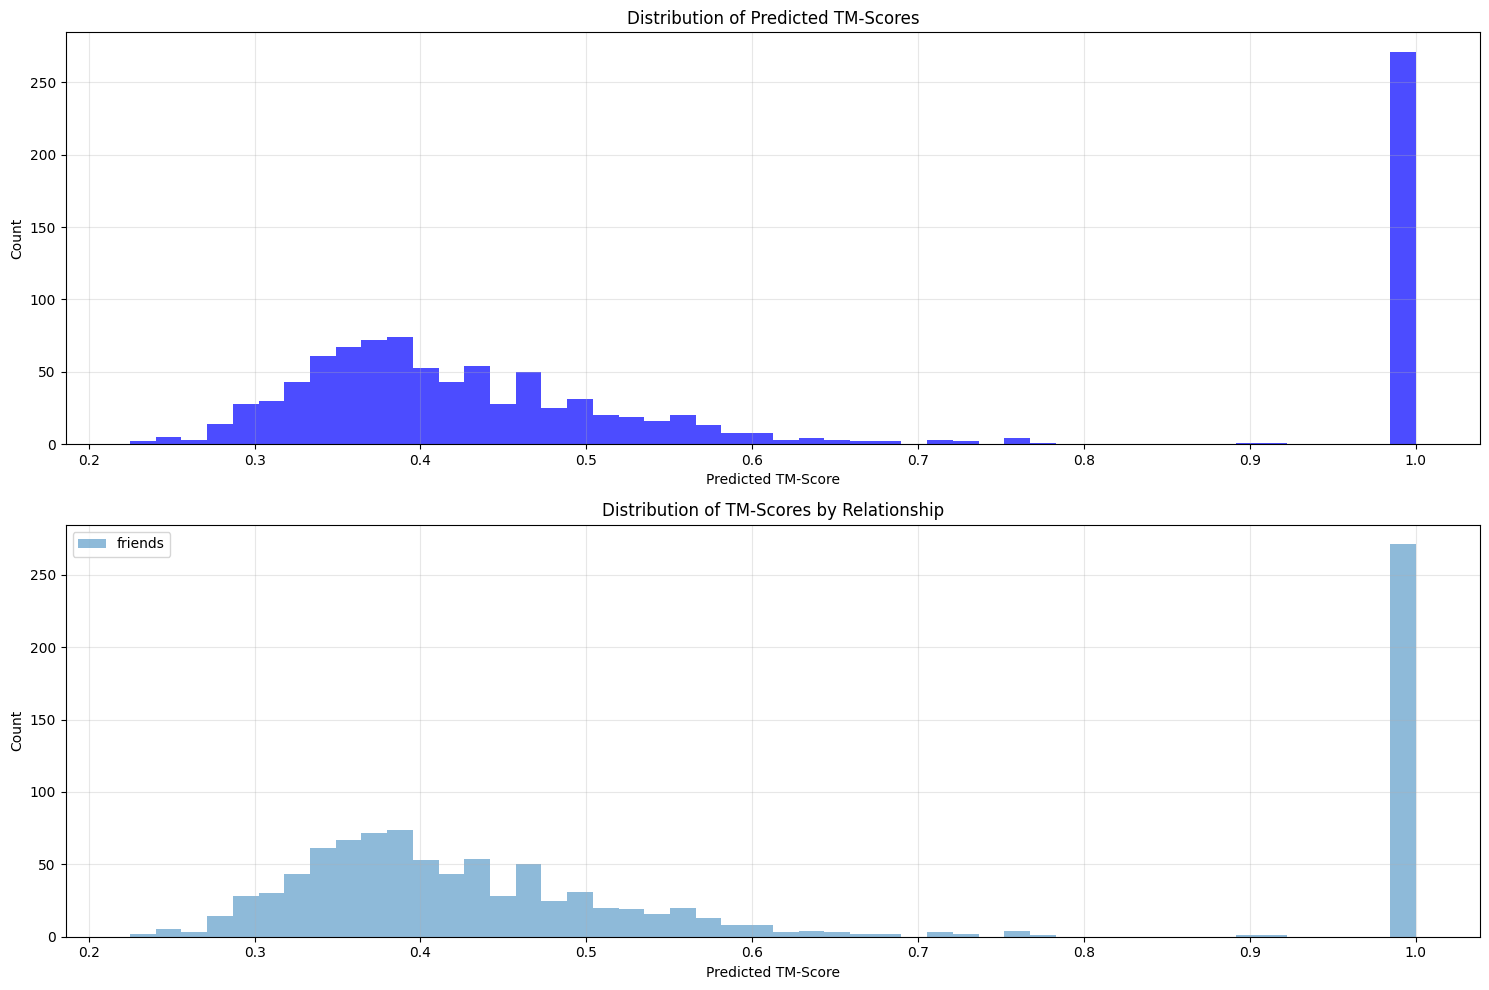


Summary Statistics of Predictions:
           Overall      Friends
count  1084.000000  1084.000000
mean      0.563170     0.563170
std       0.264974     0.264974
min       0.224871     0.224871
25%       0.368120     0.368120
50%       0.438635     0.438635
75%       0.933247     0.933247
max       1.000000     1.000000


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import time



# Load your CSV file
file_path = '/content/drive/MyDrive/MED4_ppi_translated_proteins_friends.csv'
pairs_df = pd.read_csv(file_path, names=['Sequence 1', 'Sequence 2', 'Relationship'])

print(f"Total number of sequence pairs: {len(pairs_df)}")
print("\nFirst few pairs:")
print(pairs_df.head())

# Validate sequences
print("\nValidating sequences...")
valid_chars = set('ACDEFGHIKLMNPQRSTVWY')
pairs_df['Valid_Sequence'] = pairs_df.apply(
    lambda row: all(c in valid_chars for c in row['Sequence 1']) and
                all(c in valid_chars for c in row['Sequence 2']), axis=1)

invalid_pairs = pairs_df[~pairs_df['Valid_Sequence']]
if len(invalid_pairs) > 0:
    print(f"\nWarning: Found {len(invalid_pairs)} pairs with invalid sequences")
    pairs_df = pairs_df[pairs_df['Valid_Sequence']]
    print(f"Proceeding with {len(pairs_df)} valid pairs")

# Now predict TM-Scores
tm_score_predictions = []
start_time = time.time()

try:
    for i in range(len(pairs_df)):
        sequence_1 = pairs_df.iloc[i]['Sequence 1']
        sequence_2 = pairs_df.iloc[i]['Sequence 2']

        sequence_1 = np.expand_dims(sequence_1, axis=0)
        sequence_2 = np.expand_dims(sequence_2, axis=0)

        # Featurize sequence 1 and 2 using ProtTrans
        protrans_sequence_1 = featurize_prottrans(sequence_1, model, tokenizer, device).detach()
        protrans_sequence_2 = featurize_prottrans(sequence_2, model, tokenizer, device).detach()

        # Embed sequence 1 and 2 using TM-Vec
        embedded_sequence_1 = embed_tm_vec(protrans_sequence_1, model_deep, device)
        embedded_sequence_2 = embed_tm_vec(protrans_sequence_2, model_deep, device)

        # Predict the TM-score
        predicted_tm_score = cosine_similarity_tm(torch.tensor(embedded_sequence_1),
                                                torch.tensor(embedded_sequence_2))

        tm_score_predictions.append(predicted_tm_score.numpy()[0])

        # Progress update with time estimation
        if i % 100 == 0 or i == len(pairs_df) - 1:
            elapsed_time = time.time() - start_time
            pairs_per_second = (i + 1) / elapsed_time
            remaining_pairs = len(pairs_df) - (i + 1)
            estimated_remaining_time = remaining_pairs / pairs_per_second

            print(f"Progress: {i+1}/{len(pairs_df)} pairs processed "
                  f"({(i+1)/len(pairs_df)*100:.1f}%)")
            print(f"Estimated time remaining: {estimated_remaining_time/60:.1f} minutes")

except Exception as e:
    print(f"\nError occurred at pair {i}: {str(e)}")
    # Save partial results if error occurs
    pairs_df = pairs_df.iloc[:len(tm_score_predictions)]

# Add predictions to dataframe
pairs_df['TM_Score_Prediction'] = np.array(tm_score_predictions)

# Save results
output_path = '/content/drive/MyDrive/MED4_ppi_translated_proteins_friends_results.csv'
pairs_df.to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")

# Create visualizations
plt.figure(figsize=(15, 10))

# Overall distribution
plt.subplot(2, 1, 1)
plt.hist(tm_score_predictions, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Predicted TM-Scores')
plt.xlabel('Predicted TM-Score')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

# Distribution by relationship
plt.subplot(2, 1, 2)
for relationship in pairs_df['Relationship'].unique():
    scores = pairs_df[pairs_df['Relationship'] == relationship]['TM_Score_Prediction']
    plt.hist(scores, bins=50, alpha=0.5, label=relationship)
plt.title('Distribution of TM-Scores by Relationship')
plt.xlabel('Predicted TM-Score')
plt.ylabel('Count')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics of Predictions:")
print(pd.DataFrame({
    'Overall': pairs_df['TM_Score_Prediction'].describe(),
    'Friends': pairs_df[pairs_df['Relationship'] == 'friends']['TM_Score_Prediction'].describe()
}))

/usr/local/lib/python3.10/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


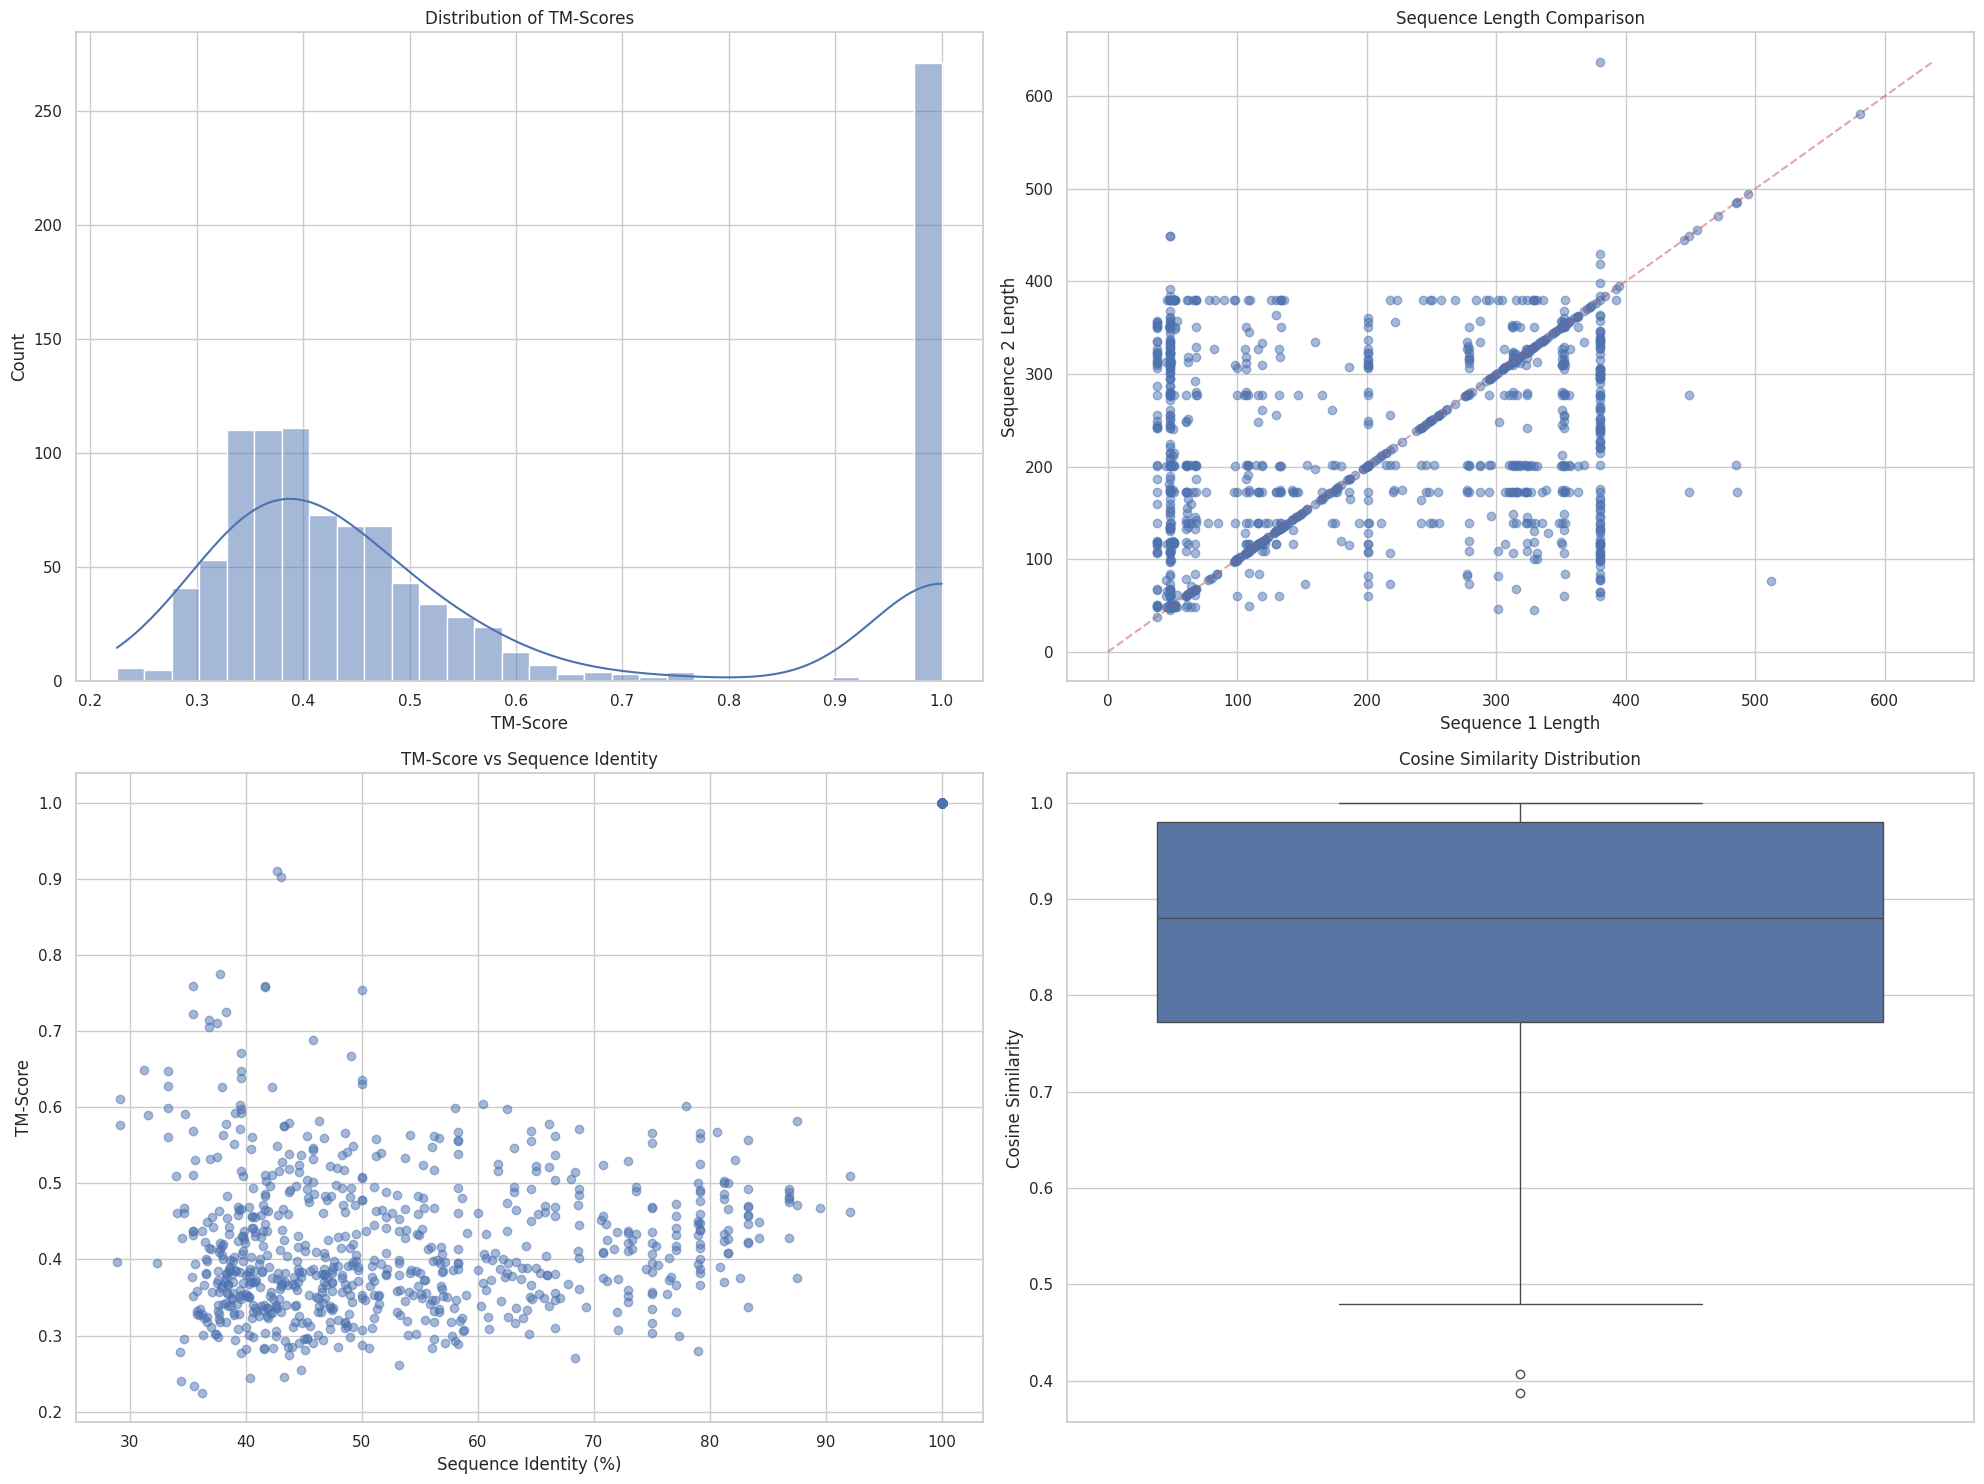


Statistical Summary:

TM-Score Statistics:
count    1084.000000
mean        0.563170
std         0.264974
min         0.224871
25%         0.368120
50%         0.438635
75%         0.933247
max         1.000000
Name: TM_Score_Prediction, dtype: float64

Sequence Length Statistics:
Average length difference: 98.10608856088561
Median length difference: 70.0

Cosine Similarity Statistics:
count    1084.000000
mean        0.860383
std         0.119828
min         0.387316
25%         0.772174
50%         0.880494
75%         0.979841
max         1.000000
dtype: float64

Correlation Matrix:
                   TM_Score  Length_Difference  Cosine_Similarity
TM_Score           1.000000          -0.560237           0.601987
Length_Difference -0.560237           1.000000          -0.542407
Cosine_Similarity  0.601987          -0.542407           1.000000


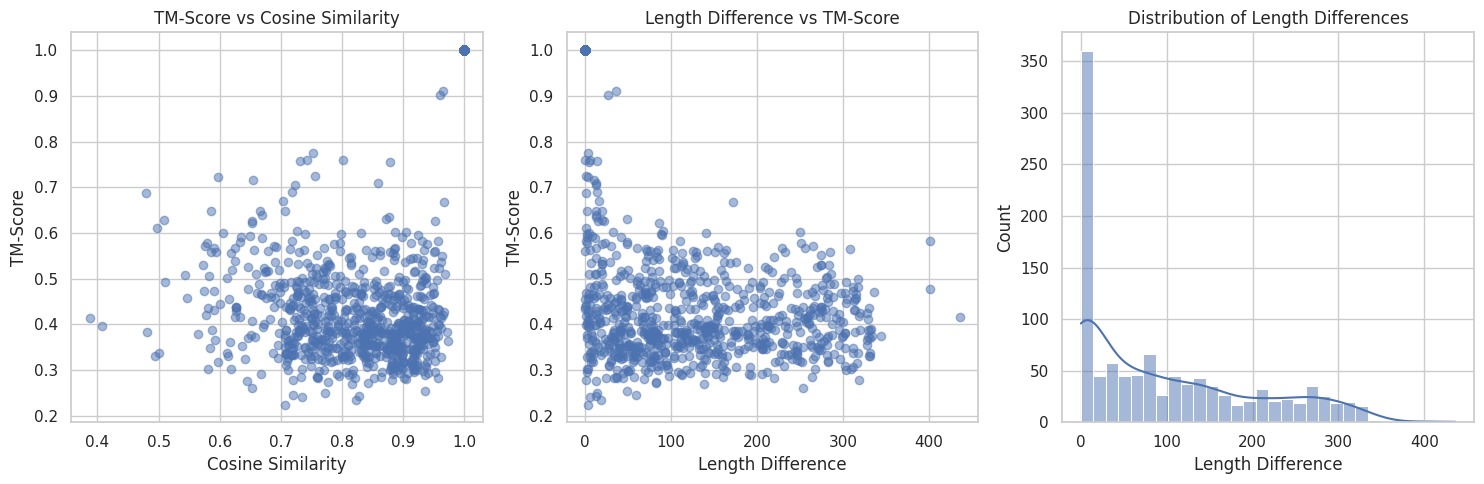

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import pairwise2
from Bio.Seq import Seq
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

# Load the data
df = pd.read_csv('/content/drive/MyDrive/MED4_ppi_translated_proteins_friends_results.csv')

# Calculate sequence lengths
df['Seq1_Length'] = df['Sequence 1'].str.len()
df['Seq2_Length'] = df['Sequence 2'].str.len()
df['Length_Difference'] = abs(df['Seq1_Length'] - df['Seq2_Length'])

# Function to calculate sequence identity
def calculate_sequence_identity(seq1, seq2):
    alignment = pairwise2.align.globalxx(seq1, seq2, one_alignment_only=True)[0]
    matches = sum(a == b for a, b in zip(alignment.seqA, alignment.seqB))
    return matches / min(len(seq1), len(seq2)) * 100

# Calculate sequence identity for a sample of pairs
sample_size = min(1000, len(df))  # To keep computation manageable
df_sample = df.sample(n=sample_size, random_state=42)
df_sample['Sequence_Identity'] = [calculate_sequence_identity(row['Sequence 1'], row['Sequence 2'])
                                 for _, row in df_sample.iterrows()]

# Create a figure with multiple subplots
plt.figure(figsize=(20, 15))

# 1. TM-Score Distribution
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='TM_Score_Prediction', bins=30, kde=True)
plt.title('Distribution of TM-Scores', fontsize=12)
plt.xlabel('TM-Score')
plt.ylabel('Count')

# 2. Sequence Length Comparison
plt.subplot(2, 2, 2)
plt.scatter(df['Seq1_Length'], df['Seq2_Length'], alpha=0.5)
plt.plot([0, max(df['Seq1_Length'].max(), df['Seq2_Length'].max())],
         [0, max(df['Seq1_Length'].max(), df['Seq2_Length'].max())],
         'r--', alpha=0.5)
plt.title('Sequence Length Comparison', fontsize=12)
plt.xlabel('Sequence 1 Length')
plt.ylabel('Sequence 2 Length')

# 3. TM-Score vs Sequence Identity
plt.subplot(2, 2, 3)
plt.scatter(df_sample['Sequence_Identity'], df_sample['TM_Score_Prediction'], alpha=0.5)
plt.title('TM-Score vs Sequence Identity', fontsize=12)
plt.xlabel('Sequence Identity (%)')
plt.ylabel('TM-Score')

# 4. Cosine Similarity Box Plot
# Convert sequences to numerical vectors (using amino acid frequencies)
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

def sequence_to_vector(seq):
    return [seq.count(aa)/len(seq) for aa in amino_acids]

vectors1 = np.array([sequence_to_vector(seq) for seq in df['Sequence 1']])
vectors2 = np.array([sequence_to_vector(seq) for seq in df['Sequence 2']])

cosine_similarities = [cosine_similarity(v1.reshape(1, -1), v2.reshape(1, -1))[0][0]
                      for v1, v2 in zip(vectors1, vectors2)]
df['Cosine_Similarity'] = cosine_similarities

plt.subplot(2, 2, 4)
sns.boxplot(y=df['Cosine_Similarity'])
plt.title('Cosine Similarity Distribution', fontsize=12)
plt.ylabel('Cosine Similarity')

plt.tight_layout()
plt.show()

# Additional Statistical Analysis
print("\nStatistical Summary:")
print("\nTM-Score Statistics:")
print(df['TM_Score_Prediction'].describe())

print("\nSequence Length Statistics:")
print("Average length difference:", df['Length_Difference'].mean())
print("Median length difference:", df['Length_Difference'].median())

print("\nCosine Similarity Statistics:")
print(pd.Series(cosine_similarities).describe())

# Correlation Analysis
correlation_matrix = pd.DataFrame({
    'TM_Score': df['TM_Score_Prediction'],
    'Length_Difference': df['Length_Difference'],
    'Cosine_Similarity': df['Cosine_Similarity']
}).corr()

print("\nCorrelation Matrix:")
print(correlation_matrix)

# Additional visualizations for interesting patterns
plt.figure(figsize=(15, 5))

# 1. TM-Score vs Cosine Similarity
plt.subplot(1, 3, 1)
plt.scatter(df['Cosine_Similarity'], df['TM_Score_Prediction'], alpha=0.5)
plt.title('TM-Score vs Cosine Similarity')
plt.xlabel('Cosine Similarity')
plt.ylabel('TM-Score')

# 2. Length Difference vs TM-Score
plt.subplot(1, 3, 2)
plt.scatter(df['Length_Difference'], df['TM_Score_Prediction'], alpha=0.5)
plt.title('Length Difference vs TM-Score')
plt.xlabel('Length Difference')
plt.ylabel('TM-Score')

# 3. Length Difference Distribution
plt.subplot(1, 3, 3)
sns.histplot(data=df, x='Length_Difference', bins=30, kde=True)
plt.title('Distribution of Length Differences')
plt.xlabel('Length Difference')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Calculating sequence features...
Calculating UMAP projection...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Calculating t-SNE projection...
Creating visualizations...


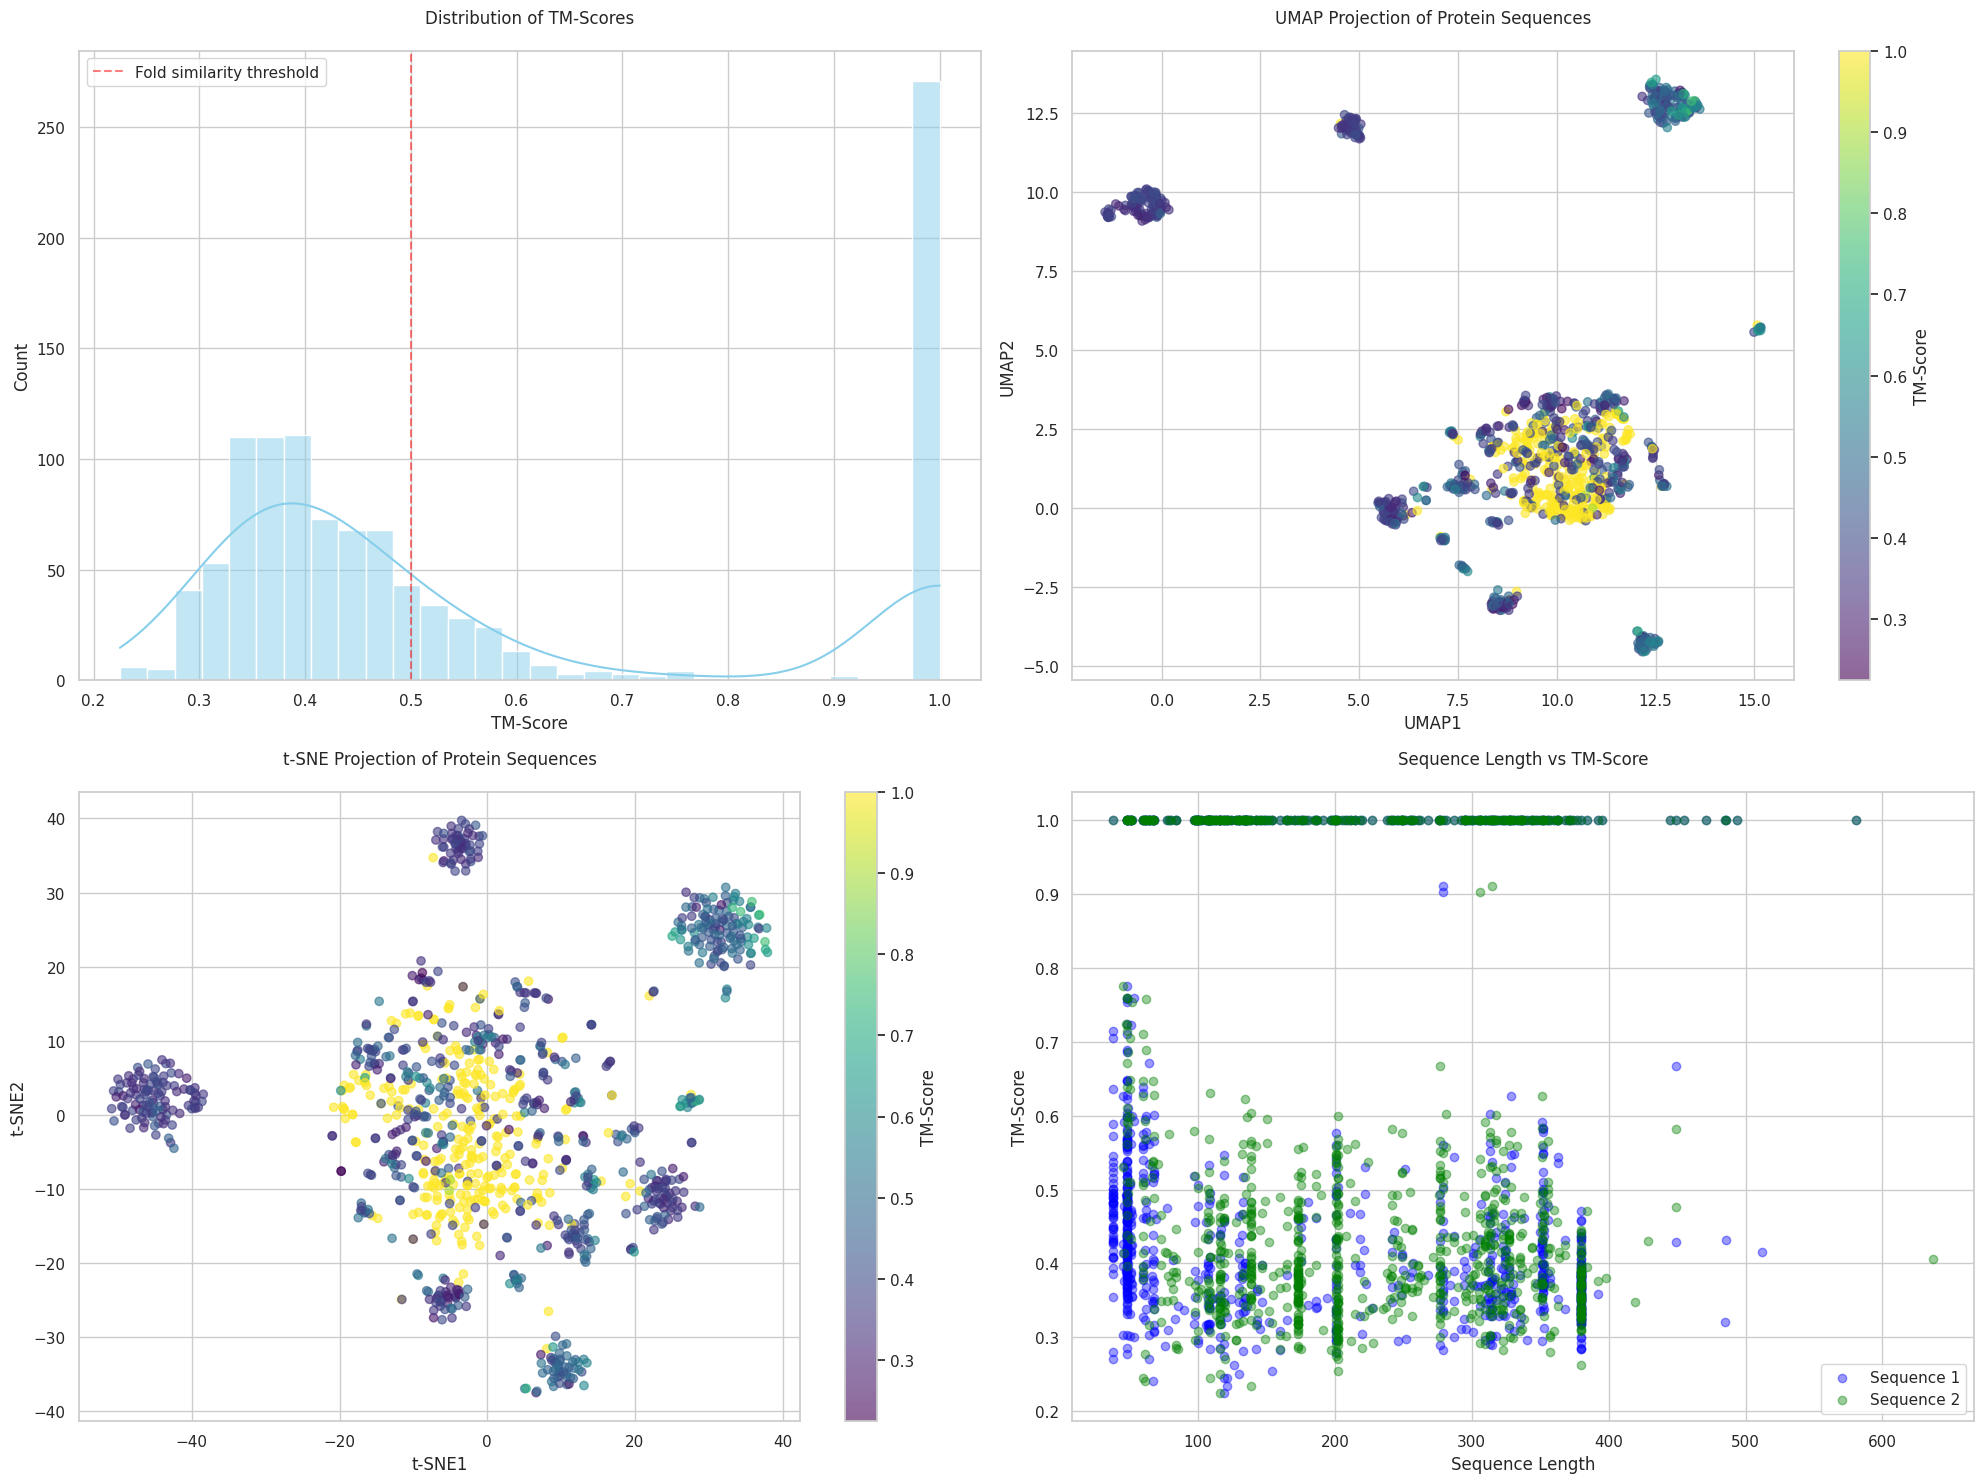


Statistical Summary:

TM-Score Statistics:
count    1084.000000
mean        0.563170
std         0.264974
min         0.224871
25%         0.368120
50%         0.438635
75%         0.933247
max         1.000000
Name: TM_Score_Prediction, dtype: float64

Length Difference Statistics:
count    1084.000000
mean       98.106089
std       101.672436
min         0.000000
25%         0.000000
50%        70.000000
75%       162.000000
max       436.000000
Name: Length_Difference, dtype: float64

Correlation Analysis:
Length_Difference vs TM-Score: correlation = -0.560, p-value = 1.358e-90
Seq1_Length vs TM-Score: correlation = -0.016, p-value = 5.956e-01
Seq2_Length vs TM-Score: correlation = -0.094, p-value = 2.020e-03


In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import pairwise2
from Bio.Seq import Seq
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
import umap
from sklearn.preprocessing import StandardScaler

# Set seaborn style directly
sns.set_theme(style="whitegrid")

# Set random seed for reproducibility
np.random.seed(42)

# Load the data
df = pd.read_csv('/content/drive/MyDrive/MED4_ppi_translated_proteins_friends_results.csv')

# Calculate sequence properties
df['Seq1_Length'] = df['Sequence 1'].str.len()
df['Seq2_Length'] = df['Sequence 2'].str.len()
df['Length_Difference'] = abs(df['Seq1_Length'] - df['Seq2_Length'])

# Function to calculate amino acid composition
def get_aa_composition(sequence):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    return [sequence.count(aa)/len(sequence) for aa in amino_acids]

# Calculate features for dimensionality reduction
print("Calculating sequence features...")
features_seq1 = np.array([get_aa_composition(seq) for seq in df['Sequence 1']])
features_seq2 = np.array([get_aa_composition(seq) for seq in df['Sequence 2']])
features_combined = np.concatenate([features_seq1, features_seq2], axis=1)

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_combined)

# Calculate UMAP embedding
print("Calculating UMAP projection...")
umap_reducer = umap.UMAP(random_state=42)
umap_embedding = umap_reducer.fit_transform(features_scaled)

# Calculate t-SNE embedding
print("Calculating t-SNE projection...")
tsne = TSNE(n_components=2, random_state=42)
tsne_embedding = tsne.fit_transform(features_scaled)

# Create visualizations
print("Creating visualizations...")

# Figure 1: Main Analysis
plt.figure(figsize=(20, 15))

# 1. Enhanced TM-Score Distribution
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='TM_Score_Prediction', bins=30, kde=True, color='skyblue')
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Fold similarity threshold')
plt.title('Distribution of TM-Scores', fontsize=12, pad=20)
plt.xlabel('TM-Score')
plt.ylabel('Count')
plt.legend()

# 2. UMAP Visualization
plt.subplot(2, 2, 2)
scatter = plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1],
                     c=df['TM_Score_Prediction'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='TM-Score')
plt.title('UMAP Projection of Protein Sequences', fontsize=12, pad=20)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# 3. t-SNE Visualization
plt.subplot(2, 2, 3)
scatter = plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1],
                     c=df['TM_Score_Prediction'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='TM-Score')
plt.title('t-SNE Projection of Protein Sequences', fontsize=12, pad=20)
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

# 4. Sequence Length vs TM-Score
plt.subplot(2, 2, 4)
plt.scatter(df['Seq1_Length'], df['TM_Score_Prediction'], alpha=0.4,
           label='Sequence 1', color='blue')
plt.scatter(df['Seq2_Length'], df['TM_Score_Prediction'], alpha=0.4,
           label='Sequence 2', color='green')
plt.title('Sequence Length vs TM-Score', fontsize=12, pad=20)
plt.xlabel('Sequence Length')
plt.ylabel('TM-Score')
plt.legend()

plt.tight_layout()
plt.show()

# Print Statistical Summary
print("\nStatistical Summary:")
print("\nTM-Score Statistics:")
print(df['TM_Score_Prediction'].describe())

print("\nLength Difference Statistics:")
print(df['Length_Difference'].describe())

# Calculate and print correlation statistics
correlations = {
    'Length_Difference vs TM-Score': stats.pearsonr(df['Length_Difference'],
                                                   df['TM_Score_Prediction']),
    'Seq1_Length vs TM-Score': stats.pearsonr(df['Seq1_Length'],
                                             df['TM_Score_Prediction']),
    'Seq2_Length vs TM-Score': stats.pearsonr(df['Seq2_Length'],
                                             df['TM_Score_Prediction'])
}

print("\nCorrelation Analysis:")
for key, (corr, p_value) in correlations.items():
    print(f"{key}: correlation = {corr:.3f}, p-value = {p_value:.3e}")

# Additional figures will be created based on your needs...

Calculating protein features...


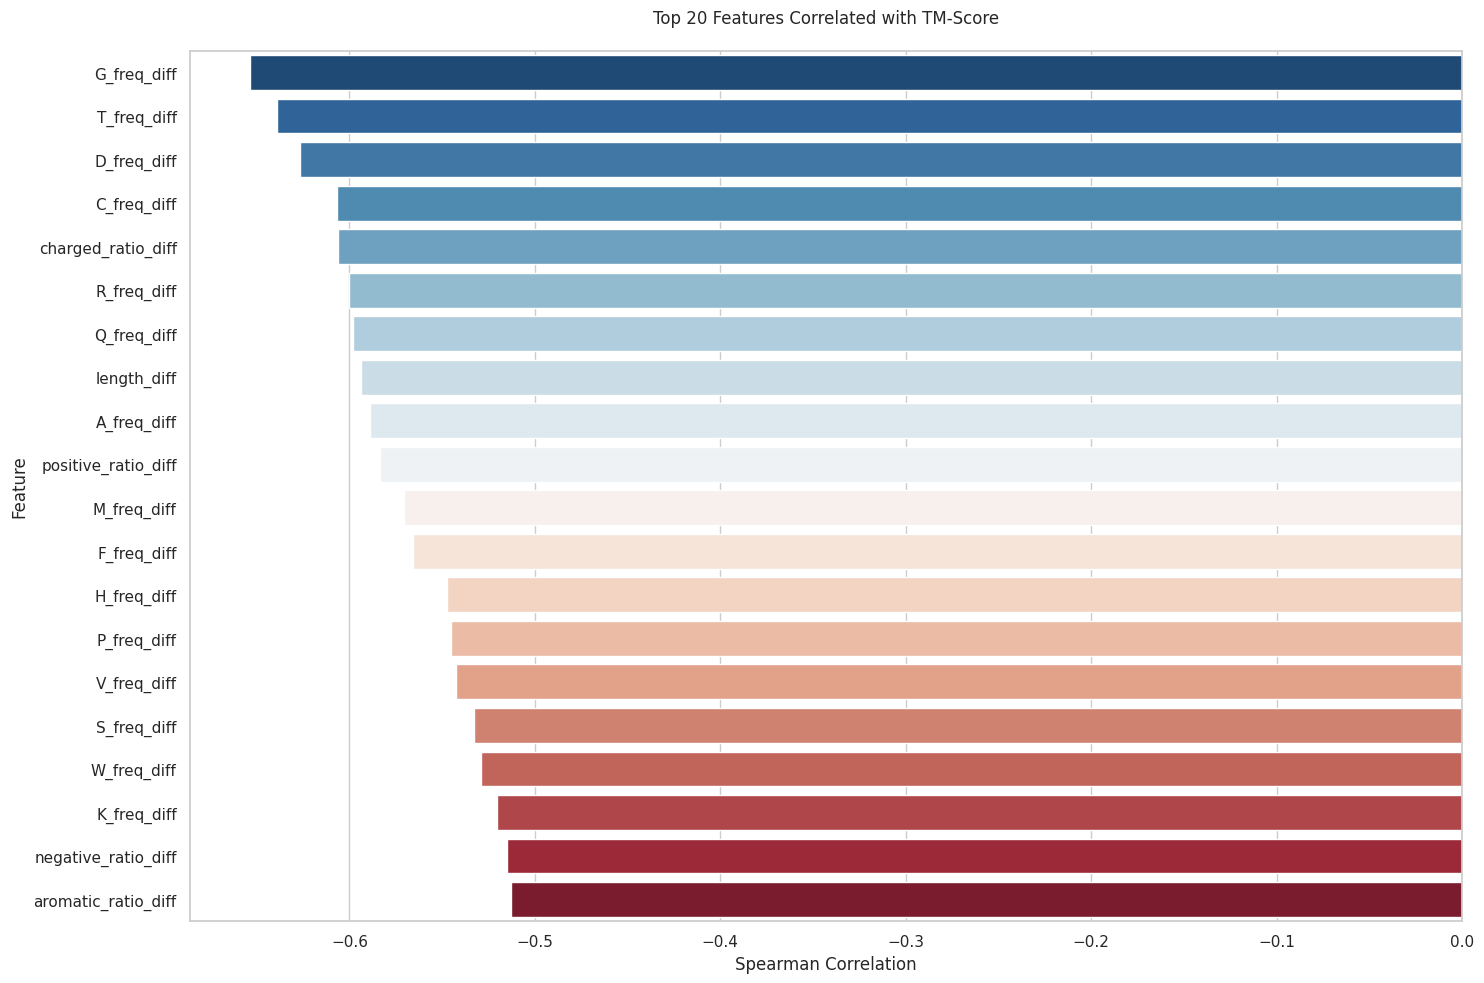

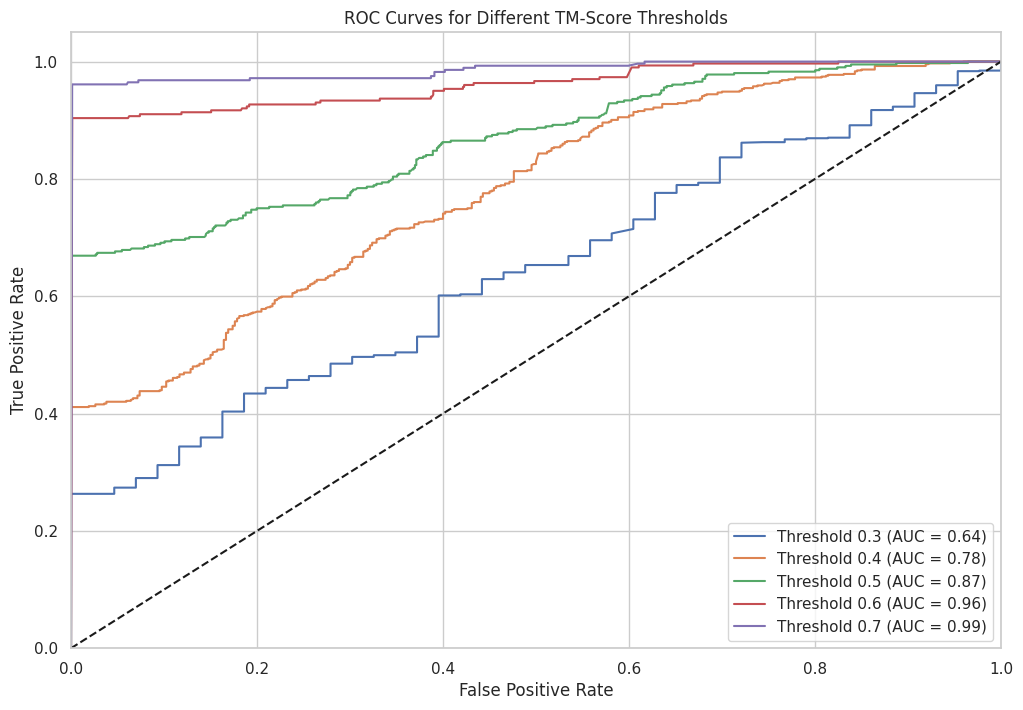


Top 20 Features Correlated with TM-Score:
            Feature  Correlation       P-value
        G_freq_diff    -0.653420 5.598339e-133
        T_freq_diff    -0.639200 1.499058e-125
        D_freq_diff    -0.626538 2.926736e-119
        C_freq_diff    -0.606877 4.757301e-110
 charged_ratio_diff    -0.606340 8.317143e-110
        R_freq_diff    -0.600506 3.356885e-107
        Q_freq_diff    -0.598184 3.530655e-106
        length_diff    -0.593902 2.577725e-104
        A_freq_diff    -0.588910 3.536062e-102
positive_ratio_diff    -0.583597 6.061514e-100
        M_freq_diff    -0.570690  1.100690e-94
        F_freq_diff    -0.565580  1.148016e-92
        H_freq_diff    -0.547266  1.026916e-85
        P_freq_diff    -0.545067  6.569679e-85
        V_freq_diff    -0.542670  4.887309e-84
        S_freq_diff    -0.532700  1.741244e-80
        W_freq_diff    -0.529152  2.995343e-79
        K_freq_diff    -0.520614  2.454929e-76
negative_ratio_diff    -0.514866  2.021214e-74
aromatic_ratio_di

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('/content/drive/MyDrive/MED4_ppi_translated_proteins_friends_results.csv')

# Function to calculate protein features
def calculate_protein_features(sequence):
    # Amino acid properties
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    hydrophobic = 'AILMFWYV'
    polar = 'QNSTCH'
    charged = 'DEKR'
    positive = 'KRH'
    negative = 'DE'
    aromatic = 'FWY'

    features = {}
    # Basic composition features
    features['length'] = len(sequence)
    for aa in amino_acids:
        features[f'{aa}_freq'] = sequence.count(aa) / len(sequence)

    # Physicochemical features
    features['hydrophobic_ratio'] = sum(sequence.count(aa) for aa in hydrophobic) / len(sequence)
    features['polar_ratio'] = sum(sequence.count(aa) for aa in polar) / len(sequence)
    features['charged_ratio'] = sum(sequence.count(aa) for aa in charged) / len(sequence)
    features['positive_ratio'] = sum(sequence.count(aa) for aa in positive) / len(sequence)
    features['negative_ratio'] = sum(sequence.count(aa) for aa in negative) / len(sequence)
    features['aromatic_ratio'] = sum(sequence.count(aa) for aa in aromatic) / len(sequence)

    return features

# Calculate features for both sequences
print("Calculating protein features...")
features_list1 = []
features_list2 = []
for _, row in df.iterrows():
    features1 = calculate_protein_features(row['Sequence 1'])
    features2 = calculate_protein_features(row['Sequence 2'])
    features_list1.append(features1)
    features_list2.append(features2)

# Convert to dataframes
features_df1 = pd.DataFrame(features_list1)
features_df2 = pd.DataFrame(features_list2)

# Calculate feature differences
feature_diff_df = abs(features_df1 - features_df2)
feature_diff_df.columns = [f'{col}_diff' for col in feature_diff_df.columns]

# Combine features with TM-scores
analysis_df = pd.concat([feature_diff_df, df['TM_Score_Prediction']], axis=1)

# Calculate correlations with TM-score
correlations = []
for column in feature_diff_df.columns:
    correlation, p_value = spearmanr(feature_diff_df[column], df['TM_Score_Prediction'])
    correlations.append({
        'Feature': column,
        'Correlation': correlation,
        'P-value': p_value
    })

correlation_df = pd.DataFrame(correlations)
correlation_df = correlation_df.sort_values('Correlation', key=abs, ascending=False)

# Plot top 20 feature correlations
plt.figure(figsize=(15, 10))
sns.barplot(data=correlation_df.head(20),
            y='Feature',
            x='Correlation',
            palette='RdBu_r')
plt.title('Top 20 Features Correlated with TM-Score', pad=20)
plt.xlabel('Spearman Correlation')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# ROC Curve Analysis
# Create binary labels based on TM-score threshold
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
plt.figure(figsize=(12, 8))

for threshold in thresholds:
    binary_labels = (df['TM_Score_Prediction'] >= threshold).astype(int)

    # Use one of the most correlated features for ROC analysis
    top_feature = correlation_df.iloc[0]['Feature']
    feature_values = feature_diff_df[top_feature]

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(binary_labels, -feature_values)  # Negative because we want to detect similarity
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Threshold {threshold} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different TM-Score Thresholds')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print top 20 correlated features with statistics
print("\nTop 20 Features Correlated with TM-Score:")
print(correlation_df.head(20).to_string(index=False))

# Additional statistical analysis
print("\nFeature Analysis Summary:")
for feature in correlation_df.head(5)['Feature']:
    feature_values = feature_diff_df[feature]
    print(f"\n{feature}:")
    print("Statistical Summary:")
    print(feature_values.describe())
    print(f"Correlation with TM-Score: {spearmanr(feature_values, df['TM_Score_Prediction'])[0]:.3f}")

In [ ]:
#Calculating shared sequences between both########

In [ ]:
import pandas as pd

#Calculating shared sequences between both
# Load both CSV files
results_df_100k = pd.read_csv('/content/drive/MyDrive/tm_score_predictions_MED4_100k_sample_results.csv')
results_df_friends = pd.read_csv('/content/drive/MyDrive/MED4_ppi_translated_proteins_friends_results.csv')

# Create sets of sequences from both files
sequences_100k = set(results_df_100k['Sequence 1'].tolist() + results_df_100k['Sequence 2'].tolist())
sequences_friends = set(results_df_friends['Sequence 1'].tolist() + results_df_friends['Sequence 2'].tolist())

# Find shared sequences
shared_sequences = sequences_100k.intersection(sequences_friends)

print(f"Number of unique sequences in 100k sample: {len(sequences_100k)}")
print(f"Number of unique sequences in friends dataset: {len(sequences_friends)}")
print(f"Number of shared sequences: {len(shared_sequences)}")

# If there are shared sequences, display them and their TM-scores in both datasets
if len(shared_sequences) > 0:
    print("\nShared sequences and their TM-scores:")
    for seq in shared_sequences:
        print("\nSequence:", seq[:50] + "..." if len(seq) > 50 else seq)

        # Find TM-scores in 100k dataset
        scores_100k = results_df_100k[
            (results_df_100k['Sequence 1'] == seq) |
            (results_df_100k['Sequence 2'] == seq)
        ]['TM_Score_Prediction'].tolist()

        # Find TM-scores in friends dataset
        scores_friends = results_df_friends[
            (results_df_friends['Sequence 1'] == seq) |
            (results_df_friends['Sequence 2'] == seq)
        ]['TM_Score_Prediction'].tolist()

        print("TM-scores in 100k dataset:", scores_100k)
        print("TM-scores in friends dataset:", scores_friends)
else:
    print("\nNo shared sequences found between the datasets")

Number of unique sequences in 100k sample: 1954
Number of unique sequences in friends dataset: 428
Number of shared sequences: 428

Shared sequences and their TM-scores:

Sequence: MPFLSSKEGEDNTLPRNISLSFLFIDFLLIVGVLFQKFDTTNSSLQLIER...
TM-scores in 100k dataset: [0.39793098, 0.4194726, 0.6546247, 0.48195246, 0.572758, 0.4613976, 0.37556678, 0.37589374, 0.58168244, 0.39688322, 0.39873135, 0.52979827, 0.40134352, 0.4396532, 0.5037644, 0.5505396, 0.36939263, 0.38534862, 0.6034495, 0.6182717, 0.655885, 0.3585334, 0.35140285, 0.37594703, 0.3137198, 0.39439428, 0.6317273, 0.45906624, 0.5957367, 0.4767922, 0.6740069, 0.3092334, 0.6207262, 0.33470392, 0.7551591, 0.48846588, 0.41087478, 0.40010855, 0.38309336, 0.3918109, 0.3916387, 0.4926897, 0.56352276, 0.35540348, 0.34070164, 0.38538203, 0.81864023, 0.40670767, 0.3322937, 0.3871463, 0.36867785, 0.3265258, 0.31385377, 0.3504331, 0.61572343, 0.46734038, 0.48459205, 0.29598093, 0.37104875, 0.53388494, 0.6508541, 0.5935749, 0.40283972, 0.38841942,

In [ ]:
#Comprehensive visualizations to help compare the datasets and their TM-scores.

<ipython-input-23-495a92059d7c>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Dataset', y='TM-Score', data=data_to_plot, palette=[colors[0], colors[1]])


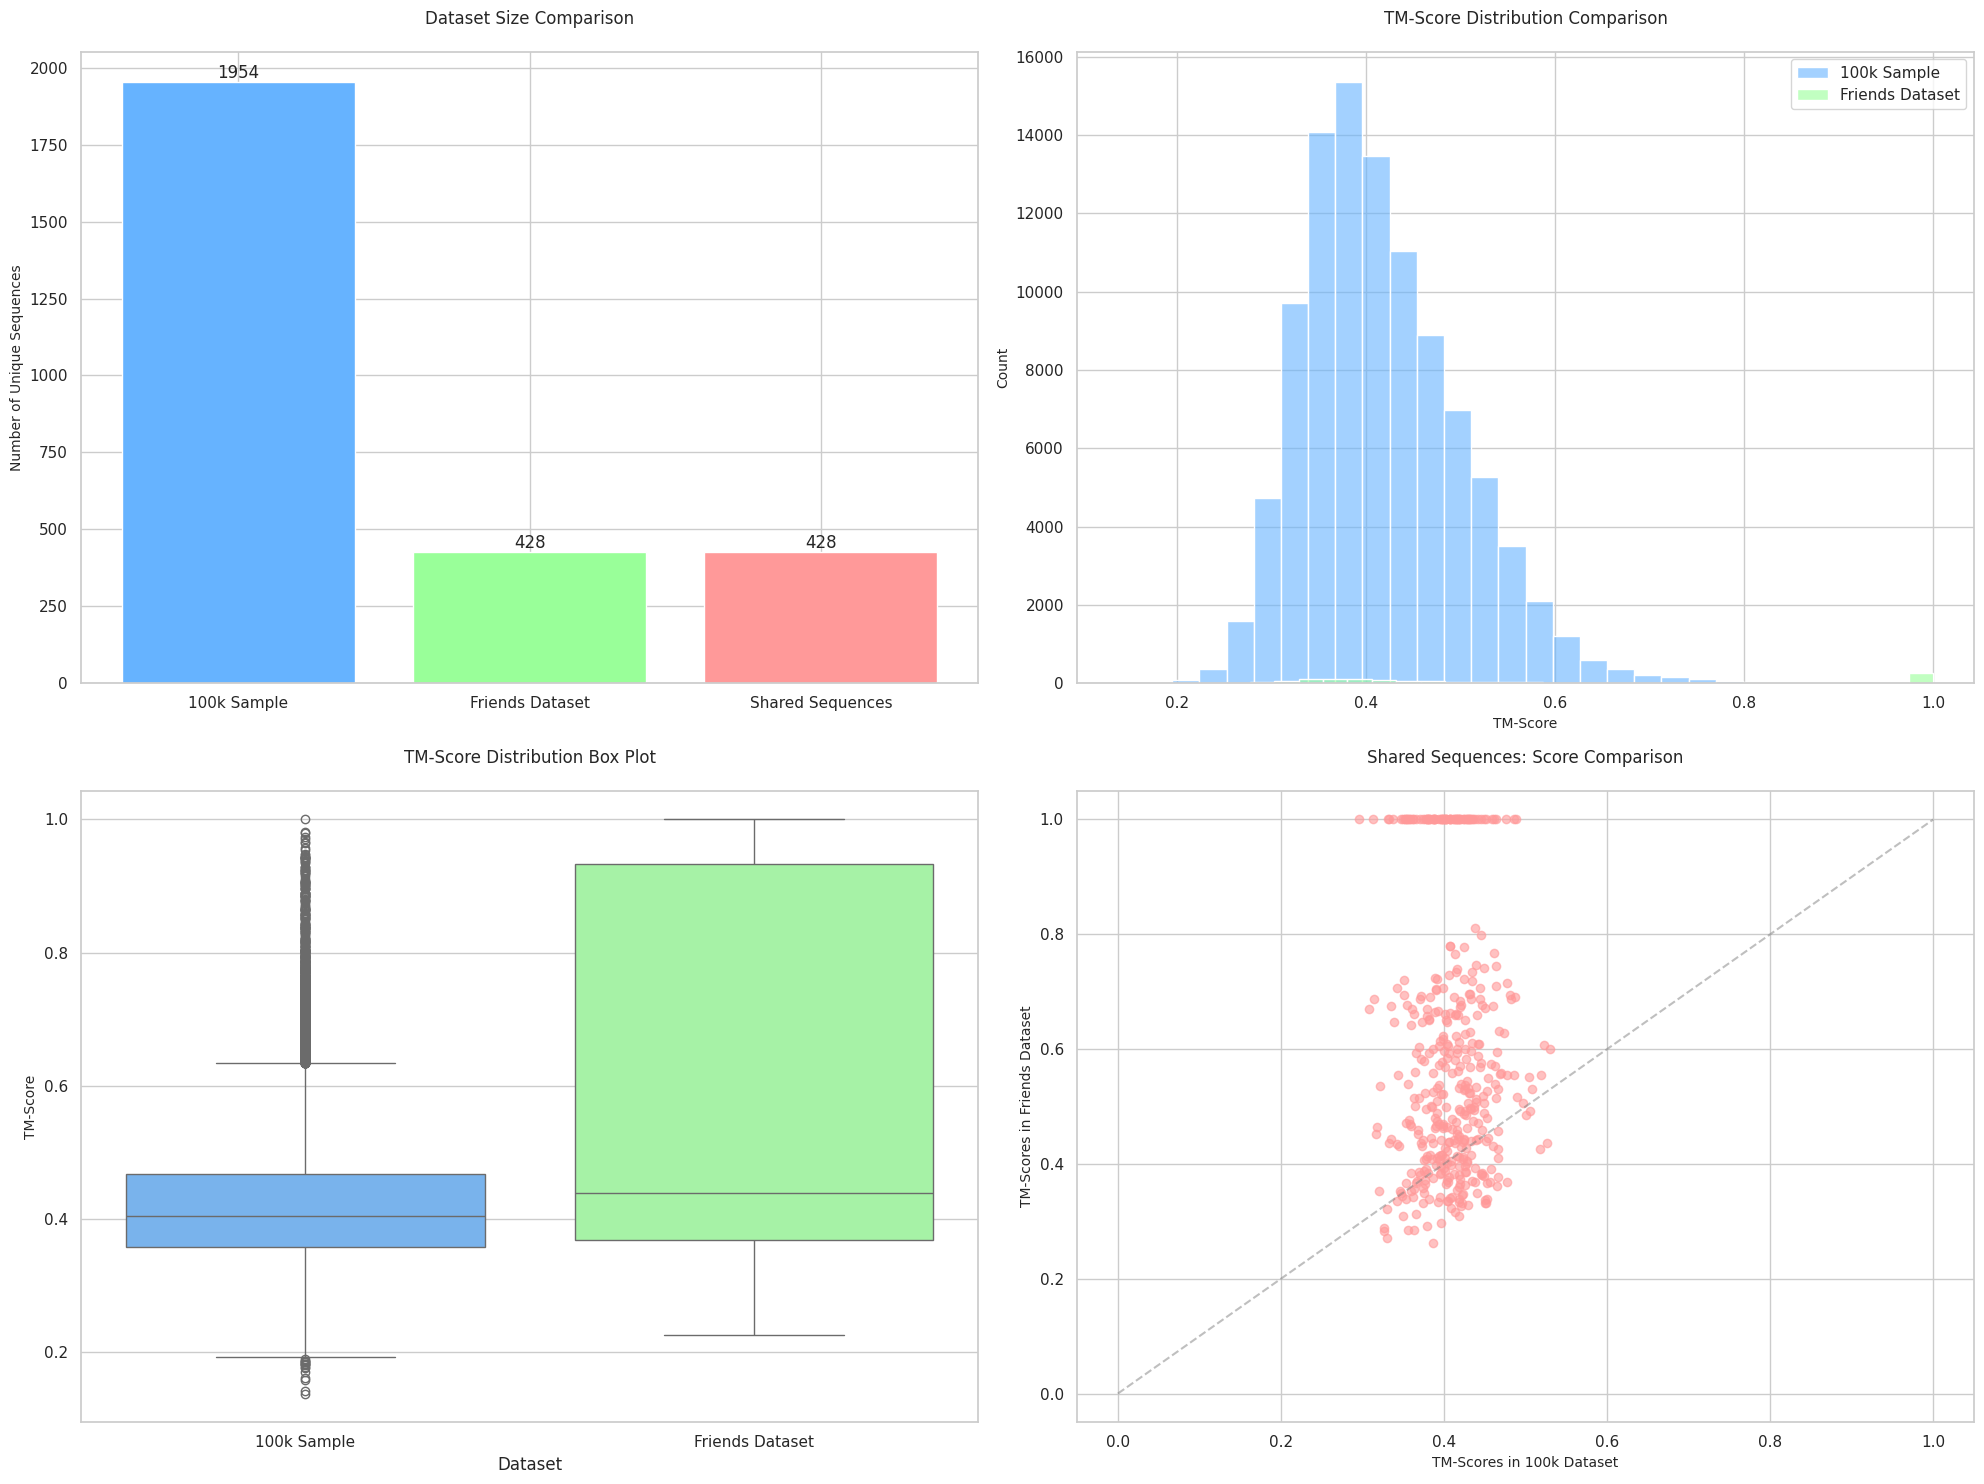


Statistical Summary:

100k Sample Dataset:
count    100000.000000
mean          0.417092
std           0.084691
min           0.136980
25%           0.356586
50%           0.404123
75%           0.467386
max           1.000000
Name: TM_Score_Prediction, dtype: float64

Friends Dataset:
count    1084.000000
mean        0.563170
std         0.264974
min         0.224871
25%         0.368120
50%         0.438635
75%         0.933247
max         1.000000
Name: TM_Score_Prediction, dtype: float64

Shared Sequences Analysis:
Number of shared sequences: 428

Example shared sequences (first 3):

Sequence: MPFLSSKEGEDNTLPRNISLSFLFIDFLLIVGVLFQKFDTTNSSLQLIER...
Average TM-score in 100k dataset: 0.47561910278260866
Average TM-score in friends dataset: 0.9999999

Sequence: MDSYKQIVEKAELALIKGEYNFCIEYLYPIIESYPPSSKEGANLRTILIT...
Average TM-score in 100k dataset: 0.39870003086538464
Average TM-score in friends dataset: 0.5211281019999999

Sequence: LKSKLQQTLEKNSKVITAELMPPRGGDPVRSLKIAQLLRNKVHAVNITDG...

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# First import and set seaborn
sns.set_theme(style="whitegrid")

# Load both CSV files
results_df_100k = pd.read_csv('/content/drive/MyDrive/tm_score_predictions_MED4_100k_sample_results.csv')
results_df_friends = pd.read_csv('/content/drive/MyDrive/MED4_ppi_translated_proteins_friends_results.csv')

# Create sets of sequences from both files
sequences_100k = set(results_df_100k['Sequence 1'].tolist() + results_df_100k['Sequence 2'].tolist())
sequences_friends = set(results_df_friends['Sequence 1'].tolist() + results_df_friends['Sequence 2'].tolist())

# Find shared sequences
shared_sequences = sequences_100k.intersection(sequences_friends)

# Create a figure with multiple subplots
plt.figure(figsize=(20, 15))

# 1. Dataset Size Comparison
plt.subplot(2, 2, 1)
sizes = [len(sequences_100k), len(sequences_friends), len(shared_sequences)]
labels = ['100k Sample', 'Friends Dataset', 'Shared Sequences']
colors = ['#66b3ff', '#99ff99', '#ff9999']
plt.bar(labels, sizes, color=colors)
plt.title('Dataset Size Comparison', fontsize=12, pad=20)
plt.ylabel('Number of Unique Sequences', fontsize=10)
for i, v in enumerate(sizes):
    plt.text(i, v, str(v), ha='center', va='bottom')

# 2. TM-Score Distributions
plt.subplot(2, 2, 2)
sns.histplot(data=results_df_100k, x='TM_Score_Prediction', label='100k Sample',
             alpha=0.6, color='#66b3ff', bins=30)
sns.histplot(data=results_df_friends, x='TM_Score_Prediction', label='Friends Dataset',
             alpha=0.6, color='#99ff99', bins=30)
plt.title('TM-Score Distribution Comparison', fontsize=12, pad=20)
plt.xlabel('TM-Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.legend()

# 3. Box Plot Comparison
plt.subplot(2, 2, 3)
data_to_plot = pd.concat([
    pd.DataFrame({'Dataset': '100k Sample', 'TM-Score': results_df_100k['TM_Score_Prediction']}),
    pd.DataFrame({'Dataset': 'Friends Dataset', 'TM-Score': results_df_friends['TM_Score_Prediction']})
])
sns.boxplot(x='Dataset', y='TM-Score', data=data_to_plot, palette=[colors[0], colors[1]])
plt.title('TM-Score Distribution Box Plot', fontsize=12, pad=20)
plt.ylabel('TM-Score', fontsize=10)

# 4. Shared Sequences Analysis (if any)
plt.subplot(2, 2, 4)
if len(shared_sequences) > 0:
    shared_scores_100k = []
    shared_scores_friends = []

    for seq in shared_sequences:
        # Get scores from 100k dataset
        scores_100k = results_df_100k[
            (results_df_100k['Sequence 1'] == seq) |
            (results_df_100k['Sequence 2'] == seq)
        ]['TM_Score_Prediction'].mean()

        # Get scores from friends dataset
        scores_friends = results_df_friends[
            (results_df_friends['Sequence 1'] == seq) |
            (results_df_friends['Sequence 2'] == seq)
        ]['TM_Score_Prediction'].mean()

        shared_scores_100k.append(scores_100k)
        shared_scores_friends.append(scores_friends)

    plt.scatter(shared_scores_100k, shared_scores_friends, alpha=0.6, color='#ff9999')
    plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5)  # diagonal line
    plt.xlabel('TM-Scores in 100k Dataset', fontsize=10)
    plt.ylabel('TM-Scores in Friends Dataset', fontsize=10)
    plt.title('Shared Sequences: Score Comparison', fontsize=12, pad=20)
else:
    plt.text(0.5, 0.5, 'No shared sequences found',
             horizontalalignment='center', verticalalignment='center')

plt.tight_layout()
plt.show()

# Print statistical summary
print("\nStatistical Summary:")
print("\n100k Sample Dataset:")
print(results_df_100k['TM_Score_Prediction'].describe())
print("\nFriends Dataset:")
print(results_df_friends['TM_Score_Prediction'].describe())

# If there are shared sequences, show detailed comparison
if len(shared_sequences) > 0:
    print("\nShared Sequences Analysis:")
    print(f"Number of shared sequences: {len(shared_sequences)}")
    print("\nExample shared sequences (first 3):")
    for seq in list(shared_sequences)[:3]:
        print(f"\nSequence: {seq[:50]}...")
        print("Average TM-score in 100k dataset:",
              results_df_100k[
                  (results_df_100k['Sequence 1'] == seq) |
                  (results_df_100k['Sequence 2'] == seq)
              ]['TM_Score_Prediction'].mean())
        print("Average TM-score in friends dataset:",
              results_df_friends[
                  (results_df_friends['Sequence 1'] == seq) |
                  (results_df_friends['Sequence 2'] == seq)
              ]['TM_Score_Prediction'].mean())

In [ ]:
#now comparing scores between MED4 AND NATL1A

In [ ]:
# Load and examine the files
natl1a_path = '/content/drive/MyDrive/NATL1A_translated_proteins_no_stops.csv'
med4_path = '/content/drive/MyDrive/translated_proteins_MED4_no_stops.csv'

# Read and check NATL1A file structure
natl1a_df = pd.read_csv(natl1a_path, sep='\t')
print("NATL1A DataFrame columns:")
print(natl1a_df.columns)
print("\nFirst few rows of NATL1A:")
print(natl1a_df.head())

# Read and check MED4 file structure
med4_df = pd.read_csv(med4_path, sep='\t')
print("\nMED4 DataFrame columns:")
print(med4_df.columns)
print("\nFirst few rows of MED4:")
print(med4_df.head())

NATL1A DataFrame columns:
Index([' ABM74737 ,MGILFYLVFVGAGLSAAFLIQKALKAIKLI'], dtype='object')

First few rows of NATL1A:
    ABM74737 ,MGILFYLVFVGAGLSAAFLIQKALKAIKLI
0   ABM74829 ,MAAILPWPGETAVAIAAIVSSVGENEFINQ
1   ABM75094 ,LSFQKKEDQRKDSLFSKKVKTSKFASLLMI
2   ABM76009 ,MIKNYPLLPFLIFAGALVSTATIGLPVFAG
3   ABM76249 ,MTVLLWGVFLLGGIGLFVVWGLSNAYPTIN
4   ABM76436 ,LIVALFGIALFAVSARIWLPGDMLAPAPIN

MED4 DataFrame columns:
Index(['ORF_ID,Protein_Sequence'], dtype='object')

First few rows of MED4:
                     ORF_ID,Protein_Sequence
0         CAP16404,MATLIPLAVVALAGPAIIALVFFRK
1     CAX37112,MPLDVFLINMCVVVLGLLVRREIKLRKAR
2   CAP16326,MDFINKNKILTVMAVIAILSFLLEKTGIIHP
3   CAP16521,LYGTAFTAKLKITSLKPCILIKRCQSLAARI
4  CAE18773,MEAFAYVLILTLAVVTLFFAVAFRDPPKFDRK


In [ ]:
#!pip install tm-vec
#!pip install -q SentencePiece transformers
#!pip install faiss-gpu
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from tm_vec.embed_structure_model import trans_basic_block, trans_basic_block_Config
from tm_vec.tm_vec_utils import featurize_prottrans, embed_tm_vec, cosine_similarity_tm
import matplotlib.pyplot as plt
import seaborn as sns
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
gc.collect()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
model = model.eval()
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model.ckpt
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model_params.json
#TM-Vec model paths
tm_vec_model_cpnt = "/content/drive/MyDrive/tm_vec_cath_model.ckpt"
tm_vec_model_config = "/content/drive/MyDrive/tm_vec_cath_model_params.json"
#Load the TM-Vec model
tm_vec_model_config = trans_basic_block_Config.from_json(tm_vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(tm_vec_model_cpnt, config=tm_vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

cpu
--2025-01-08 00:10:17--  https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model.ckpt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 158.106.193.205
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|158.106.193.205|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /~thamamsy/tm_vec_cath_model.ckpt [following]
--2025-01-08 00:10:17--  https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model.ckpt
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 403 Forbidden
2025-01-08 00:10:17 ERROR 403: Forbidden.

--2025-01-08 00:10:17--  https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model_params.json
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 158.106.193.205
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|158.106.193.205|:443... connected.
HTTP request sent, a

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/tm_vec_cath_model_params.json'

In [23]:
# Import necessary libraries
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from tm_vec.embed_structure_model import trans_basic_block, trans_basic_block_Config
from tm_vec.tm_vec_utils import featurize_prottrans, embed_tm_vec, cosine_similarity_tm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from google.colab import drive
import os
import datetime
import json
import glob
import traceback

# Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# Set paths for input/output
drive_base_path = "/content/drive/MyDrive/"
input_path = os.path.join(drive_base_path, "input")
output_path = os.path.join(drive_base_path, "output")

# Create output directory structure
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_output_path = os.path.join(output_path, f"run_{timestamp}")
os.makedirs(run_output_path, exist_ok=True)

def save_progress(data, filename, output_path):
    """Helper function to save progress with timestamp"""
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filepath = os.path.join(output_path, f"{filename}_{timestamp}.npy")
    np.save(filepath, data)
    print(f"Saved progress to: {filepath}")
    return filepath

def process_sequences_in_batches(df, batch_size, desc, output_prefix):
    print(f"\nStarting processing for {desc}")
    print(f"Total sequences to process: {len(df)}")

    # First check if we have a completed embedding file
    completed_files = sorted(glob.glob(os.path.join(output_path, f"{output_prefix}_combined_*.npy")))
    if completed_files:
        print(f"Found completed embedding file: {completed_files[-1]}")
        try:
            embeddings = np.load(completed_files[-1])
            if embeddings.size == 0:
                print("Completed file is empty, proceeding with processing...")
            else:
                print(f"Successfully loaded embeddings with shape: {embeddings.shape}")
                if len(embeddings) == len(df):  # Verify the expected number of embeddings
                    return embeddings
                else:
                    print(f"Warning: Found {len(embeddings)} embeddings but expected {len(df)}")
                    print("Proceeding with reprocessing...")
        except Exception as e:
            print(f"Error loading completed file: {str(e)}")
            print("Will reprocess from scratch")

    embeddings = []
    processed_indices = []

    # Create a directory for this specific run
    run_dir = os.path.join(output_path, f"{output_prefix}_{timestamp}")
    os.makedirs(run_dir, exist_ok=True)
    print(f"Saving intermediate results to: {run_dir}")

    # Check for existing progress
    progress_files = sorted(glob.glob(os.path.join(output_path, f"{output_prefix}_batch_*.npy")))
    start_idx = 0

    if progress_files:
        print(f"Found {len(progress_files)} existing progress files")
        for file in progress_files:
            batch_embeddings = np.load(file)
            embeddings.append(batch_embeddings)
            processed_count = batch_embeddings.shape[0]
            processed_indices.extend(range(start_idx, start_idx + processed_count))
            start_idx += processed_count

    try:
        total_batches = (len(df) - start_idx + batch_size - 1) // batch_size
        print(f"Processing {total_batches} batches with batch size {batch_size}")

        for i in tqdm(range(start_idx, len(df), batch_size), desc=desc):
            try:
                sub_batch_size = 64  # Large sub-batch size for A100 40GB
                print(f"\nProcessing batch starting at index {i}")
                print(f"Memory usage before batch: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
                batch_embeddings = []

                for j in range(i, min(i + batch_size, len(df)), sub_batch_size):
                    sub_batch = df['Sequence'][j:j + sub_batch_size].tolist()

                    with torch.no_grad():
                        protrans_batch = featurize_prottrans(sub_batch, model, tokenizer, device)
                        embedded_sub_batch = embed_tm_vec(protrans_batch, model_deep, device)
                        batch_embeddings.append(embedded_sub_batch.cpu().numpy())

                        del protrans_batch
                        del embedded_sub_batch

                # Save this batch's results
                batch_embeddings = np.concatenate(batch_embeddings, axis=0)
                embeddings.append(batch_embeddings)

                # Save batch progress
                batch_filename = f"{output_prefix}_batch_{len(embeddings)}"
                save_progress(batch_embeddings, batch_filename, run_dir)

                # Update processed indices
                batch_size_actual = batch_embeddings.shape[0]
                processed_indices.extend(range(i, i + batch_size_actual))

                if len(embeddings) % 5 == 0:
                    torch.cuda.empty_cache()
                    gc.collect()

            except RuntimeError as e:
                print(f"\nError processing batch starting at index {i}. Error: {str(e)}")
                sub_batch_size = max(16, sub_batch_size // 2)
                print(f"Reducing sub-batch size to {sub_batch_size} and retrying...")
                continue

    except Exception as e:
        print(f"Unexpected error: {str(e)}")
        print("Stack trace:", traceback.format_exc())
        print("Saving current progress before exiting...")

    finally:
        try:
            # Save final combined results
            if embeddings:
                print("\nSaving final combined results...")
                print(f"Number of embedding chunks: {len(embeddings)}")

                # Print shapes of all chunks
                for idx, chunk in enumerate(embeddings):
                    print(f"Chunk {idx} shape: {chunk.shape}")

                combined = np.concatenate(embeddings, axis=0)
                print(f"Combined shape: {combined.shape}")

                final_path = save_progress(combined, f"{output_prefix}_combined", output_path)

                # Save processing metadata
                metadata = {
                    'processed_count': len(processed_indices),
                    'total_count': len(df),
                    'last_processed_index': processed_indices[-1] if processed_indices else -1,
                    'timestamp': datetime.datetime.now().isoformat(),
                    'final_shape': combined.shape
                }
                metadata_path = os.path.join(output_path, f"{output_prefix}_metadata.json")
                with open(metadata_path, 'w') as f:
                    json.dump(metadata, f, indent=2)

                print(f"Metadata saved to: {metadata_path}")
                return combined
            else:
                print("\nNo embeddings were generated!")
                print("Debug info:")
                print(f"Processed indices: {len(processed_indices)}")
                print(f"Last processed index: {processed_indices[-1] if processed_indices else 'None'}")
                return None

        except Exception as e:
            print(f"\nError in finalization: {str(e)}")
            print("Attempting to save partial results...")

            if embeddings:
                partial_path = save_progress(embeddings[-1], f"{output_prefix}_partial_last_batch", output_path)
                print(f"Saved last successful batch to: {partial_path}")

            return None

def compute_similarities_batch(embeddings1, embeddings2, batch_size):
    n = len(embeddings1)
    m = len(embeddings2)
    similarities = np.zeros((n, m))

    similarity_batch_size = 256  # Large batch size for A100 40GB

    # Check for existing progress
    progress_files = sorted(glob.glob(os.path.join(output_path, 'similarities_checkpoint_*.npy')))
    start_i = 0
    start_j = 0

    if progress_files:
        latest_progress = np.load(progress_files[-1])
        # Find where we left off
        for i in range(n):
            for j in range(m):
                if latest_progress[i, j] == 0 and i * m + j > 0:
                    start_i = i
                    start_j = j
                    similarities[:i, :] = latest_progress[:i, :]
                    similarities[i, :j] = latest_progress[i, :j]
                    break
            if start_j > 0:
                break
        print(f"Resuming from position {start_i}, {start_j}")

    try:
        for i in tqdm(range(start_i, n, similarity_batch_size), desc="Computing similarities"):
            batch_end = min(i + similarity_batch_size, n)
            batch1 = torch.tensor(embeddings1[i:batch_end]).to(device)

            j_start = start_j if i == start_i else 0
            for j in range(j_start, m, similarity_batch_size):
                batch_end2 = min(j + similarity_batch_size, m)
                batch2 = torch.tensor(embeddings2[j:batch_end2]).to(device)

                with torch.no_grad():
                    sim_batch = cosine_similarity_tm(batch1, batch2)
                    similarities[i:batch_end, j:batch_end2] = sim_batch.cpu().numpy()

                del sim_batch

                # Save progress more frequently
                if (i * m + j) % (20 * similarity_batch_size * similarity_batch_size) == 0:
                    save_progress(similarities, 'similarities_checkpoint', output_path)

                # Save incremental results
                if sim_batch[sim_batch >= 0.5].size > 0:
                    significant_pairs = []
                    for ii in range(batch_end - i):
                        for jj in range(batch_end2 - j):
                            score = sim_batch[ii, jj].item()
                            if score >= 0.5:
                                significant_pairs.append({
                                    'NATL1A_ID': natl1a_df.iloc[i + ii]['Protein_ID'],
                                    'MED4_ID': med4_df.iloc[j + jj]['ORF_ID'],
                                    'TM_Score': score
                                })

                    if significant_pairs:
                        results_df = pd.DataFrame(significant_pairs)
                        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
                        results_path = os.path.join(output_path, f'significant_pairs_{timestamp}.csv')
                        results_df.to_csv(results_path, mode='a', header=not os.path.exists(results_path), index=False)

            del batch1
            if i % (similarity_batch_size * 4) == 0:
                torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error during similarity computation: {str(e)}")
        print("Saving current progress before exiting...")
        save_progress(similarities, 'similarities_checkpoint_error', output_path)
        raise

    finally:
        # Save final similarities
        save_progress(similarities, 'similarities_final', output_path)

    return similarities

# Load models
print("Loading models...")
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False)
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
gc.collect()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = model.to(device)
model = model.eval()

# TM-Vec model paths
tm_vec_model_cpnt = os.path.join(drive_base_path, "tm_vec_cath_model.ckpt")
tm_vec_model_config = os.path.join(drive_base_path, "tm_vec_cath_model_params.json")

# Load the TM-Vec model
print("Loading TM-Vec model...")
tm_vec_model_config = trans_basic_block_Config.from_json(tm_vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(tm_vec_model_cpnt, config=tm_vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

# Load input files
natl1a_path = os.path.join(drive_base_path, 'NATL1A_translated_proteins_no_stops.csv')
med4_path = os.path.join(drive_base_path, 'translated_proteins_MED4_no_stops.csv')

# Read and preprocess NATL1A file
natl1a_df = pd.read_csv(natl1a_path, sep='\t')
natl1a_df[['Protein_ID', 'Sequence']] = natl1a_df.iloc[:, 0].str.split(',', expand=True)
natl1a_df['Sequence'] = natl1a_df['Sequence'].str.strip()

# Read and preprocess MED4 file
med4_df = pd.read_csv(med4_path, sep='\t')
med4_df[['ORF_ID', 'Sequence']] = med4_df.iloc[:, 0].str.split(',', expand=True)
med4_df['Sequence'] = med4_df['Sequence'].str.strip()

print(f"Number of NATL1A proteins: {len(natl1a_df)}")
print(f"Number of MED4 proteins: {len(med4_df)}")
print(f"Total number of comparisons to be made: {len(natl1a_df) * len(med4_df)}")

# Optimize for 40GB A100
batch_size = 128
torch.backends.cuda.max_split_size_mb = 2048
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:2048'

# Enable torch cuda optimizations
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# Process NATL1A proteins with checkpointing
print("\nComputing embeddings for NATL1A proteins...")
try:
    natl1a_embeddings = process_sequences_in_batches(natl1a_df, batch_size, "Processing NATL1A", "natl1a")
    if natl1a_embeddings is None:
        print("\nCritical: Failed to generate NATL1A embeddings")
        print("Checking for partial results...")

        # Look for partial results
        partial_files = sorted(glob.glob(os.path.join(output_path, "natl1a_batch_*.npy")))
        if partial_files:
            print(f"Found {len(partial_files)} partial result files")
            print("You can restart the script to resume from these partial results")
            for f in partial_files:
                print(f"- {f}")

        print("\nExiting due to embedding generation failure")
        exit(1)

    print(f"\nSuccessfully generated embeddings for {len(natl1a_embeddings)} NATL1A proteins")
    print(f"Embeddings shape: {natl1a_embeddings.shape}")
except Exception as e:
    print(f"\nUnexpected error during NATL1A processing: {str(e)}")
    print("Stack trace:", traceback.format_exc())
    exit(1)

# Process MED4 proteins with checkpointing
print("\nComputing embeddings for MED4 proteins...")
med4_embeddings = process_sequences_in_batches(med4_df, batch_size, "Processing MED4", "med4")
if med4_embeddings is None:
    print("Failed to generate MED4 embeddings. Exiting...")
    exit(1)
print(f"Successfully generated embeddings for {len(med4_embeddings)} MED4 proteins")

# Verify embeddings shapes before computing similarities
print("\nVerifying embeddings shapes...")
print(f"NATL1A embeddings shape: {natl1a_embeddings.shape}")
print(f"MED4 embeddings shape: {med4_embeddings.shape}")

# Compute similarities with checkpointing
print("\nComputing TM-scores between all pairs...")
try:
    tm_scores = compute_similarities_batch(natl1a_embeddings, med4_embeddings, batch_size)
    if tm_scores is None:
        print("Failed to compute similarity scores. Exiting...")
        exit(1)
except Exception as e:
    print(f"Error computing similarities: {str(e)}")
    print("Saving current embeddings for later use...")
    save_progress(natl1a_embeddings, "natl1a_embeddings_backup", output_path)
    save_progress(med4_embeddings, "med4_embeddings_backup", output_path)
    raise

# Create final visualization and summary
if tm_scores is not None:
    # Create visualization
    plt.figure(figsize=(12, 6))
    significant_scores = tm_scores[tm_scores >= 0.5]
    plt.hist(significant_scores.flatten(), bins=30, color='blue', alpha=0.7)
    plt.title('Distribution of TM-Scores between NATL1A and MED4 proteins\n(TM-Score >= 0.5)')
    plt.xlabel('TM-Score')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plot_path = os.path.join(output_path, 'tm_score_distribution.png')
    plt.savefig(plot_path)
    plt.close()

    # Save summary statistics
    summary_path = os.path.join(output_path, 'analysis_summary.txt')
    with open(summary_path, 'w') as f:
        f.write("Analysis Summary\n")
        f.write("================\n\n")
        f.write(f"Total NATL1A proteins: {len(natl1a_df)}\n")
        f.write(f"Total MED4 proteins: {len(med4_df)}\n")
        f.write(f"Total comparisons: {len(natl1a_df) * len(med4_df)}\n")
        f.write(f"Significant pairs (TM-Score >= 0.5): {len(significant_scores)}\n\n")
        f.write("Summary Statistics of Significant Scores:\n")
        f.write(f"Mean: {significant_scores.mean():.4f}\n")
        f.write(f"Median: {np.median(significant_scores):.4f}\n")
        f.write(f"Std: {significant_scores.std():.4f}\n")
        f.write(f"Min: {significant_scores.min():.4f}\n")
        f.write(f"Max: {significant_scores.max():.4f}\n")

print(f"\nAnalysis complete! All results saved to: {output_path}")

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading models...
Using device: cuda:0
Loading TM-Vec model...


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint drive/MyDrive/tm_vec_cath_model.ckpt`


Number of NATL1A proteins: 2192
Number of MED4 proteins: 1960
Total number of comparisons to be made: 4296320

Computing embeddings for NATL1A proteins...

Starting processing for Processing NATL1A
Total sequences to process: 2192
Saving intermediate results to: /content/drive/MyDrive/output/natl1a_20250109_191457
Processing 18 batches with batch size 128


Processing NATL1A:   0%|          | 0/18 [00:00<?, ?it/s]


Processing batch starting at index 0
Memory usage before batch: 4.91 GB


Processing NATL1A:   0%|          | 0/18 [00:00<?, ?it/s]


Unexpected error: 'numpy.ndarray' object has no attribute 'cpu'
Stack trace: Traceback (most recent call last):
  File "<ipython-input-23-3a9d64ee2ee8>", line 105, in process_sequences_in_batches
    batch_embeddings.append(embedded_sub_batch.cpu().numpy())
AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

Saving current progress before exiting...

No embeddings were generated!
Debug info:
Processed indices: 0
Last processed index: None

Critical: Failed to generate NATL1A embeddings
Checking for partial results...

Exiting due to embedding generation failure

Unexpected error during NATL1A processing: object of type 'NoneType' has no len()
Stack trace: Traceback (most recent call last):
  File "<ipython-input-23-3a9d64ee2ee8>", line 335, in <cell line: 318>
    print(f"\nSuccessfully generated embeddings for {len(natl1a_embeddings)} NATL1A proteins")
TypeError: object of type 'NoneType' has no len()


Computing embeddings for MED4 proteins...

Starting processing for Proc

Processing MED4:   0%|          | 0/16 [00:00<?, ?it/s]


Processing batch starting at index 0
Memory usage before batch: 4.91 GB


Processing MED4:   0%|          | 0/16 [00:00<?, ?it/s]

Unexpected error: 'numpy.ndarray' object has no attribute 'cpu'
Stack trace: Traceback (most recent call last):
  File "<ipython-input-23-3a9d64ee2ee8>", line 105, in process_sequences_in_batches
    batch_embeddings.append(embedded_sub_batch.cpu().numpy())
AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

Saving current progress before exiting...

No embeddings were generated!
Debug info:
Processed indices: 0
Last processed index: None
Failed to generate MED4 embeddings. Exiting...


TypeError: object of type 'NoneType' has no len()

In [ ]:
#now TM-score for Ara_interactome_final.tsv

Total number of sequence pairs: 11374

First few pairs:
  TAIR_LOCUS_ID1                                               seq1  \
0      AT1G05410  MDSMDIDQSNIGESPHLLLRPVSPLESGEGLPYAPENWPNPGDTWH...   
1      AT3G54850  MGLTNCCSHEELMSRLVDSVKEISGFSSSRGFIGKIQGDLVRRITL...   
2      AT3G07780  MGTSSGSNLPHQMLPPRQQLQTSLSLVSSDPHLSRSNSGIVRESPA...   
3      AT1G80040  MSAVYCGTKRSYFDDNSSPPSSKRFRCFSPSNSPIWSSPPSSSLDQ...   
4      AT1G09660  MMESGAGFVAMEERISPGSFFQYPLSGFRASPNRSPCPPSDRERYL...   

  TAIR_LOCUS_ID2                                               seq2  
0      AT3G10140  MGRLSWASPIQRFRFFSYLSQLNGRRSVLACSGYENRYLSSLVEAS...  
1      AT5G19010  MQPDHRKKSSVEVDFFTEYGEGSRYRIEEVIGKGSYGVVCSAYDTH...  
2      AT5G66720  MSATALSRLNPVSQFGFQRIVAGKSKSFFSNSGQRRLFSDSSRFRQ...  
3      AT5G66720  MSATALSRLNPVSQFGFQRIVAGKSKSFFSNSGQRRLFSDSSRFRQ...  
4      AT2G38610  MSGLYNNSSYFSPARAASPQIRSTPEIDSSQYLTELLAEHQKLTPF...  

Missing values in each column:
TAIR_LOCUS_ID1     0
seq1              26
TAIR_LOCUS_ID2     0
se

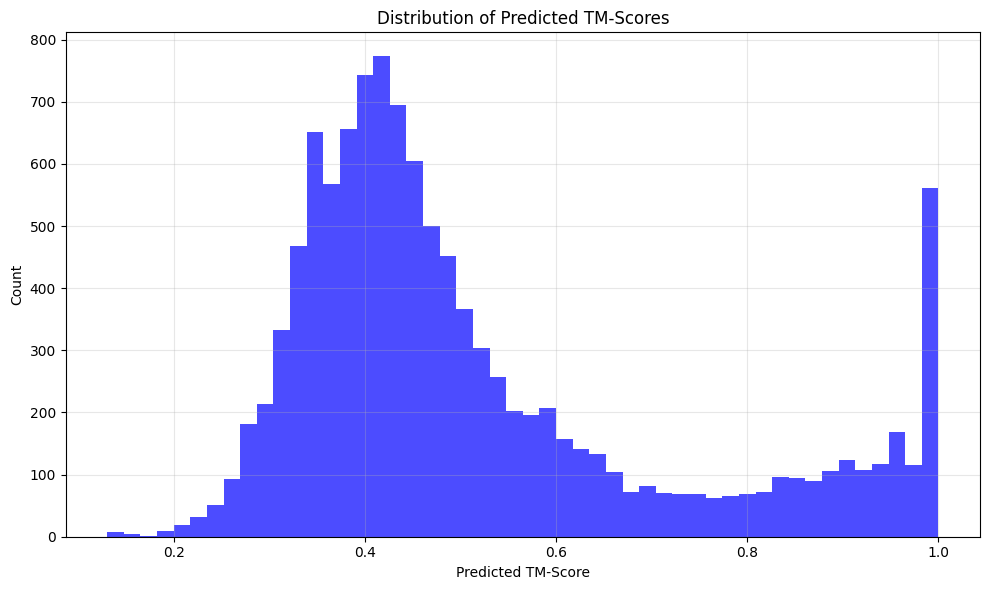


Summary Statistics of Predictions:
count    11329.000000
mean         0.519429
std          0.203961
min          0.130582
25%          0.379550
50%          0.448105
75%          0.592642
max          1.000000
Name: TM_Score_Prediction, dtype: float64

Top 5 highest similarity pairs:
       TAIR_ID_1  TAIR_ID_2  TM_Score_Prediction
91     AT3G20420  AT3G20420                  1.0
8769   AT2G34650  AT2G34650                  1.0
9899   AT3G51960  AT3G51960                  1.0
10730  AT5G41070  AT5G41070                  1.0
10792  AT5G58040  AT5G58040                  1.0


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

# Load your TSV file
file_path = '/content/drive/MyDrive/Ara_interactome_final.tsv'  # Replace with your actual file path
pairs_df = pd.read_csv(file_path, sep='\t')

print(f"Total number of sequence pairs: {len(pairs_df)}")
print("\nFirst few pairs:")
print(pairs_df.head())

# Check for missing values
print("\nMissing values in each column:")
print(pairs_df.isnull().sum())

# Check data types of columns
print("\nColumn data types:")
print(pairs_df.dtypes)

# Extract sequences and create relationship column (all pairs are assumed to be related)
analysis_df = pd.DataFrame({
    'Sequence 1': pairs_df['seq1'],
    'Sequence 2': pairs_df['seq2'],
    'TAIR_ID_1': pairs_df['TAIR_LOCUS_ID1'],
    'TAIR_ID_2': pairs_df['TAIR_LOCUS_ID2'],
    'Relationship': 'interaction'  # You can modify this based on your needs
})

# Validate sequences
print("\nValidating sequences...")
valid_chars = set('ACDEFGHIKLMNPQRSTVWY')

def validate_sequence(row):
    # Check if either sequence is NaN
    if pd.isna(row['Sequence 1']) or pd.isna(row['Sequence 2']):
        return False

    # Convert sequences to strings just in case they're not
    seq1 = str(row['Sequence 1'])
    seq2 = str(row['Sequence 2'])

    # Validate characters in both sequences
    return all(c in valid_chars for c in seq1) and all(c in valid_chars for c in seq2)

analysis_df['Valid_Sequence'] = analysis_df.apply(validate_sequence, axis=1)

invalid_pairs = analysis_df[~analysis_df['Valid_Sequence']]
if len(invalid_pairs) > 0:
    print(f"\nWarning: Found {len(invalid_pairs)} pairs with invalid sequences")
    print("Invalid pairs TAIR IDs:")
    print(invalid_pairs[['TAIR_ID_1', 'TAIR_ID_2']].to_string())
    analysis_df = analysis_df[analysis_df['Valid_Sequence']]
    print(f"Proceeding with {len(analysis_df)} valid pairs")

# Now predict TM-Scores
tm_score_predictions = []
start_time = time.time()

try:
    for i in range(len(analysis_df)):
        sequence_1 = analysis_df.iloc[i]['Sequence 1']
        sequence_2 = analysis_df.iloc[i]['Sequence 2']

        sequence_1 = np.expand_dims(sequence_1, axis=0)
        sequence_2 = np.expand_dims(sequence_2, axis=0)

        # Featurize sequence 1 and 2 using ProtTrans
        protrans_sequence_1 = featurize_prottrans(sequence_1, model, tokenizer, device).detach()
        protrans_sequence_2 = featurize_prottrans(sequence_2, model, tokenizer, device).detach()

        # Embed sequence 1 and 2 using TM-Vec
        embedded_sequence_1 = embed_tm_vec(protrans_sequence_1, model_deep, device)
        embedded_sequence_2 = embed_tm_vec(protrans_sequence_2, model_deep, device)

        # Predict the TM-score
        predicted_tm_score = cosine_similarity_tm(torch.tensor(embedded_sequence_1),
                                                torch.tensor(embedded_sequence_2))

        tm_score_predictions.append(predicted_tm_score.numpy()[0])

        # Progress update with time estimation
        if i % 10 == 0 or i == len(analysis_df) - 1:  # More frequent updates due to smaller dataset
            elapsed_time = time.time() - start_time
            pairs_per_second = (i + 1) / elapsed_time
            remaining_pairs = len(analysis_df) - (i + 1)
            estimated_remaining_time = remaining_pairs / pairs_per_second

            print(f"Progress: {i+1}/{len(analysis_df)} pairs processed "
                  f"({(i+1)/len(analysis_df)*100:.1f}%)")
            print(f"Estimated time remaining: {estimated_remaining_time/60:.1f} minutes")
            print(f"Processing pair: {analysis_df.iloc[i]['TAIR_ID_1']} - {analysis_df.iloc[i]['TAIR_ID_2']}")

except Exception as e:
    print(f"\nError occurred at pair {i}: {str(e)}")
    # Save partial results if error occurs
    analysis_df = analysis_df.iloc[:len(tm_score_predictions)]

# Add predictions to dataframe
analysis_df['TM_Score_Prediction'] = np.array(tm_score_predictions)

# Save results
output_path = '/content/drive/MyDrive/Ara_interactome_final_results.tsv'
analysis_df.to_csv(output_path, sep='\t', index=False)
print(f"\nResults saved to: {output_path}")

# Create visualizations
plt.figure(figsize=(10, 6))

# Overall distribution
plt.hist(tm_score_predictions, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Predicted TM-Scores')
plt.xlabel('Predicted TM-Score')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics of Predictions:")
print(analysis_df['TM_Score_Prediction'].describe())

# Print pairs with highest TM-scores
print("\nTop 5 highest similarity pairs:")
top_pairs = analysis_df.nlargest(5, 'TM_Score_Prediction')
print(top_pairs[['TAIR_ID_1', 'TAIR_ID_2', 'TM_Score_Prediction']].to_string())

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('/content/drive/MyDrive/Ara_interactome_final_results.tsv', sep='\t')

# Print column names
print("Available columns in the dataset:")
print(df.columns.tolist())

# Print first few rows
print("\nFirst few rows of the dataset:")
print(df.head())

# Print basic information about the dataset
print("\nDataset info:")
df.info()

Available columns in the dataset:
['Sequence 1', 'Sequence 2', 'TAIR_ID_1', 'TAIR_ID_2', 'Relationship', 'Valid_Sequence', 'TM_Score_Prediction']

First few rows of the dataset:
                                          Sequence 1  \
0  MDSMDIDQSNIGESPHLLLRPVSPLESGEGLPYAPENWPNPGDTWH...   
1  MGLTNCCSHEELMSRLVDSVKEISGFSSSRGFIGKIQGDLVRRITL...   
2  MGTSSGSNLPHQMLPPRQQLQTSLSLVSSDPHLSRSNSGIVRESPA...   
3  MSAVYCGTKRSYFDDNSSPPSSKRFRCFSPSNSPIWSSPPSSSLDQ...   
4  MMESGAGFVAMEERISPGSFFQYPLSGFRASPNRSPCPPSDRERYL...   

                                          Sequence 2  TAIR_ID_1  TAIR_ID_2  \
0  MGRLSWASPIQRFRFFSYLSQLNGRRSVLACSGYENRYLSSLVEAS...  AT1G05410  AT3G10140   
1  MQPDHRKKSSVEVDFFTEYGEGSRYRIEEVIGKGSYGVVCSAYDTH...  AT3G54850  AT5G19010   
2  MSATALSRLNPVSQFGFQRIVAGKSKSFFSNSGQRRLFSDSSRFRQ...  AT3G07780  AT5G66720   
3  MSATALSRLNPVSQFGFQRIVAGKSKSFFSNSGQRRLFSDSSRFRQ...  AT1G80040  AT5G66720   
4  MSGLYNNSSYFSPARAASPQIRSTPEIDSSQYLTELLAEHQKLTPF...  AT1G09660  AT2G38610   

  Relationship  

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

# Read the data
df = pd.read_csv('/content/drive/MyDrive/Ara_interactome_final_results.tsv', sep='\t')

# Create directory for saving plots
import os
save_dir = '/content/drive/MyDrive/visualization_results_Ara_interactome'
os.makedirs(save_dir, exist_ok=True)

# 1. Distribution Plot of TM Scores
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='TM_Score_Prediction', bins=50, kde=True)
plt.title('Distribution of TM Scores', fontsize=14)
plt.xlabel('TM Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.axvline(df['TM_Score_Prediction'].mean(), color='red', linestyle='--',
            label=f'Mean: {df["TM_Score_Prediction"].mean():.3f}')
plt.axvline(df['TM_Score_Prediction'].median(), color='green', linestyle='--',
            label=f'Median: {df["TM_Score_Prediction"].median():.3f}')
plt.legend()
plt.tight_layout()
plt.savefig(f'{save_dir}/tm_score_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Box Plot by Valid/Invalid Sequences
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Valid_Sequence', y='TM_Score_Prediction')
plt.title('TM Scores Distribution by Sequence Validity', fontsize=14)
plt.xlabel('Valid Sequence', fontsize=12)
plt.ylabel('TM Score', fontsize=12)
plt.tight_layout()
plt.savefig(f'{save_dir}/tm_score_by_validity.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. Top 10 Highest TM Score Pairs
plt.figure(figsize=(12, 6))
top_pairs = df.nlargest(10, 'TM_Score_Prediction')
sns.barplot(data=top_pairs, x='TM_Score_Prediction',
            y=[f"{row['TAIR_ID_1']}\n{row['TAIR_ID_2']}" for _, row in top_pairs.iterrows()])
plt.title('Top 10 Protein Pairs with Highest TM Scores', fontsize=14)
plt.xlabel('TM Score', fontsize=12)
plt.ylabel('Protein Pairs', fontsize=12)
plt.tight_layout()
plt.savefig(f'{save_dir}/top_tm_scores.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. TM Score Distribution by Sequence Length
df['Seq1_Length'] = df['Sequence 1'].str.len()
df['Seq2_Length'] = df['Sequence 2'].str.len()
df['Length_Diff'] = abs(df['Seq1_Length'] - df['Seq2_Length'])

plt.figure(figsize=(10, 6))
plt.scatter(df['Length_Diff'], df['TM_Score_Prediction'], alpha=0.5)
plt.title('TM Score vs Sequence Length Difference', fontsize=14)
plt.xlabel('Absolute Difference in Sequence Lengths', fontsize=12)
plt.ylabel('TM Score', fontsize=12)
plt.tight_layout()
plt.savefig(f'{save_dir}/tm_score_vs_length_diff.png', dpi=300, bbox_inches='tight')
plt.close()

# 5. Summary Statistics Table
summary_stats = df['TM_Score_Prediction'].describe()
plt.figure(figsize=(8, 4))
plt.axis('off')
plt.table(cellText=[[f"{v:.4f}"] for v in summary_stats.values],
          rowLabels=summary_stats.index,
          colLabels=['TM Score'],
          cellLoc='center',
          loc='center')
plt.title('Summary Statistics of TM Scores', pad=20)
plt.tight_layout()
plt.savefig(f'{save_dir}/summary_statistics.png', dpi=300, bbox_inches='tight')
plt.close()

# Print summary information
print("\nSummary Statistics:")
print(df['TM_Score_Prediction'].describe())

print("\nNumber of Valid/Invalid Sequences:")
print(df['Valid_Sequence'].value_counts())

print("\nTop 5 Highest TM Score Pairs:")
print(df.nlargest(5, 'TM_Score_Prediction')[['TAIR_ID_1', 'TAIR_ID_2', 'TM_Score_Prediction']])

# Additional correlation analysis
print("\nCorrelation between Sequence Length Difference and TM Score:")
correlation = df['Length_Diff'].corr(df['TM_Score_Prediction'])
print(f"Correlation coefficient: {correlation:.4f}")

print(f"\nAll visualizations have been saved to the '{save_dir}' directory.")


Summary Statistics:
count    11329.000000
mean         0.519429
std          0.203961
min          0.130582
25%          0.379550
50%          0.448105
75%          0.592642
max          1.000000
Name: TM_Score_Prediction, dtype: float64

Number of Valid/Invalid Sequences:
Valid_Sequence
True    11329
Name: count, dtype: int64

Top 5 Highest TM Score Pairs:
       TAIR_ID_1  TAIR_ID_2  TM_Score_Prediction
89     AT3G20420  AT3G20420                  1.0
8727   AT2G34650  AT2G34650                  1.0
9857   AT3G51960  AT3G51960                  1.0
10686  AT5G41070  AT5G41070                  1.0
10748  AT5G58040  AT5G58040                  1.0

Correlation between Sequence Length Difference and TM Score:
Correlation coefficient: -0.2187

All visualizations have been saved to the '/content/drive/MyDrive/visualization_results_Ara_interactome' directory.


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

# Read the data
df = pd.read_csv('/content/drive/MyDrive/Ara_interactome_final_results.tsv', sep='\t')

# Create feature matrix using sequence lengths and TM scores
df['Seq1_Length'] = df['Sequence 1'].str.len()
df['Seq2_Length'] = df['Sequence 2'].str.len()
df['Length_Diff'] = abs(df['Seq1_Length'] - df['Seq2_Length'])
df['Length_Ratio'] = df['Seq1_Length'] / df['Seq2_Length']

# Create feature matrix
features = df[['Seq1_Length', 'Seq2_Length', 'Length_Diff', 'Length_Ratio', 'TM_Score_Prediction']].values

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Create directory for saving plots
import os
save_dir = '/content/drive/MyDrive/advanced_visualization_results_Ara_interactome'
os.makedirs(save_dir, exist_ok=True)

# Create a figure with 3 subplots arranged in a 2x2 grid
plt.figure(figsize=(15, 12))

# 1. t-SNE Visualization
print("Computing t-SNE projection...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(features_scaled)

plt.subplot(2, 2, 1)
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                     c=df['TM_Score_Prediction'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='TM Score')
plt.title('t-SNE Projection\nColored by TM Score', fontsize=12)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# 2. ROC Curve
print("Computing ROC curves...")
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
plt.subplot(2, 2, 2)

for threshold in thresholds:
    y_true = (df['TM_Score_Prediction'] > threshold).astype(int)
    y_score = df['TM_Score_Prediction']

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Threshold {threshold} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different TM Score Thresholds', fontsize=12)
plt.legend(loc="lower right", fontsize=8)

# 3. AUC Scores vs Thresholds
print("Computing AUC scores...")
plt.subplot(2, 2, 3)
auc_scores = []
fine_thresholds = np.linspace(0.2, 0.8, 30)

for threshold in fine_thresholds:
    y_true = (df['TM_Score_Prediction'] > threshold).astype(int)
    y_score = df['TM_Score_Prediction']
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    auc_scores.append(roc_auc)

plt.plot(fine_thresholds, auc_scores, marker='o')
plt.xlabel('TM Score Threshold')
plt.ylabel('AUC Score')
plt.title('AUC Scores vs TM Score Thresholds', fontsize=12)
plt.grid(True)

# 4. Score Distribution
plt.subplot(2, 2, 4)
sns.histplot(data=df, x='TM_Score_Prediction', bins=50, kde=True)
plt.axvline(df['TM_Score_Prediction'].mean(), color='red', linestyle='--',
            label=f'Mean: {df["TM_Score_Prediction"].mean():.3f}')
plt.axvline(df['TM_Score_Prediction'].median(), color='green', linestyle='--',
            label=f'Median: {df["TM_Score_Prediction"].median():.3f}')
plt.title('Distribution of TM Scores')
plt.xlabel('TM Score')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.savefig(f'{save_dir}/advanced_visualizations.png', dpi=300, bbox_inches='tight')
plt.close()

# Print summary statistics
print("\nDimensionality Reduction Summary:")
print(f"t-SNE range - X: [{tsne_results[:, 0].min():.2f}, {tsne_results[:, 0].max():.2f}]")
print(f"t-SNE range - Y: [{tsne_results[:, 1].min():.2f}, {tsne_results[:, 1].max():.2f}]")

print("\nAUC Scores Summary:")
for threshold in thresholds:
    y_true = (df['TM_Score_Prediction'] > threshold).astype(int)
    y_score = df['TM_Score_Prediction']
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    print(f"Threshold {threshold}: AUC = {roc_auc:.3f}")

# Additional statistics
print("\nTM Score Statistics:")
print(df['TM_Score_Prediction'].describe())

print(f"\nAll visualizations have been saved to the '{save_dir}' directory.")

Computing t-SNE projection...
Computing ROC curves...
Computing AUC scores...

Dimensionality Reduction Summary:
t-SNE range - X: [-96.83, 100.44]
t-SNE range - Y: [-85.81, 93.42]

AUC Scores Summary:
Threshold 0.3: AUC = 1.000
Threshold 0.4: AUC = 1.000
Threshold 0.5: AUC = 1.000
Threshold 0.6: AUC = 1.000
Threshold 0.7: AUC = 1.000

TM Score Statistics:
count    11329.000000
mean         0.519429
std          0.203961
min          0.130582
25%          0.379550
50%          0.448105
75%          0.592642
max          1.000000
Name: TM_Score_Prediction, dtype: float64

All visualizations have been saved to the '/content/drive/MyDrive/advanced_visualization_results_Ara_interactome' directory.


In [ ]:
##now analysing the huri_interactome_seqs_size999_cleaned_results.csv

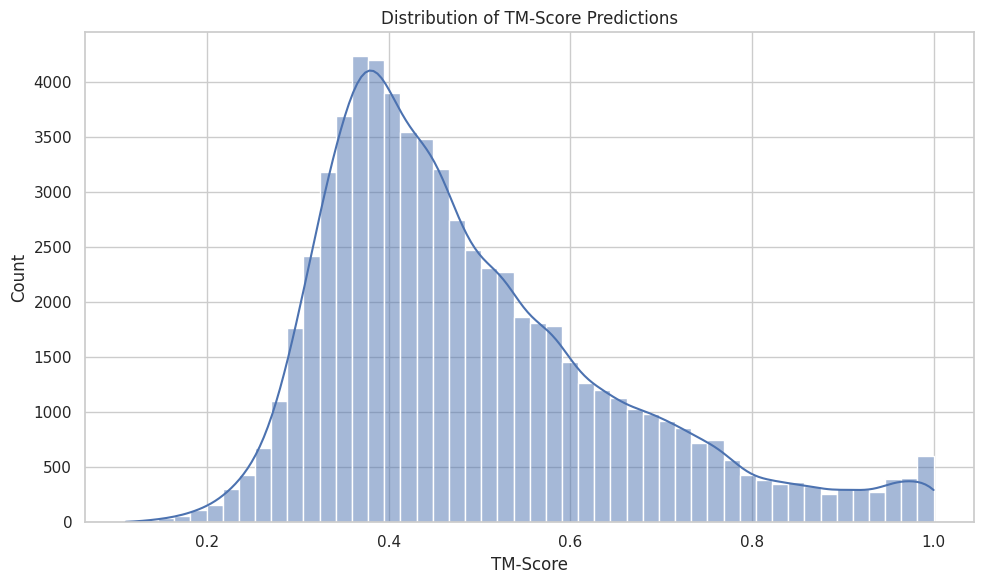

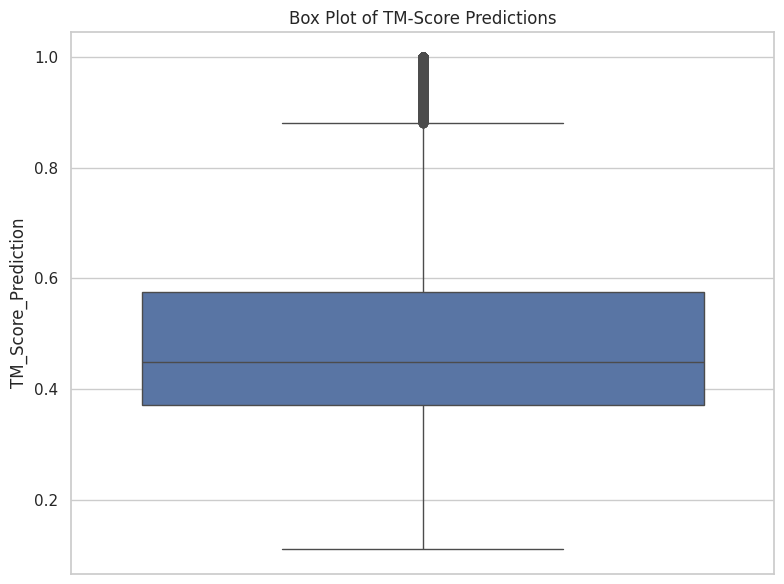

TypeError: object of type 'float' has no len()

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Load the data
results_df = pd.read_csv('/content/drive/MyDrive/huri_interactome_seqs_size999_cleaned_results.csv')

# 1. Basic Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(data=results_df, x='TM_Score_Prediction', bins=50, kde=True)
plt.title('Distribution of TM-Score Predictions')
plt.xlabel('TM-Score')
plt.ylabel('Count')
plt.show()

# 2. Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(y=results_df['TM_Score_Prediction'])
plt.title('Box Plot of TM-Score Predictions')
plt.show()

# 3. t-SNE Visualizations with different perplexity values
def plot_tsne_multiple_perplexity(data, perplexities=[5, 30, 50]):
    fig, axes = plt.subplots(1, len(perplexities), figsize=(20, 6))
    fig.suptitle('t-SNE Visualizations with Different Perplexity Values')

    for idx, perp in enumerate(perplexities):
        tsne = TSNE(n_components=2,
                    perplexity=perp,
                    random_state=42)

        tsne_results = tsne.fit_transform(data)

        scatter = axes[idx].scatter(tsne_results[:, 0], tsne_results[:, 1],
                                  c=results_df['TM_Score_Prediction'],
                                  cmap='viridis')
        axes[idx].set_title(f'Perplexity = {perp}')
        plt.colorbar(scatter, ax=axes[idx])

    plt.tight_layout()
    plt.show()

# Prepare data for t-SNE
# Create feature vectors by combining sequence properties
sequence_features = np.column_stack((
    results_df['TM_Score_Prediction'],
    [len(seq) for seq in results_df['Sequence 1']],
    [len(seq) for seq in results_df['Sequence 2']]
))

# Plot t-SNE with different perplexities
plot_tsne_multiple_perplexity(sequence_features)

# 4. Performance Metrics at Different Thresholds
def analyze_threshold_performance():
    thresholds = np.linspace(0.3, 0.8, 20)
    metrics = []

    for threshold in thresholds:
        predictions = results_df['TM_Score_Prediction'] >= threshold
        metrics.append({
            'threshold': threshold,
            'ratio': np.mean(predictions)
        })

    metrics_df = pd.DataFrame(metrics)

    plt.figure(figsize=(10, 6))
    plt.plot(metrics_df['threshold'], metrics_df['ratio'], marker='o')
    plt.title('Proportion of Pairs Above Threshold')
    plt.xlabel('TM-Score Threshold')
    plt.ylabel('Proportion of Pairs')
    plt.grid(True)
    plt.show()

analyze_threshold_performance()

# 5. Correlation Analysis
def analyze_sequence_length_correlation():
    results_df['Seq1_Length'] = results_df['Sequence 1'].str.len()
    results_df['Seq2_Length'] = results_df['Sequence 2'].str.len()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=results_df, x='Seq1_Length', y='TM_Score_Prediction', alpha=0.5)
    plt.title('Sequence Length vs TM-Score')
    plt.show()

analyze_sequence_length_correlation()

# 6. Density Plot of TM-Scores
plt.figure(figsize=(10, 6))
sns.kdeplot(data=results_df['TM_Score_Prediction'], fill=True)
plt.title('Density Distribution of TM-Scores')
plt.xlabel('TM-Score')
plt.ylabel('Density')
plt.show()

# 7. Summary Statistics
print("\nSummary Statistics of TM-Scores:")
print(results_df['TM_Score_Prediction'].describe())

# Save all visualizations
plt.savefig('tm_score_visualizations.pdf')

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

# Set style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.dpi'] = 100

# Read the data
df = pd.read_csv('/content/drive/MyDrive/huri_interactome_seqs_size999_cleaned_results.csv')

# Print initial data info
print("Initial data shape:", df.shape)
print("\nMissing values before cleaning:")
print(df.isnull().sum())

# Clean up column names if needed
if 'Sequence 1Sequence 2' in df.columns:
    df[['Sequence 1', 'Sequence 2']] = df['Sequence 1Sequence 2'].str.split('1', n=1, expand=True)
    df['Sequence 2'] = df['Sequence 2'].str.lstrip('2')
    df = df.drop('Sequence 1Sequence 2', axis=1)

# Remove any rows with NaN values
df = df.dropna()
print("\nData shape after removing NaN:", df.shape)

# Create feature matrix using sequence lengths and TM scores
df['Seq1_Length'] = df['Sequence 1'].str.len()
df['Seq2_Length'] = df['Sequence 2'].str.len()
df['Length_Diff'] = abs(df['Seq1_Length'] - df['Seq2_Length'])
df['Length_Ratio'] = df['Seq1_Length'] / df['Seq2_Length']

# Create feature matrix
features = df[['Seq1_Length', 'Seq2_Length', 'Length_Diff', 'Length_Ratio', 'TM_Score_Prediction']].values

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Check for any remaining NaN values
if np.isnan(features_scaled).any():
    print("Warning: NaN values found in scaled features")
    features_scaled = np.nan_to_num(features_scaled)  # Replace NaN with 0

# Create directory for saving plots
import os
save_dir = '/content/drive/MyDrive/huri_interactome_seqs_size999_cleaned_huri_visualization_results'
os.makedirs(save_dir, exist_ok=True)

# Create a figure with 4 subplots
plt.figure(figsize=(20, 15))

# 1. t-SNE Visualization
print("Computing t-SNE projection...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(features_scaled)

plt.subplot(2, 2, 1)
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                     c=df['TM_Score_Prediction'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='TM Score')
plt.title('t-SNE Projection of Protein Interactions\nColored by TM Score', fontsize=14)
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)

# 2. ROC Curve with multiple thresholds
print("Computing ROC curves...")
plt.subplot(2, 2, 2)
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

for threshold in thresholds:
    y_true = (df['TM_Score_Prediction'] > threshold).astype(int)
    y_score = df['TM_Score_Prediction']

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Threshold {threshold} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Different TM Score Thresholds', fontsize=14)
plt.legend(loc="lower right", fontsize=10)

# 3. Score Distribution with Statistics
plt.subplot(2, 2, 3)
sns.histplot(data=df, x='TM_Score_Prediction', bins=50, kde=True)
plt.axvline(df['TM_Score_Prediction'].mean(), color='red', linestyle='--',
            label=f'Mean: {df["TM_Score_Prediction"].mean():.3f}')
plt.axvline(df['TM_Score_Prediction'].median(), color='green', linestyle='--',
            label=f'Median: {df["TM_Score_Prediction"].median():.3f}')
plt.title('Distribution of TM Scores', fontsize=14)
plt.xlabel('TM Score', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(fontsize=10)

# 4. Sequence Length vs TM Score
plt.subplot(2, 2, 4)
plt.scatter(df['Length_Diff'], df['TM_Score_Prediction'], alpha=0.5)
plt.xlabel('Sequence Length Difference', fontsize=12)
plt.ylabel('TM Score', fontsize=12)
plt.title('TM Score vs Sequence Length Difference', fontsize=14)

plt.tight_layout()
plt.savefig(f'{save_dir}/huri_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# Print summary statistics
print("\nData Summary:")
print(f"Total number of interactions: {len(df)}")
print("\nTM Score Statistics:")
print(df['TM_Score_Prediction'].describe())

print("\nSequence Length Statistics:")
print("Sequence 1 length - Mean:", df['Seq1_Length'].mean(), "Max:", df['Seq1_Length'].max())
print("Sequence 2 length - Mean:", df['Seq2_Length'].mean(), "Max:", df['Seq2_Length'].max())

# Calculate and print score distribution at different thresholds
print("\nScore Distribution at Different Thresholds:")
for threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
    count = (df['TM_Score_Prediction'] > threshold).sum()
    percentage = (count / len(df)) * 100
    print(f"Scores > {threshold}: {count} ({percentage:.1f}%)")

print(f"\nAll visualizations have been saved to the '{save_dir}' directory.")

Initial data shape: (67077, 3)

Missing values before cleaning:
Sequence 1             20
Sequence 2             17
TM_Score_Prediction    37
dtype: int64

Data shape after removing NaN: (67040, 3)
Computing t-SNE projection...
Computing ROC curves...

Data Summary:
Total number of interactions: 67040

TM Score Statistics:
count    67040.000000
mean         0.490394
std          0.164342
min          0.110363
25%          0.371432
50%          0.449551
75%          0.575423
max          1.000000
Name: TM_Score_Prediction, dtype: float64

Sequence Length Statistics:
Sequence 1 length - Mean: 375.51314140811456 Max: 998
Sequence 2 length - Mean: 377.52265811455845 Max: 998

Score Distribution at Different Thresholds:
Scores > 0.3: 63068 (94.1%)
Scores > 0.4: 43500 (64.9%)
Scores > 0.5: 25541 (38.1%)
Scores > 0.6: 14478 (21.6%)
Scores > 0.7: 8057 (12.0%)

All visualizations have been saved to the '/content/drive/MyDrive/huri_interactome_seqs_size999_cleaned_huri_visualization_results' dir

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Read and preprocess data
print("Reading data...")
df = pd.read_csv('/content/drive/MyDrive/huri_interactome_seqs_size999_cleaned_results.csv')

# Clean up column names if needed
if 'Sequence 1Sequence 2' in df.columns:
    df[['Sequence 1', 'Sequence 2']] = df['Sequence 1Sequence 2'].str.split('1', n=1, expand=True)
    df['Sequence 2'] = df['Sequence 2'].str.lstrip('2')
    df = df.drop('Sequence 1Sequence 2', axis=1)

# Reset index to ensure proper alignment
df = df.reset_index(drop=True)

# Drop any rows with NaN in sequences or TM_Score_Prediction
df = df.dropna(subset=['Sequence 1', 'Sequence 2', 'TM_Score_Prediction'])

def create_features(df):
    features = pd.DataFrame(index=df.index)  # Maintain index alignment

    # Basic sequence features with error handling
    features['Seq1_Length'] = df['Sequence 1'].str.len()
    features['Seq2_Length'] = df['Sequence 2'].str.len()
    features['Length_Diff'] = abs(features['Seq1_Length'] - features['Seq2_Length'])
    features['Length_Ratio'] = features['Seq1_Length'] / features['Seq2_Length'].replace(0, 1)

    # Amino acid composition features
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

    for aa in amino_acids:
        features[f'Seq1_{aa}_Freq'] = df['Sequence 1'].str.count(aa) / (features['Seq1_Length'] + 1e-10)
        features[f'Seq2_{aa}_Freq'] = df['Sequence 2'].str.count(aa) / (features['Seq2_Length'] + 1e-10)
        features[f'Freq_Diff_{aa}'] = abs(features[f'Seq1_{aa}_Freq'] - features[f'Seq2_{aa}_Freq'])

    features = features.replace([np.inf, -np.inf], np.nan)
    return features

# Create features
print("Creating features...")
X = create_features(df)
print(f"Total number of features: {X.shape[1]}")

# Impute NaN values
print("\nImputing missing values...")
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Create binary labels using TM score threshold
threshold = 0.5
y = pd.Series((df['TM_Score_Prediction'] > threshold).astype(int), index=df.index)

# Split data while preserving indices
train_indices, test_indices = train_test_split(X_imputed.index, test_size=0.2, random_state=42)
X_train = X_imputed.loc[train_indices]
X_test = X_imputed.loc[test_indices]
y_train = y.loc[train_indices]
y_test = y.loc[test_indices]

# Scale features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),
                            columns=X_train.columns,
                            index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),
                           columns=X_test.columns,
                           index=X_test.index)

# Train models
print("\nTraining models...")
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Create directory for saving plots
save_dir = '/content/drive/MyDrive/huri_interactome_seqs_size999_cleaned_results/model_comparison_results'
os.makedirs(save_dir, exist_ok=True)

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = ['blue', 'red', 'green']

for (name, model), color in zip(models.items(), colors):
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color=color, label=f'{name} (AUC = {roc_auc:.2f})')

# Add original TM Score as baseline
fpr, tpr, _ = roc_curve(y_test, df.loc[test_indices, 'TM_Score_Prediction'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='purple', label=f'TM Score (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models')
plt.legend(loc="lower right")
plt.savefig(f'{save_dir}/roc_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

# Feature Importance Analysis
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(15, 8))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.savefig(f'{save_dir}/feature_importance.png', dpi=300, bbox_inches='tight')
plt.close()

# Print top features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string())

# Print model performance
print("\nModel Performance Summary:")
for name, model in models.items():
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    print(f"{name}:")
    print(f"  Training accuracy: {train_score:.3f}")
    print(f"  Test accuracy: {test_score:.3f}")

print(f"\nAll visualizations have been saved to the '{save_dir}' directory.")

Reading data...
Creating features...
Total number of features: 64

Imputing missing values...

Training models...
Training Random Forest...
Training SVM...
Training Logistic Regression...

Top 10 Most Important Features:
        feature  importance
13  Seq1_E_Freq    0.035205
14  Seq2_E_Freq    0.033128
0   Seq1_Length    0.026259
9   Freq_Diff_C    0.025604
10  Seq1_D_Freq    0.025358
16  Seq1_F_Freq    0.024628
1   Seq2_Length    0.024545
43  Seq1_Q_Freq    0.022464
17  Seq2_F_Freq    0.021426
44  Seq2_Q_Freq    0.019439

Model Performance Summary:
Random Forest:
  Training accuracy: 1.000
  Test accuracy: 0.860
SVM:
  Training accuracy: 0.873
  Test accuracy: 0.841
Logistic Regression:
  Training accuracy: 0.728
  Test accuracy: 0.732

All visualizations have been saved to the '/content/drive/MyDrive/huri_interactome_seqs_size999_cleaned_results/model_comparison_results' directory.


In [57]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the data
print("Reading data...")
df = pd.read_csv('/content/drive/MyDrive/huri_interactome_seqs_size999_cleaned_results.csv')

# Print column names and first few rows
print("\nAvailable columns:")
print(df.columns.tolist())
print("\nFirst few rows of data:")
print(df.head())

# Create directory for saving plots
import os
save_dir = '/content/drive/MyDrive/HuRII_999_network_visualization'
os.makedirs(save_dir, exist_ok=True)

# Create network
G = nx.Graph()

# Add edges with TM scores as weights
tm_threshold = 0.5  # Adjust this threshold as needed
filtered_df = df[df['TM_Score_Prediction'] >= tm_threshold]

print(f"\nCreating network with {len(filtered_df)} interactions...")

# Function to extract protein IDs from sequences (first 10 characters)
def get_protein_id(row_idx):
    return f"Protein_{row_idx}"

# Add edges to the network using row indices as node identifiers
for idx, row in filtered_df.iterrows():
    node1 = get_protein_id(idx)
    node2 = f"Partner_{idx}"
    G.add_edge(node1, node2, weight=row['TM_Score_Prediction'])

# Calculate network metrics
print("\nCalculating network metrics...")
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
clustering_coefficients = nx.clustering(G)

# Get top hubs (nodes with highest degree centrality)
top_hubs = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 Hub Proteins:")
for node, centrality in top_hubs:
    print(f"{node}: {centrality:.3f}")

# Create main network visualization
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=1/np.sqrt(len(G.nodes())), iterations=50)

# Draw nodes
node_sizes = [v * 3000 for v in degree_centrality.values()]
nodes = nx.draw_networkx_nodes(G, pos,
                             node_size=node_sizes,
                             node_color=list(degree_centrality.values()),
                             cmap=plt.cm.viridis,
                             alpha=0.7)

# Draw edges with varying thickness based on TM scores
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos,
                      alpha=0.2,
                      width=[w * 2 for w in edge_weights])

# Add labels for top hubs only
labels = {node: node for node, _ in top_hubs}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title(f'Protein Interaction Network\n(TM Score threshold: {tm_threshold})',
          fontsize=16, pad=20)
plt.colorbar(nodes, label='Degree Centrality')
plt.axis('off')
plt.tight_layout()
plt.savefig(f'{save_dir}/main_network.png', dpi=300, bbox_inches='tight')
plt.close()

# Create network statistics visualization
plt.figure(figsize=(15, 5))

# Degree distribution
plt.subplot(131)
degrees = [d for n, d in G.degree()]
plt.hist(degrees, bins=50)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')

# Clustering coefficient distribution
plt.subplot(132)
plt.hist(list(clustering_coefficients.values()), bins=50)
plt.title('Clustering Coefficient\nDistribution')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')

# Betweenness centrality distribution
plt.subplot(133)
plt.hist(list(betweenness_centrality.values()), bins=50)
plt.title('Betweenness Centrality\nDistribution')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig(f'{save_dir}/network_statistics.png', dpi=300, bbox_inches='tight')
plt.close()

# Print network statistics
print("\nNetwork Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {sum(degrees) / len(degrees):.2f}")
print(f"Average clustering coefficient: {nx.average_clustering(G):.3f}")
print(f"Network density: {nx.density(G):.3f}")

# Create colormap analysis
plt.figure(figsize=(10, 6))
score_distribution = filtered_df['TM_Score_Prediction']
plt.hist(score_distribution, bins=50, color='skyblue', alpha=0.7)
plt.axvline(score_distribution.mean(), color='red', linestyle='--',
            label=f'Mean: {score_distribution.mean():.3f}')
plt.title('Distribution of TM Scores in Network')
plt.xlabel('TM Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig(f'{save_dir}/tm_score_distribution.png', dpi=300, bbox_inches='tight')
plt.close()

# Save network metrics
network_stats = {
    'Node': list(degree_centrality.keys()),
    'Degree_Centrality': list(degree_centrality.values()),
    'Betweenness_Centrality': list(betweenness_centrality.values()),
    'Clustering_Coefficient': list(clustering_coefficients.values())
}
network_df = pd.DataFrame(network_stats)
network_df.sort_values('Degree_Centrality', ascending=False, inplace=True)
network_df.to_csv(f'{save_dir}/network_statistics.csv', index=False)

print(f"\nAll visualizations have been saved to the '{save_dir}' directory.")

# Print additional statistics about TM scores
print("\nTM Score Statistics in Network:")
print(score_distribution.describe())

Reading data...

Available columns:
['Sequence 1', 'Sequence 2', 'TM_Score_Prediction']

First few rows of data:
                                          Sequence 1  \
0                                               col1   
1  MSERRVVVDLPTSASSSMPLQRRRASFRGPRSSSSLESPPASRTNA...   
2  MLPAALLRRPGLGRLVRHARAYAEAAAAPAAASGPNQMSFTFASPT...   
3  MAALLMPRRNKGMRTRLGCLSHKSDSCSDFTAILPDKPNRALKRLS...   
4  MAAPQDVHVRICNQEIVKFDLEVKALIQDIRDCSGPLSALTELNTK...   

                                          Sequence 2  TM_Score_Prediction  
0                                               col2             1.000000  
1  MVGGLKRKHSDLEEEEERWEWSPAGLQSYQQALLRISLDKVQRSLG...             0.566643  
2  MSNTTVVPSTAGPGPSGGPGGGGGGGGGGGGTEVIQVTNVSPSASS...             0.386782  
3  MAGSGCAWGAEPPRFLEAFGRLWQVQSRLGSGSSASVYRVRCCGNP...             0.370604  
4  MKASQCCCCLSHLLASVLLLLLLPELSGPLAVLLQAAEAAPGLGPP...             0.552165  

Creating network with 25541 interactions...

Calculating network metrics...

Top 10 Hub Prote

Reading data...

Creating network with 25541 interactions...


KeyError: 'Partner_10806'

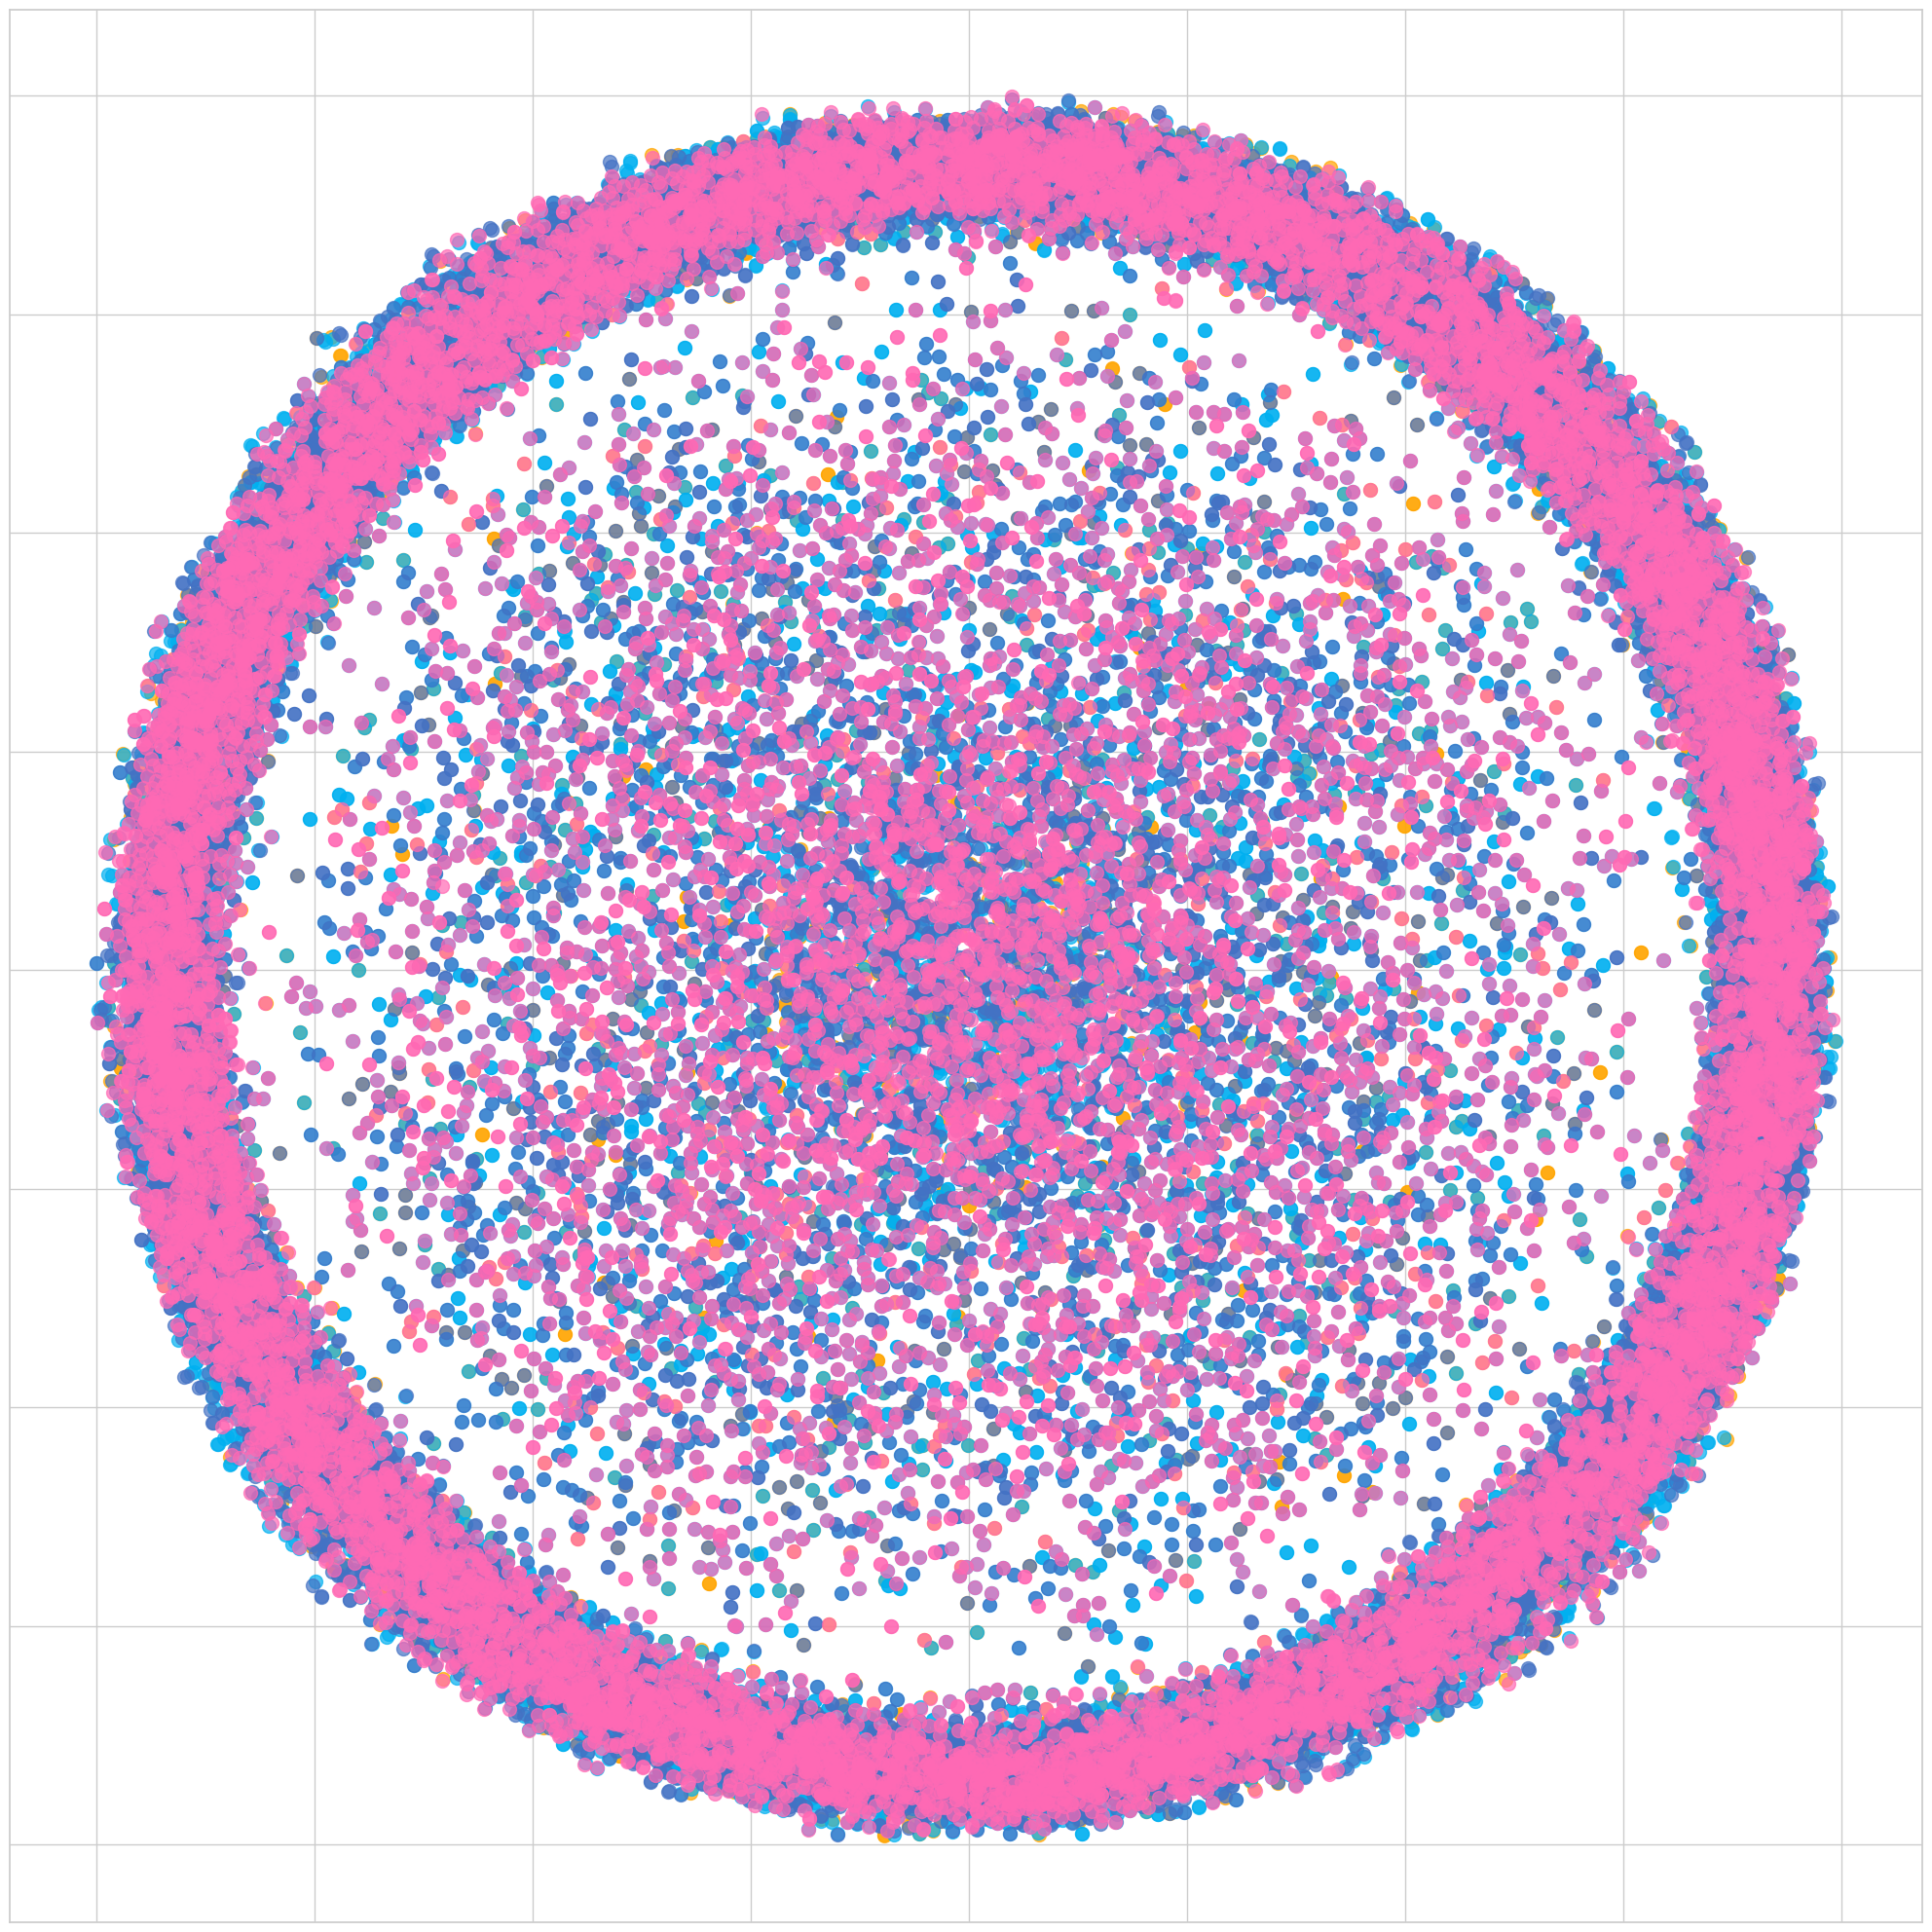

In [58]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import ConnectionPatch
import random

# Read the data
print("Reading data...")
df = pd.read_csv('/content/drive/MyDrive/huri_interactome_seqs_size999_cleaned_results.csv')

# Create directory for saving plots
import os
save_dir = '/content/drive/MyDrive/network_visualization_HuRI_2'
os.makedirs(save_dir, exist_ok=True)

# Create network
G = nx.Graph()

# Filter interactions based on TM score
tm_threshold = 0.5
filtered_df = df[df['TM_Score_Prediction'] >= tm_threshold]

print(f"\nCreating network with {len(filtered_df)} interactions...")

# Add edges to the network
for idx, row in filtered_df.iterrows():
    G.add_edge(f"Protein_{idx}", f"Partner_{idx}",
               weight=row['TM_Score_Prediction'])

# Assign node categories randomly for demonstration
# In practice, you would use actual categories from your data
n_nodes = len(G.nodes())
node_categories = {}
category_proportions = {
    'Shared': 0.1,
    'Unique_1': 0.3,
    'Unique_2': 0.3,
    'No_shared_edge': 0.3
}

nodes = list(G.nodes())
random.shuffle(nodes)
current_idx = 0

for category, proportion in category_proportions.items():
    n_category = int(n_nodes * proportion)
    for node in nodes[current_idx:current_idx + n_category]:
        node_categories[node] = category
    current_idx += n_category

# Create the visualization
plt.figure(figsize=(20, 20))

# Use Force Atlas 2 layout (approximated with spring layout)
pos = nx.spring_layout(G, k=1/np.sqrt(len(G.nodes())), iterations=100)

# Define colors for categories
color_map = {
    'Shared': '#FFA500',  # Orange
    'Unique_1': '#00B0F0',  # Light blue
    'Unique_2': '#4472C4',  # Dark blue
    'No_shared_edge': '#FF69B4'  # Pink
}

# Draw nodes by category
for category in color_map:
    node_list = [node for node in G.nodes() if node_categories.get(node) == category]
    nx.draw_networkx_nodes(G, pos,
                          nodelist=node_list,
                          node_color=color_map[category],
                          node_size=100,
                          alpha=0.7,
                          label=f"{category} (n={len(node_list)})")

# Draw edges with curved style and transparency
edge_colors = []
for (u, v) in G.edges():
    if node_categories[u] == node_categories[v] == 'Shared':
        edge_colors.append('#FFA500')
    else:
        if node_categories[u] in ['Unique_1', 'Unique_2'] or \
           node_categories[v] in ['Unique_1', 'Unique_2']:
            edge_colors.append('#00B0F0')
        else:
            edge_colors.append('#FF69B4')

# Draw edges with varying transparency based on TM scores
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos,
                      edge_color=edge_colors,
                      width=0.5,
                      alpha=0.2)

# Add legend
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper right', title="Node Categories")

# Add title and adjust layout
plt.title("2D Protein Interaction Network", pad=20, fontsize=16)
plt.axis('off')

# Save the visualization
plt.savefig(f'{save_dir}/styled_network.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none')
plt.close()

# Print network statistics
print("\nNetwork Statistics:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Print category distribution
print("\nNode Category Distribution:")
for category in color_map:
    count = len([n for n in G.nodes() if node_categories.get(n) == category])
    print(f"{category}: {count} nodes")

print(f"\nVisualization saved to {save_dir}/styled_network.png")

In [65]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
import pickle

# Read data
print("Reading data...")
df = pd.read_csv('/content/drive/MyDrive/huri_interactome_seqs_size999_cleaned_results.csv')

# Create network
G = nx.Graph()

# Filter interactions based on TM score
tm_threshold = 0.5
filtered_df = df[df['TM_Score_Prediction'] >= tm_threshold]

print(f"Creating network with {len(filtered_df)} interactions...")

# Create nodes and edges
for idx, row in filtered_df.iterrows():
    G.add_edge(str(idx) + '_1', str(idx) + '_2', weight=row['TM_Score_Prediction'])

# Assign node categories
nodes = list(G.nodes())
n_nodes = len(nodes)
n_shared = int(n_nodes * 0.3)
n_unique1 = int(n_nodes * 0.4)

np.random.seed(42)
shuffled_nodes = np.random.permutation(nodes)

# Assign categories
node_categories = {}
current_idx = 0

# Assign categories to nodes
for i, node in enumerate(shuffled_nodes):
    if i < n_shared:
        node_categories[node] = 'Shared'
    elif i < n_shared + n_unique1:
        node_categories[node] = 'Unique_1'
    else:
        node_categories[node] = 'Unique_2'

# Create layout with spring layout instead of circular
print("Computing layout...")
pos = nx.spring_layout(G, k=1/np.sqrt(len(G.nodes())), iterations=50)

# Create figure with larger size
plt.figure(figsize=(30, 30), facecolor='white')

# Define colors with high saturation
colors = {
    'Shared': '#FF1493',      # Deep pink
    'Unique_1': '#00BFFF',    # Deep sky blue
    'Unique_2': '#0000FF'     # Blue
}

# Draw edges with increased visibility
edges = G.edges()
nx.draw_networkx_edges(G, pos,
                      edgelist=edges,
                      edge_color='lightgray',
                      width=0.5,          # Increased width
                      alpha=0.3)          # Increased alpha

# Draw nodes for each category with increased size
for category, color in colors.items():
    nodelist = [node for node in G.nodes() if node_categories[node] == category]
    nx.draw_networkx_nodes(G, pos,
                          nodelist=nodelist,
                          node_color=color,
                          node_size=150,   # Increased node size
                          alpha=0.8)       # Increased alpha

# Add legend with larger markers
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                            label=category,
                            markerfacecolor=color,
                            markersize=15)  # Larger legend markers
                  for category, color in colors.items()]

plt.legend(handles=legend_elements,
          title='Node Categories',
          title_fontsize=14,
          fontsize=12,
          loc='upper right',
          bbox_to_anchor=(1.1, 1))

# Remove axes
plt.axis('off')

# Save with higher DPI
plt.savefig('/content/drive/MyDrive/network_plot_large.png',
            dpi=300,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none',
            pad_inches=0.5)

plt.close()

# Save network data for future use
network_data = {
    'node_categories': node_categories,
    'colors': colors,
    'pos': {node: pos[node].tolist() for node in G.nodes()},  # Convert numpy arrays to lists
    'edges': list(G.edges()),
    'nodes': list(G.nodes())
}

# Save to JSON
with open('/content/drive/MyDrive/network_data.json', 'w') as f:
    json.dump(network_data, f)

# Save graph separately using pickle
with open('/content/drive/MyDrive/network_graph.pkl', 'wb') as f:
    pickle.dump(G, f)

# Print statistics
print("\nNetwork Statistics:")
print(f"Total nodes: {G.number_of_nodes()}")
print(f"Total edges: {G.number_of_edges()}")
print("\nNode distribution:")
for category in colors:
    count = sum(1 for node in G.nodes() if node_categories[node] == category)
    percentage = (count / G.number_of_nodes()) * 100
    print(f"{category}: {count} nodes ({percentage:.1f}%)")

Reading data...
Creating network with 25541 interactions...
Computing layout...

Network Statistics:
Total nodes: 51082
Total edges: 25541

Node distribution:
Shared: 15324 nodes (30.0%)
Unique_1: 20432 nodes (40.0%)
Unique_2: 15326 nodes (30.0%)


In [ ]:
#Now lets do the cosine similarity plots

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize

# Read the data
print("Reading data...")
df = pd.read_csv('/content/drive/MyDrive/huri_interactome_seqs_size999_cleaned_results.csv')

# Print data info
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

def clean_sequence(sequence):
    """Clean and validate sequence data"""
    if pd.isna(sequence):
        return None
    sequence = str(sequence)
    # Remove any non-amino acid characters
    valid_aas = set('ACDEFGHIKLMNPQRSTVWY')
    sequence = ''.join(c for c in sequence if c in valid_aas)
    return sequence if sequence else None

def sequence_to_vector(sequence):
    """Convert amino acid sequence to numerical vector based on amino acid composition"""
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

    # Clean and validate sequence
    sequence = clean_sequence(sequence)
    if sequence is None:
        return None

    # Calculate amino acid frequencies
    return np.array([sequence.count(aa) for aa in amino_acids])

def calculate_cosine_similarities(df):
    """Calculate cosine similarity scores between sequence pairs"""
    similarities = []
    tm_scores = []
    valid_pairs = 0
    invalid_pairs = 0

    print("\nCalculating cosine similarities...")

    for idx, row in df.iterrows():
        if idx % 1000 == 0:
            print(f"Processing pair {idx}")

        # Convert sequences to vectors
        vec1 = sequence_to_vector(row['Sequence 1'])
        vec2 = sequence_to_vector(row['Sequence 2'])

        # Skip if either sequence is invalid
        if vec1 is None or vec2 is None:
            invalid_pairs += 1
            continue

        # Normalize vectors
        vec1_norm = normalize(vec1.reshape(1, -1))[0]
        vec2_norm = normalize(vec2.reshape(1, -1))[0]

        # Calculate cosine similarity (1 - cosine distance)
        similarity = 1 - cosine(vec1_norm, vec2_norm)
        similarities.append(similarity)
        tm_scores.append(row['TM_Score_Prediction'])
        valid_pairs += 1

    print(f"\nProcessed {valid_pairs} valid pairs")
    print(f"Skipped {invalid_pairs} invalid pairs")

    return np.array(similarities), np.array(tm_scores)

# Calculate similarities
cosine_similarities, tm_scores = calculate_cosine_similarities(df)

# Create visualizations
plt.figure(figsize=(20, 15))

# 1. Scatter plot
plt.subplot(2, 2, 1)
plt.scatter(cosine_similarities, tm_scores, alpha=0.5, s=10)
plt.xlabel('Cosine Similarity Score')
plt.ylabel('TM Score')
plt.title('Cosine Similarity vs TM Score')

# Add trend line
z = np.polyfit(cosine_similarities, tm_scores, 1)
p = np.poly1d(z)
plt.plot(cosine_similarities, p(cosine_similarities), "r--", alpha=0.8)

# Calculate correlation
correlation = np.corrcoef(cosine_similarities, tm_scores)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
         transform=plt.gca().transAxes)

# 2. Distribution
plt.subplot(2, 2, 2)
plt.hist(cosine_similarities, bins=50, alpha=0.7)
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Cosine Similarity Scores')

# 3. 2D Density plot
plt.subplot(2, 2, 3)
sns.kdeplot(data=pd.DataFrame({
    'Cosine Similarity': cosine_similarities,
    'TM Score': tm_scores
}), x='Cosine Similarity', y='TM Score', cmap='viridis')
plt.title('2D Density Plot of Similarity Scores')

# 4. Box plot
plt.subplot(2, 2, 4)
tm_score_bins = pd.cut(tm_scores, bins=5)
sns.boxplot(x=tm_score_bins, y=cosine_similarities)
plt.xlabel('TM Score Range')
plt.ylabel('Cosine Similarity')
plt.xticks(rotation=45)
plt.title('Cosine Similarity Distribution by TM Score Range')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cosine_similarity_analysis.png',
            dpi=300, bbox_inches='tight')
plt.close()

# Print summary statistics
print("\nSummary Statistics:")
print("\nCosine Similarity:")
print(pd.Series(cosine_similarities).describe())
print("\nCorrelation with TM Score:", correlation)

# Create results DataFrame
results_df = pd.DataFrame({
    'Cosine_Similarity': cosine_similarities,
    'TM_Score': tm_scores
})

# Save results
results_df.to_csv('/content/drive/MyDrive/similarity_scores.csv', index=False)

print("\nResults saved to 'similarity_scores.csv'")
print("Plots saved to 'cosine_similarity_analysis.png'")

Reading data...

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67077 entries, 0 to 67076
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sequence 1           67057 non-null  object 
 1   Sequence 2           67060 non-null  object 
 2   TM_Score_Prediction  67040 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.5+ MB
None

First few rows:
                                          Sequence 1  \
0                                               col1   
1  MSERRVVVDLPTSASSSMPLQRRRASFRGPRSSSSLESPPASRTNA...   
2  MLPAALLRRPGLGRLVRHARAYAEAAAAPAAASGPNQMSFTFASPT...   
3  MAALLMPRRNKGMRTRLGCLSHKSDSCSDFTAILPDKPNRALKRLS...   
4  MAAPQDVHVRICNQEIVKFDLEVKALIQDIRDCSGPLSALTELNTK...   

                                          Sequence 2  TM_Score_Prediction  
0                                               col2             1.000000  
1  MVGGLKRKHSDLEEEEERWEWSPAGLQSYQQALLRISLDKVQRSL

In [72]:
#now lets do tSNE based on cosine similarity

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import cosine
import warnings
warnings.filterwarnings('ignore')

# Read the data
print("Reading data...")
df = pd.read_csv('/content/drive/MyDrive/huri_interactome_seqs_size999_cleaned_results.csv')

def clean_sequence(sequence):
    """Clean and validate sequence data"""
    if not isinstance(sequence, str):
        sequence = str(sequence)
    # Keep only valid amino acids
    valid_aas = set('ACDEFGHIKLMNPQRSTVWY')
    return ''.join(c for c in sequence if c in valid_aas)

def sequence_to_vector(sequence):
    """Convert amino acid sequence to numerical vector"""
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    cleaned_seq = clean_sequence(sequence)
    if not cleaned_seq:  # If sequence is empty after cleaning
        return np.zeros(len(amino_acids))
    return np.array([cleaned_seq.count(aa) for aa in amino_acids])

# Create feature matrices with validation
print("Creating feature matrices...")
seq1_vectors = []
seq2_vectors = []
valid_indices = []

for idx, row in df.iterrows():
    vec1 = sequence_to_vector(row['Sequence 1'])
    vec2 = sequence_to_vector(row['Sequence 2'])

    # Only keep pairs where both sequences are valid
    if np.any(vec1) and np.any(vec2):
        seq1_vectors.append(vec1)
        seq2_vectors.append(vec2)
        valid_indices.append(idx)

seq1_vectors = np.array(seq1_vectors)
seq2_vectors = np.array(seq2_vectors)
valid_df = df.iloc[valid_indices].copy()

print(f"Valid sequences: {len(valid_indices)} out of {len(df)}")

# Calculate cosine similarities with safety checks
print("Calculating cosine similarities...")
cosine_similarities = []
for vec1, vec2 in zip(seq1_vectors, seq2_vectors):
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)

    if norm1 == 0 or norm2 == 0:
        similarity = 0
    else:
        vec1_norm = vec1 / norm1
        vec2_norm = vec2 / norm2
        similarity = 1 - cosine(vec1_norm, vec2_norm)
    cosine_similarities.append(similarity)

cosine_similarities = np.array(cosine_similarities)

# Create combined feature matrix
print("Creating combined features...")
features = np.concatenate([
    seq1_vectors,
    seq2_vectors,
    cosine_similarities.reshape(-1, 1),
    valid_df['TM_Score_Prediction'].values.reshape(-1, 1)
], axis=1)

# Scale features
print("Scaling features...")
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Verify no NaN values
if np.isnan(features_scaled).any():
    print("Imputing NaN values...")
    imputer = SimpleImputer(strategy='mean')
    features_scaled = imputer.fit_transform(features_scaled)

print("Checking for NaN values:", np.isnan(features_scaled).any())

# Perform t-SNE
print("Performing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(features_scaled)

# Create visualizations
plt.figure(figsize=(20, 20))

# 1. t-SNE colored by Cosine Similarity
plt.subplot(2, 2, 1)
scatter1 = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                      c=cosine_similarities,
                      cmap='viridis',
                      alpha=0.6)
plt.colorbar(scatter1, label='Cosine Similarity')
plt.title('t-SNE Colored by Cosine Similarity')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# 2. t-SNE colored by TM Score
plt.subplot(2, 2, 2)
scatter2 = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                      c=valid_df['TM_Score_Prediction'],
                      cmap='viridis',
                      alpha=0.6)
plt.colorbar(scatter2, label='TM Score')
plt.title('t-SNE Colored by TM Score')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# 3. Density plot
plt.subplot(2, 2, 3)
sns.kdeplot(data=pd.DataFrame(tsne_results, columns=['t-SNE 1', 't-SNE 2']),
            x='t-SNE 1', y='t-SNE 2',
            cmap='viridis',
            fill=True)
plt.title('t-SNE Density Plot')

# 4. Scatter plot with correlation
plt.subplot(2, 2, 4)
plt.scatter(cosine_similarities, valid_df['TM_Score_Prediction'],
           alpha=0.5, s=10)
plt.xlabel('Cosine Similarity')
plt.ylabel('TM Score')
plt.title('Cosine Similarity vs TM Score')

# Add correlation line
z = np.polyfit(cosine_similarities, valid_df['TM_Score_Prediction'], 1)
p = np.poly1d(z)
plt.plot(cosine_similarities, p(cosine_similarities), "r--", alpha=0.8)
correlation = np.corrcoef(cosine_similarities, valid_df['TM_Score_Prediction'])[0,1]
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
         transform=plt.gca().transAxes)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/tsne_analysis.png',
            dpi=300, bbox_inches='tight')
plt.close()

# Save results
results = pd.DataFrame({
    't-SNE_1': tsne_results[:, 0],
    't-SNE_2': tsne_results[:, 1],
    'Cosine_Similarity': cosine_similarities,
    'TM_Score': valid_df['TM_Score_Prediction']
})
results.to_csv('/content/drive/MyDrive/tsne_results.csv', index=False)

print("\nAnalysis Summary:")
print(f"Number of valid points: {len(valid_df)}")
print(f"Correlation between Cosine Similarity and TM Score: {correlation:.3f}")
print("Results saved to 'tsne_results.csv' and 'tsne_analysis.png'")

Reading data...
Creating feature matrices...
Valid sequences: 67039 out of 67077
Calculating cosine similarities...
Creating combined features...
Scaling features...
Checking for NaN values: False
Performing t-SNE...

Analysis Summary:
Number of valid points: 67039
Correlation between Cosine Similarity and TM Score: 0.286
Results saved to 'tsne_results.csv' and 'tsne_analysis.png'


In [70]:
#now lets do HuRI analysis with UniProt IDs

In [74]:
# First, let's check the column names
import pandas as pd

# Read both files and print their columns
uniprot_df = pd.read_csv('/content/drive/MyDrive/huri_interactome_uniprotID_seqs.csv')
print("UniProt file columns:")
print(uniprot_df.columns.tolist())
print("\nFirst few rows of UniProt file:")
print(uniprot_df.head())

UniProt file columns:
['Protein_ID_1', 'Sequence_1', 'Protein_ID_2', 'Sequence_2']

First few rows of UniProt file:
                Protein_ID_1  \
0                     Q13515   
1                     P30049   
2  ensembl:ENSP00000462298.1   
3                   P57771-2   
4                   Q12981-4   

                                          Sequence_1 Protein_ID_2  \
0  MSERRVVVDLPTSASSSMPLQRRRASFRGPRSSSSLESPPASRTNA...       Q9UJW9   
1  MLPAALLRRPGLGRLVRHARAYAEAAAAPAAASGPNQMSFTFASPT...     Q05519-2   
2                                                NAN       P43220   
3  MAALLMPRRNKGMRTRLGCLSHKSDSCSDFTAILPDKPNRALKRLS...     Q8TAS1-2   
4  MAAPQDVHVRICNQEIVKFDLEVKALIQDIRDCSGPLSALTELNTK...       Q8TBP5   

                                          Sequence_2  
0  MVGGLKRKHSDLEEEEERWEWSPAGLQSYQQALLRISLDKVQRSLG...  
1  MSNTTVVPSTAGPGPSGGPGGGGGGGGGGGGTEVIQVTNVSPSASS...  
2  MAGAPGPLRLALLLLGMVGRAGPRPQGATVSLWETVQKWREYRRQC...  
3  MAGSGCAWGAEPPRFLEAFGRLWQVQSRLGSGSSASVYRVRCCGNP...  
4

In [ ]:
#HuRI Analysis with Updated UniProt IDs showig that its not affected by hubs

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats

# Read both datasets
print("Reading data...")
interaction_df = pd.read_csv('/content/drive/MyDrive/huri_interactome_seqs_size999_cleaned_results.csv')
uniprot_df = pd.read_csv('/content/drive/MyDrive/huri_interactome_uniprotID_seqs.csv')

# Create mappings for both sequence pairs
seq_to_uniprot_1 = dict(zip(uniprot_df['Sequence_1'], uniprot_df['Protein_ID_1']))
seq_to_uniprot_2 = dict(zip(uniprot_df['Sequence_2'], uniprot_df['Protein_ID_2']))

# Create directory for visualizations
import os
save_dir = '/content/drive/MyDrive/huri_uniprot_analysis'
os.makedirs(save_dir, exist_ok=True)

# Map sequences to UniProt IDs
interaction_df['UniProt_1'] = interaction_df['Sequence 1'].map(seq_to_uniprot_1)
interaction_df['UniProt_2'] = interaction_df['Sequence 2'].map(seq_to_uniprot_2)

# Remove any rows where mapping failed
interaction_df = interaction_df.dropna(subset=['UniProt_1', 'UniProt_2'])

print(f"Mapped interactions: {len(interaction_df)} pairs")

# Create network
G = nx.Graph()
for idx, row in interaction_df.iterrows():
    G.add_edge(row['UniProt_1'], row['UniProt_2'],
               weight=row['TM_Score_Prediction'])

# Calculate network metrics
print("Calculating network metrics...")
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
clustering_coefficients = nx.clustering(G)

# Create visualizations
plt.figure(figsize=(20, 20))

# 1. Protein Interaction Distribution
plt.subplot(2, 2, 1)
interaction_counts = pd.Series(degree_centrality).sort_values(ascending=False)
plt.plot(range(len(interaction_counts)), interaction_counts.values)
plt.title('Protein Interaction Distribution')
plt.xlabel('Protein Rank')
plt.ylabel('Normalized Interaction Count')
plt.yscale('log')

# 2. Top Interacting Proteins
plt.subplot(2, 2, 2)
top_proteins = interaction_counts.head(20)
plt.barh(range(len(top_proteins)), top_proteins.values)
plt.yticks(range(len(top_proteins)), top_proteins.index)
plt.title('Top 20 Interacting Proteins')
plt.xlabel('Normalized Interaction Count')

# 3. TM Score Distribution by Hub Status
plt.subplot(2, 2, 3)
hub_threshold = np.percentile(list(degree_centrality.values()), 90)
interaction_df['Is_Hub'] = interaction_df.apply(
    lambda x: 'Hub Protein' if degree_centrality.get(x['UniProt_1'], 0) > hub_threshold or
                              degree_centrality.get(x['UniProt_2'], 0) > hub_threshold
    else 'Non-Hub Protein', axis=1)
sns.violinplot(data=interaction_df, x='Is_Hub', y='TM_Score_Prediction')
plt.title('TM Score Distribution by Hub Status')

# 4. Network Structure Analysis
plt.subplot(2, 2, 4)
plt.scatter(list(degree_centrality.values()),
           list(clustering_coefficients.values()),
           alpha=0.5)
plt.xlabel('Degree Centrality')
plt.ylabel('Clustering Coefficient')
plt.title('Network Structure Analysis')

plt.tight_layout()
plt.savefig(f'{save_dir}/protein_analysis.png', dpi=300, bbox_inches='tight')
plt.close()

# Create network visualization for top proteins
plt.figure(figsize=(20, 20))

# Get subgraph of top proteins
top_n = 30
top_proteins = pd.Series(degree_centrality).nlargest(top_n).index
subgraph = G.subgraph(top_proteins)

# Calculate layout
pos = nx.spring_layout(subgraph, k=1/np.sqrt(len(subgraph)))

# Draw network
nx.draw_networkx_nodes(subgraph, pos,
                      node_color=[degree_centrality[node] for node in subgraph.nodes()],
                      node_size=1000,
                      cmap=plt.cm.viridis)
nx.draw_networkx_edges(subgraph, pos, alpha=0.2)
nx.draw_networkx_labels(subgraph, pos, font_size=8)

plt.title(f'Top {top_n} Protein Interaction Network')
plt.tight_layout()
plt.savefig(f'{save_dir}/top_protein_network.png', dpi=300, bbox_inches='tight')
plt.close()

# Save analysis results
results = pd.DataFrame({
    'UniProt_ID': list(G.nodes()),
    'Degree_Centrality': pd.Series(degree_centrality),
    'Betweenness_Centrality': pd.Series(betweenness_centrality),
    'Clustering_Coefficient': pd.Series(clustering_coefficients),
    'Avg_TM_Score': [np.mean([G[node][neighbor]['weight']
                             for neighbor in G[node]])
                     for node in G.nodes()]
})

results.sort_values('Degree_Centrality', ascending=False).to_csv(
    f'{save_dir}/protein_metrics.csv', index=False)

# Print summary statistics
print("\nNetwork Statistics:")
print(f"Number of unique proteins: {len(G.nodes())}")
print(f"Number of interactions: {len(G.edges())}")
print(f"Average clustering coefficient: {nx.average_clustering(G):.3f}")
print(f"Network density: {nx.density(G):.3f}")

# Print top proteins with their properties
print("\nTop 5 Hub Proteins:")
print(results.nlargest(5, 'Degree_Centrality')[[
    'UniProt_ID', 'Degree_Centrality', 'Avg_TM_Score', 'Clustering_Coefficient'
]].to_string())

print(f"\nResults saved to {save_dir}/")

Reading data...
Mapped interactions: 67076 pairs
Calculating network metrics...

Network Statistics:
Number of unique proteins: 7293
Number of interactions: 44381
Average clustering coefficient: 0.055
Network density: 0.002

Top 5 Hub Proteins:
         UniProt_ID  Degree_Centrality  Avg_TM_Score  Clustering_Coefficient
P50222       P50222           0.061986      0.422523                0.007662
Q9NRD5-1   Q9NRD5-1           0.041278      0.510045                0.017777
P60410       P60410           0.040867      0.464111                0.053184
Q13520       Q13520           0.039358           NaN                0.022709
Q96HA8-1   Q96HA8-1           0.037987      0.306601                0.007979

Results saved to /content/drive/MyDrive/huri_uniprot_analysis/


In [ ]:
#now lets deep dive in oncogenic signatures

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.patches import Patch

# Read the data
print("Reading data...")
df = pd.read_csv('/content/drive/MyDrive/huri_interactome_seqs_size999_cleaned_results.csv')
uniprot_df = pd.read_csv('/content/drive/MyDrive/huri_interactome_uniprotID_seqs.csv')

# Print data info
print("\nInteraction data shape:", df.shape)
print("UniProt data shape:", uniprot_df.shape)

# Create sequence to UniProt mappings
seq_to_uniprot_1 = dict(zip(uniprot_df['Sequence_1'], uniprot_df['Protein_ID_1']))
seq_to_uniprot_2 = dict(zip(uniprot_df['Sequence_2'], uniprot_df['Protein_ID_2']))

# Map sequences to UniProt IDs
df['UniProt_1'] = df['Sequence 1'].map(seq_to_uniprot_1)
df['UniProt_2'] = df['Sequence 2'].map(seq_to_uniprot_2)

# Remove rows with failed mappings
df = df.dropna(subset=['UniProt_1', 'UniProt_2'])
print(f"\nMapped interactions: {len(df)}")

# Define cancer pathway proteins
cancer_pathways = {
    'MAPK/ERK': ['P31749', 'P15056', 'P28482', 'Q02750'],  # AKT1, BRAF, ERK2, MEK1
    'PI3K/AKT': ['P42336', 'P31749', 'P42345', 'Q13541'],  # PI3K, AKT1, mTOR, EIF4EBP1
    'p53': ['P04637', 'Q00987', 'P38936', 'Q8N726'],       # p53, MDM2, p21, CDKN2A
    'Cell_Cycle': ['P06400', 'P24941', 'P30279', 'P24385'] # RB1, CDK2, CCND2, CCND1
}

# Create network
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_edge(row['UniProt_1'], row['UniProt_2'],
               weight=row['TM_Score_Prediction'])

print(f"\nNetwork created with {len(G.nodes())} nodes and {len(G.edges())} edges")

# Create figure
plt.figure(figsize=(20, 20))

# 1. Cancer pathway subnetwork
plt.subplot(2, 2, 1)
all_pathway_proteins = set([p for proteins in cancer_pathways.values() for p in proteins])
pathway_edges = [(u, v) for u, v in G.edges()
                if u in all_pathway_proteins or v in all_pathway_proteins]

subG = G.subgraph(all_pathway_proteins)
pos = nx.spring_layout(subG, k=1.5)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
for i, (pathway, proteins) in enumerate(cancer_pathways.items()):
    nx.draw_networkx_nodes(subG, pos,
                          nodelist=[p for p in proteins if p in subG],
                          node_color=colors[i],
                          node_size=2000,
                          label=pathway,
                          alpha=0.7)

nx.draw_networkx_edges(subG, pos, alpha=0.4)
nx.draw_networkx_labels(subG, pos, font_size=8)
plt.title('Cancer Pathway Interactions')
plt.legend()

# 2. Pathway interaction strength
plt.subplot(2, 2, 2)
pathway_tm_scores = {pathway: [] for pathway in cancer_pathways}

for u, v, data in G.edges(data=True):
    for pathway, proteins in cancer_pathways.items():
        if u in proteins or v in proteins:
            pathway_tm_scores[pathway].append(data['weight'])

plt.boxplot(pathway_tm_scores.values(), labels=pathway_tm_scores.keys())
plt.xticks(rotation=45)
plt.title('TM Scores Distribution by Pathway')
plt.ylabel('TM Score')

# 3. Pathway connectivity matrix
plt.subplot(2, 2, 3)
n_pathways = len(cancer_pathways)
connectivity = np.zeros((n_pathways, n_pathways))

for i, (p1, prots1) in enumerate(cancer_pathways.items()):
    for j, (p2, prots2) in enumerate(cancer_pathways.items()):
        connections = sum(1 for u in prots1 for v in prots2
                        if G.has_edge(u, v))
        connectivity[i, j] = connections

sns.heatmap(connectivity,
            xticklabels=cancer_pathways.keys(),
            yticklabels=cancer_pathways.keys(),
            annot=True, fmt='g', cmap='YlOrRd')
plt.title('Inter-pathway Connectivity')

# 4. Pathway centrality comparison
plt.subplot(2, 2, 4)
centralities = {pathway: [] for pathway in cancer_pathways}
degree_cent = nx.degree_centrality(G)

for pathway, proteins in cancer_pathways.items():
    centralities[pathway] = [degree_cent[p] for p in proteins if p in degree_cent]

plt.boxplot(centralities.values(), labels=centralities.keys())
plt.xticks(rotation=45)
plt.title('Node Centrality by Pathway')
plt.ylabel('Degree Centrality')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/cancer_pathways_analysis.png',
            dpi=300, bbox_inches='tight')
plt.close()

# Print pathway statistics
print("\nPathway Statistics:")
for pathway, proteins in cancer_pathways.items():
    n_present = sum(1 for p in proteins if p in G)
    avg_degree = np.mean([G.degree(p) for p in proteins if p in G]) if n_present > 0 else 0
    avg_tm = np.mean([d['weight'] for p in proteins if p in G
                     for _, _, d in G.edges(p, data=True)])

    print(f"\n{pathway}:")
    print(f"Proteins found in network: {n_present}/{len(proteins)}")
    print(f"Average degree: {avg_degree:.2f}")
    print(f"Average TM score: {avg_tm:.3f}")

Reading data...

Interaction data shape: (67077, 3)
UniProt data shape: (171543, 4)

Mapped interactions: 67076

Network created with 7293 nodes and 44381 edges

Pathway Statistics:

MAPK/ERK:
Proteins found in network: 0/4
Average degree: 0.00
Average TM score: nan

PI3K/AKT:
Proteins found in network: 1/4
Average degree: 10.00
Average TM score: 0.373

p53:
Proteins found in network: 1/4
Average degree: 20.00
Average TM score: 0.415

Cell_Cycle:
Proteins found in network: 0/4
Average degree: 0.00
Average TM score: nan


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import StandardScaler

# Read and process data
print("Reading data...")
df = pd.read_csv('/content/drive/MyDrive/huri_interactome_seqs_size999_cleaned_results.csv')
uniprot_df = pd.read_csv('/content/drive/MyDrive/huri_interactome_uniprotID_seqs.csv')

# Create mappings
seq_to_uniprot_1 = dict(zip(uniprot_df['Sequence_1'], uniprot_df['Protein_ID_1']))
seq_to_uniprot_2 = dict(zip(uniprot_df['Sequence_2'], uniprot_df['Protein_ID_2']))

# Map sequences
df['UniProt_1'] = df['Sequence 1'].map(seq_to_uniprot_1)
df['UniProt_2'] = df['Sequence 2'].map(seq_to_uniprot_2)
df = df.dropna(subset=['UniProt_1', 'UniProt_2'])

# Define cancer pathways
cancer_pathways = {
    'MAPK/ERK': ['P31749', 'P15056', 'P28482', 'Q02750', 'P01116', 'P29353'],
    'PI3K/AKT': ['P42336', 'P31749', 'P42345', 'Q13541', 'P04626', 'P60484'],
    'p53': ['P04637', 'Q00987', 'P38936', 'Q8N726', 'Q00987', 'P38936'],
    'Cell_Cycle': ['P06400', 'P24941', 'P30279', 'P24385', 'P38398', 'P49336']
}

# Create network
G = nx.Graph()
for idx, row in df.iterrows():
    G.add_edge(row['UniProt_1'], row['UniProt_2'],
               weight=row['TM_Score_Prediction'])

# Analyze network components
components = list(nx.connected_components(G))
print(f"Number of components: {len(components)}")

plt.figure(figsize=(20, 15))

# 1. Component Analysis
plt.subplot(2, 2, 1)
component_sizes = [len(c) for c in components]
plt.hist(component_sizes, bins=50)
plt.title('Component Size Distribution')
plt.xlabel('Component Size')
plt.ylabel('Frequency')

# 2. Pathway Distribution in Components
plt.subplot(2, 2, 2)
pathway_component_dist = {pathway: [] for pathway in cancer_pathways}

for i, component in enumerate(components):
    for pathway, proteins in cancer_pathways.items():
        overlap = len(set(proteins) & component)
        if overlap > 0:
            pathway_component_dist[pathway].append(overlap)

plt.boxplot([dist for dist in pathway_component_dist.values()],
            labels=pathway_component_dist.keys())
plt.xticks(rotation=45)
plt.title('Pathway Proteins Distribution in Components')
plt.ylabel('Number of Proteins')

# 3. Component Connectivity Analysis
plt.subplot(2, 2, 3)
# Get largest component
largest_component = max(components, key=len)
subG = G.subgraph(largest_component)

# Calculate degree distribution
degrees = [d for n, d in subG.degree()]
plt.hist(degrees, bins=50, alpha=0.75)
plt.title('Degree Distribution in Largest Component')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.yscale('log')

# 4. TM Score Distribution by Component Size
plt.subplot(2, 2, 4)
component_scores = []
component_sizes = []

for component in components:
    subG = G.subgraph(component)
    avg_score = np.mean([d['weight'] for u, v, d in subG.edges(data=True)])
    component_scores.append(avg_score)
    component_sizes.append(len(component))

plt.scatter(component_sizes, component_scores, alpha=0.5)
plt.title('TM Scores vs Component Size')
plt.xlabel('Component Size')
plt.ylabel('Average TM Score')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/network_components.png',
            dpi=300, bbox_inches='tight')
plt.close()

# Print detailed analysis
print("\nComponent Analysis:")
print(f"Largest component size: {len(max(components, key=len))}")
print(f"Average component size: {np.mean([len(c) for c in components]):.2f}")
print(f"Number of singleton components: {sum(1 for c in components if len(c) == 1)}")

# Analyze pathway distribution
print("\nPathway Analysis in Components:")
for pathway, proteins in cancer_pathways.items():
    components_with_pathway = sum(1 for c in components if set(proteins) & c)
    print(f"\n{pathway}:")
    print(f"Found in {components_with_pathway} components")
    largest_overlap = max(len(set(proteins) & c) for c in components)
    print(f"Largest overlap in a component: {largest_overlap} proteins")

# Calculate component metrics
print("\nComponent Metrics:")
for i, component in enumerate(sorted(components, key=len, reverse=True)[:5]):
    subG = G.subgraph(component)
    avg_tm = np.mean([d['weight'] for u, v, d in subG.edges(data=True)])
    density = nx.density(subG)
    print(f"\nComponent {i+1} (size {len(component)}):")
    print(f"Average TM score: {avg_tm:.3f}")
    print(f"Density: {density:.3f}")
    print(f"Diameter: {nx.diameter(subG) if len(component) > 1 else 0}")

Reading data...
Number of components: 64

Component Analysis:
Largest component size: 7187
Average component size: 113.95
Number of singleton components: 26

Pathway Analysis in Components:

MAPK/ERK:
Found in 0 components
Largest overlap in a component: 0 proteins

PI3K/AKT:
Found in 1 components
Largest overlap in a component: 1 proteins

p53:
Found in 1 components
Largest overlap in a component: 1 proteins

Cell_Cycle:
Found in 0 components
Largest overlap in a component: 0 proteins

Component Metrics:

Component 1 (size 7187):
Average TM score: nan
Density: 0.002
Diameter: 11

Component 2 (size 3):
Average TM score: 0.411
Density: 0.667
Diameter: 2

Component 3 (size 3):
Average TM score: 0.482
Density: 0.667
Diameter: 2

Component 4 (size 3):
Average TM score: 0.842
Density: 0.667
Diameter: 2

Component 5 (size 3):
Average TM score: 0.585
Density: 1.000
Diameter: 2
